In [1]:
%matplotlib inline
from common import *
from matplotlib import pyplot as plt
import smart_open

In [2]:
import xml.etree.ElementTree as ET

tree = ET.parse('../data/TestDocumentsResult.xml')
root = tree.getroot()

In [3]:
gold = {}
for child in root:
    sims = []
    for similars in child:
        for sim in similars:
            sims.append(sim.attrib['docId'])
    gold[child.attrib['docId']] = sims

In [4]:
import ujson

def iter_docs():
    with GzipFile('../data/lingvo/corpus_json.txt.gz', 'r') as fr:
        for line in fr:
            _id, sents = ujson.loads(line)
            yield _id, sents
                                
class Documents():
    def __iter__(self):
        for _id, doc in iter_docs():
            unlisted = [w for s in doc for w in s]
            yield gensim.models.doc2vec.TaggedDocument(unlisted, [_id])

In [5]:
# model = Doc2Vec(size=200, window=15, min_count=5, dm=0, workers=cpu_count, iter=1,
#                sample=1e-4, alpha=.01, min_alpha=.0001) # dbow_words=1

In [6]:
model = Doc2Vec(Documents(), size=200,window=8,min_count=5,dm=1,workers=cpu_count,iter=10)

2017-10-20 16:36:18,993 [MainThread  ] [INFO ]  collecting all words and their counts
2017-10-20 16:36:18,996 [MainThread  ] [INFO ]  PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2017-10-20 16:36:23,713 [MainThread  ] [INFO ]  PROGRESS: at example #10000, processed 7999305 words (1696219/s), 261892 word types, 10000 tags
2017-10-20 16:36:28,610 [MainThread  ] [INFO ]  PROGRESS: at example #20000, processed 16233872 words (1681884/s), 448056 word types, 20000 tags
2017-10-20 16:36:33,221 [MainThread  ] [INFO ]  PROGRESS: at example #30000, processed 24334930 words (1756976/s), 611245 word types, 30000 tags
2017-10-20 16:36:37,994 [MainThread  ] [INFO ]  PROGRESS: at example #40000, processed 32757867 words (1765307/s), 766383 word types, 40000 tags
2017-10-20 16:36:42,965 [MainThread  ] [INFO ]  PROGRESS: at example #50000, processed 41013631 words (1661017/s), 907126 word types, 50000 tags
2017-10-20 16:36:47,779 [MainThread  ] [INFO ]  PROGRESS: at example #6

2017-10-20 16:40:47,786 [MainThread  ] [INFO ]  PROGRESS: at example #550000, processed 453241689 words (1684466/s), 5668631 word types, 550000 tags
2017-10-20 16:40:52,604 [MainThread  ] [INFO ]  PROGRESS: at example #560000, processed 461495477 words (1713188/s), 5744105 word types, 560000 tags
2017-10-20 16:40:57,501 [MainThread  ] [INFO ]  PROGRESS: at example #570000, processed 469815266 words (1699163/s), 5823440 word types, 570000 tags
2017-10-20 16:41:02,230 [MainThread  ] [INFO ]  PROGRESS: at example #580000, processed 478002674 words (1731787/s), 5899829 word types, 580000 tags
2017-10-20 16:41:06,939 [MainThread  ] [INFO ]  PROGRESS: at example #590000, processed 486164549 words (1733623/s), 5970853 word types, 590000 tags
2017-10-20 16:41:11,603 [MainThread  ] [INFO ]  PROGRESS: at example #600000, processed 494257119 words (1735091/s), 6042305 word types, 600000 tags
2017-10-20 16:41:16,438 [MainThread  ] [INFO ]  PROGRESS: at example #610000, processed 502700964 words (1

2017-10-20 16:45:14,430 [MainThread  ] [INFO ]  PROGRESS: at example #1100000, processed 905936870 words (1738768/s), 9422233 word types, 1100000 tags
2017-10-20 16:45:19,257 [MainThread  ] [INFO ]  PROGRESS: at example #1110000, processed 914059346 words (1683056/s), 9481405 word types, 1110000 tags
2017-10-20 16:45:24,419 [MainThread  ] [INFO ]  PROGRESS: at example #1120000, processed 922285259 words (1594036/s), 9543235 word types, 1120000 tags
2017-10-20 16:45:29,657 [MainThread  ] [INFO ]  PROGRESS: at example #1130000, processed 930442225 words (1557284/s), 9605067 word types, 1130000 tags
2017-10-20 16:45:34,699 [MainThread  ] [INFO ]  PROGRESS: at example #1140000, processed 938734894 words (1644903/s), 9663631 word types, 1140000 tags
2017-10-20 16:45:41,271 [MainThread  ] [INFO ]  PROGRESS: at example #1150000, processed 947026798 words (1261954/s), 9724404 word types, 1150000 tags
2017-10-20 16:45:46,204 [MainThread  ] [INFO ]  PROGRESS: at example #1160000, processed 95531

2017-10-20 16:48:31,732 [MainThread  ] [INFO ]  PROGRESS: at 0.20% examples, 625583 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:48:32,740 [MainThread  ] [INFO ]  PROGRESS: at 0.21% examples, 626957 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:48:33,752 [MainThread  ] [INFO ]  PROGRESS: at 0.22% examples, 627494 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:48:34,769 [MainThread  ] [INFO ]  PROGRESS: at 0.22% examples, 627954 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:48:35,772 [MainThread  ] [INFO ]  PROGRESS: at 0.23% examples, 626742 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:48:36,777 [MainThread  ] [INFO ]  PROGRESS: at 0.23% examples, 625969 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:48:37,777 [MainThread  ] [INFO ]  PROGRESS: at 0.24% examples, 626722 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:48:38,790 [MainThread  ] [INFO ]  PROGRESS: at 0.25% examples, 627517 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:48:39,794 [MainThread  ] [INFO ]  PROGRESS: at 0.2

2017-10-20 16:49:43,517 [MainThread  ] [INFO ]  PROGRESS: at 0.65% examples, 642191 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:49:44,536 [MainThread  ] [INFO ]  PROGRESS: at 0.66% examples, 642288 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:49:45,538 [MainThread  ] [INFO ]  PROGRESS: at 0.66% examples, 642336 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:49:46,562 [MainThread  ] [INFO ]  PROGRESS: at 0.67% examples, 642359 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:49:47,577 [MainThread  ] [INFO ]  PROGRESS: at 0.68% examples, 642551 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:49:48,589 [MainThread  ] [INFO ]  PROGRESS: at 0.68% examples, 642758 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:49:49,591 [MainThread  ] [INFO ]  PROGRESS: at 0.69% examples, 643113 words/s, in_qsize 6, out_qsize 0
2017-10-20 16:49:50,604 [MainThread  ] [INFO ]  PROGRESS: at 0.70% examples, 643148 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:49:51,604 [MainThread  ] [INFO ]  PROGRESS: at 0.7

2017-10-20 16:50:55,173 [MainThread  ] [INFO ]  PROGRESS: at 1.10% examples, 646419 words/s, in_qsize 6, out_qsize 0
2017-10-20 16:50:56,177 [MainThread  ] [INFO ]  PROGRESS: at 1.11% examples, 646419 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:50:57,191 [MainThread  ] [INFO ]  PROGRESS: at 1.11% examples, 646251 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:50:58,204 [MainThread  ] [INFO ]  PROGRESS: at 1.12% examples, 646198 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:50:59,221 [MainThread  ] [INFO ]  PROGRESS: at 1.12% examples, 646190 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:51:00,226 [MainThread  ] [INFO ]  PROGRESS: at 1.13% examples, 646237 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:51:01,232 [MainThread  ] [INFO ]  PROGRESS: at 1.14% examples, 646316 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:51:02,253 [MainThread  ] [INFO ]  PROGRESS: at 1.14% examples, 646404 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:51:03,253 [MainThread  ] [INFO ]  PROGRESS: at 1.1

2017-10-20 16:52:06,889 [MainThread  ] [INFO ]  PROGRESS: at 1.54% examples, 646291 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:52:07,895 [MainThread  ] [INFO ]  PROGRESS: at 1.55% examples, 646384 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:52:08,897 [MainThread  ] [INFO ]  PROGRESS: at 1.56% examples, 646483 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:52:09,913 [MainThread  ] [INFO ]  PROGRESS: at 1.56% examples, 646536 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:52:10,918 [MainThread  ] [INFO ]  PROGRESS: at 1.57% examples, 646519 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:52:11,921 [MainThread  ] [INFO ]  PROGRESS: at 1.58% examples, 646429 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:52:12,932 [MainThread  ] [INFO ]  PROGRESS: at 1.58% examples, 646404 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:52:13,956 [MainThread  ] [INFO ]  PROGRESS: at 1.59% examples, 646430 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:52:14,963 [MainThread  ] [INFO ]  PROGRESS: at 1.6

2017-10-20 16:53:18,739 [MainThread  ] [INFO ]  PROGRESS: at 1.99% examples, 644723 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:53:19,741 [MainThread  ] [INFO ]  PROGRESS: at 2.00% examples, 644788 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:53:20,771 [MainThread  ] [INFO ]  PROGRESS: at 2.00% examples, 644859 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:53:21,789 [MainThread  ] [INFO ]  PROGRESS: at 2.01% examples, 644927 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:53:22,809 [MainThread  ] [INFO ]  PROGRESS: at 2.02% examples, 644952 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:53:23,823 [MainThread  ] [INFO ]  PROGRESS: at 2.02% examples, 645052 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:53:24,828 [MainThread  ] [INFO ]  PROGRESS: at 2.03% examples, 645162 words/s, in_qsize 6, out_qsize 0
2017-10-20 16:53:25,850 [MainThread  ] [INFO ]  PROGRESS: at 2.04% examples, 645191 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:53:26,858 [MainThread  ] [INFO ]  PROGRESS: at 2.0

2017-10-20 16:54:30,481 [MainThread  ] [INFO ]  PROGRESS: at 2.44% examples, 646271 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:54:31,490 [MainThread  ] [INFO ]  PROGRESS: at 2.45% examples, 646319 words/s, in_qsize 6, out_qsize 0
2017-10-20 16:54:32,493 [MainThread  ] [INFO ]  PROGRESS: at 2.46% examples, 646361 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:54:33,496 [MainThread  ] [INFO ]  PROGRESS: at 2.46% examples, 646439 words/s, in_qsize 7, out_qsize 1
2017-10-20 16:54:34,507 [MainThread  ] [INFO ]  PROGRESS: at 2.47% examples, 646517 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:54:35,509 [MainThread  ] [INFO ]  PROGRESS: at 2.48% examples, 646550 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:54:36,520 [MainThread  ] [INFO ]  PROGRESS: at 2.48% examples, 646513 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:54:37,539 [MainThread  ] [INFO ]  PROGRESS: at 2.49% examples, 646550 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:54:38,541 [MainThread  ] [INFO ]  PROGRESS: at 2.4

2017-10-20 16:55:42,147 [MainThread  ] [INFO ]  PROGRESS: at 2.90% examples, 648351 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:55:43,152 [MainThread  ] [INFO ]  PROGRESS: at 2.90% examples, 648367 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:55:44,167 [MainThread  ] [INFO ]  PROGRESS: at 2.91% examples, 648422 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:55:45,168 [MainThread  ] [INFO ]  PROGRESS: at 2.92% examples, 648482 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:55:46,178 [MainThread  ] [INFO ]  PROGRESS: at 2.92% examples, 648483 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:55:47,190 [MainThread  ] [INFO ]  PROGRESS: at 2.93% examples, 648469 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:55:48,192 [MainThread  ] [INFO ]  PROGRESS: at 2.94% examples, 648431 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:55:49,215 [MainThread  ] [INFO ]  PROGRESS: at 2.94% examples, 648394 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:55:50,225 [MainThread  ] [INFO ]  PROGRESS: at 2.9

2017-10-20 16:56:54,274 [MainThread  ] [INFO ]  PROGRESS: at 3.33% examples, 646096 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:56:55,274 [MainThread  ] [INFO ]  PROGRESS: at 3.34% examples, 646094 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:56:56,274 [MainThread  ] [INFO ]  PROGRESS: at 3.35% examples, 646124 words/s, in_qsize 6, out_qsize 0
2017-10-20 16:56:57,280 [MainThread  ] [INFO ]  PROGRESS: at 3.35% examples, 646134 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:56:58,286 [MainThread  ] [INFO ]  PROGRESS: at 3.36% examples, 646011 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:56:59,289 [MainThread  ] [INFO ]  PROGRESS: at 3.36% examples, 645887 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:57:00,297 [MainThread  ] [INFO ]  PROGRESS: at 3.37% examples, 645863 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:57:01,316 [MainThread  ] [INFO ]  PROGRESS: at 3.38% examples, 645699 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:57:02,323 [MainThread  ] [INFO ]  PROGRESS: at 3.3

2017-10-20 16:58:05,915 [MainThread  ] [INFO ]  PROGRESS: at 3.77% examples, 644753 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:58:06,927 [MainThread  ] [INFO ]  PROGRESS: at 3.78% examples, 644811 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:58:07,934 [MainThread  ] [INFO ]  PROGRESS: at 3.78% examples, 644832 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:58:08,944 [MainThread  ] [INFO ]  PROGRESS: at 3.79% examples, 644874 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:58:09,944 [MainThread  ] [INFO ]  PROGRESS: at 3.80% examples, 644898 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:58:10,951 [MainThread  ] [INFO ]  PROGRESS: at 3.80% examples, 644973 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:58:11,960 [MainThread  ] [INFO ]  PROGRESS: at 3.81% examples, 645010 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:58:12,972 [MainThread  ] [INFO ]  PROGRESS: at 3.82% examples, 645066 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:58:13,982 [MainThread  ] [INFO ]  PROGRESS: at 3.8

2017-10-20 16:59:17,603 [MainThread  ] [INFO ]  PROGRESS: at 4.23% examples, 646475 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:59:18,604 [MainThread  ] [INFO ]  PROGRESS: at 4.23% examples, 646442 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:59:19,627 [MainThread  ] [INFO ]  PROGRESS: at 4.24% examples, 646462 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:59:20,658 [MainThread  ] [INFO ]  PROGRESS: at 4.24% examples, 646477 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:59:21,677 [MainThread  ] [INFO ]  PROGRESS: at 4.25% examples, 646503 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:59:22,678 [MainThread  ] [INFO ]  PROGRESS: at 4.26% examples, 646518 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:59:23,701 [MainThread  ] [INFO ]  PROGRESS: at 4.26% examples, 646538 words/s, in_qsize 8, out_qsize 0
2017-10-20 16:59:24,713 [MainThread  ] [INFO ]  PROGRESS: at 4.27% examples, 646577 words/s, in_qsize 7, out_qsize 0
2017-10-20 16:59:25,719 [MainThread  ] [INFO ]  PROGRESS: at 4.2

2017-10-20 17:00:29,333 [MainThread  ] [INFO ]  PROGRESS: at 4.68% examples, 647441 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:00:30,334 [MainThread  ] [INFO ]  PROGRESS: at 4.68% examples, 647365 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:00:31,350 [MainThread  ] [INFO ]  PROGRESS: at 4.69% examples, 647318 words/s, in_qsize 6, out_qsize 0
2017-10-20 17:00:32,364 [MainThread  ] [INFO ]  PROGRESS: at 4.69% examples, 647255 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:00:33,369 [MainThread  ] [INFO ]  PROGRESS: at 4.70% examples, 647214 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:00:34,390 [MainThread  ] [INFO ]  PROGRESS: at 4.71% examples, 647152 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:00:35,391 [MainThread  ] [INFO ]  PROGRESS: at 4.71% examples, 647153 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:00:36,414 [MainThread  ] [INFO ]  PROGRESS: at 4.72% examples, 647142 words/s, in_qsize 6, out_qsize 0
2017-10-20 17:00:37,415 [MainThread  ] [INFO ]  PROGRESS: at 4.7

2017-10-20 17:01:41,039 [MainThread  ] [INFO ]  PROGRESS: at 5.12% examples, 647001 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:01:42,055 [MainThread  ] [INFO ]  PROGRESS: at 5.13% examples, 647011 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:01:43,092 [MainThread  ] [INFO ]  PROGRESS: at 5.13% examples, 646999 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:01:44,090 [MainThread  ] [INFO ]  PROGRESS: at 5.14% examples, 647021 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:01:45,111 [MainThread  ] [INFO ]  PROGRESS: at 5.15% examples, 647041 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:01:46,115 [MainThread  ] [INFO ]  PROGRESS: at 5.15% examples, 647030 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:01:47,126 [MainThread  ] [INFO ]  PROGRESS: at 5.16% examples, 647045 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:01:48,135 [MainThread  ] [INFO ]  PROGRESS: at 5.17% examples, 647092 words/s, in_qsize 2, out_qsize 0
2017-10-20 17:01:49,140 [MainThread  ] [INFO ]  PROGRESS: at 5.1

2017-10-20 17:02:52,733 [MainThread  ] [INFO ]  PROGRESS: at 5.58% examples, 648133 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:02:53,737 [MainThread  ] [INFO ]  PROGRESS: at 5.58% examples, 648123 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:02:54,753 [MainThread  ] [INFO ]  PROGRESS: at 5.59% examples, 648079 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:02:55,756 [MainThread  ] [INFO ]  PROGRESS: at 5.60% examples, 648096 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:02:56,789 [MainThread  ] [INFO ]  PROGRESS: at 5.60% examples, 648011 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:02:57,800 [MainThread  ] [INFO ]  PROGRESS: at 5.61% examples, 648048 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:02:58,814 [MainThread  ] [INFO ]  PROGRESS: at 5.62% examples, 647996 words/s, in_qsize 4, out_qsize 0
2017-10-20 17:02:59,855 [MainThread  ] [INFO ]  PROGRESS: at 5.62% examples, 647961 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:03:00,870 [MainThread  ] [INFO ]  PROGRESS: at 5.6

2017-10-20 17:04:04,531 [MainThread  ] [INFO ]  PROGRESS: at 6.02% examples, 647923 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:04:05,532 [MainThread  ] [INFO ]  PROGRESS: at 6.03% examples, 647927 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:04:06,552 [MainThread  ] [INFO ]  PROGRESS: at 6.04% examples, 647916 words/s, in_qsize 8, out_qsize 1
2017-10-20 17:04:07,556 [MainThread  ] [INFO ]  PROGRESS: at 6.04% examples, 647943 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:04:08,558 [MainThread  ] [INFO ]  PROGRESS: at 6.05% examples, 647941 words/s, in_qsize 8, out_qsize 1
2017-10-20 17:04:09,559 [MainThread  ] [INFO ]  PROGRESS: at 6.06% examples, 647964 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:04:10,562 [MainThread  ] [INFO ]  PROGRESS: at 6.06% examples, 647976 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:04:11,580 [MainThread  ] [INFO ]  PROGRESS: at 6.07% examples, 647983 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:04:12,583 [MainThread  ] [INFO ]  PROGRESS: at 6.0

2017-10-20 17:05:16,148 [MainThread  ] [INFO ]  PROGRESS: at 6.47% examples, 647820 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:05:17,160 [MainThread  ] [INFO ]  PROGRESS: at 6.48% examples, 647837 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:05:18,165 [MainThread  ] [INFO ]  PROGRESS: at 6.49% examples, 647804 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:05:19,167 [MainThread  ] [INFO ]  PROGRESS: at 6.49% examples, 647817 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:05:20,169 [MainThread  ] [INFO ]  PROGRESS: at 6.50% examples, 647834 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:05:21,169 [MainThread  ] [INFO ]  PROGRESS: at 6.51% examples, 647861 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:05:22,173 [MainThread  ] [INFO ]  PROGRESS: at 6.51% examples, 647880 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:05:23,176 [MainThread  ] [INFO ]  PROGRESS: at 6.52% examples, 647912 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:05:24,184 [MainThread  ] [INFO ]  PROGRESS: at 6.5

2017-10-20 17:06:27,877 [MainThread  ] [INFO ]  PROGRESS: at 6.93% examples, 648710 words/s, in_qsize 8, out_qsize 1
2017-10-20 17:06:28,899 [MainThread  ] [INFO ]  PROGRESS: at 6.94% examples, 648731 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:06:29,906 [MainThread  ] [INFO ]  PROGRESS: at 6.95% examples, 648756 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:06:30,930 [MainThread  ] [INFO ]  PROGRESS: at 6.95% examples, 648771 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:06:31,930 [MainThread  ] [INFO ]  PROGRESS: at 6.96% examples, 648785 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:06:32,935 [MainThread  ] [INFO ]  PROGRESS: at 6.97% examples, 648811 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:06:33,949 [MainThread  ] [INFO ]  PROGRESS: at 6.97% examples, 648815 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:06:34,949 [MainThread  ] [INFO ]  PROGRESS: at 6.98% examples, 648841 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:06:35,964 [MainThread  ] [INFO ]  PROGRESS: at 6.9

2017-10-20 17:07:39,494 [MainThread  ] [INFO ]  PROGRESS: at 7.39% examples, 649454 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:07:40,506 [MainThread  ] [INFO ]  PROGRESS: at 7.40% examples, 649482 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:07:41,540 [MainThread  ] [INFO ]  PROGRESS: at 7.40% examples, 649473 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:07:42,563 [MainThread  ] [INFO ]  PROGRESS: at 7.41% examples, 649496 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:07:43,584 [MainThread  ] [INFO ]  PROGRESS: at 7.42% examples, 649497 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:07:44,596 [MainThread  ] [INFO ]  PROGRESS: at 7.42% examples, 649511 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:07:45,596 [MainThread  ] [INFO ]  PROGRESS: at 7.43% examples, 649505 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:07:46,601 [MainThread  ] [INFO ]  PROGRESS: at 7.44% examples, 649519 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:07:47,627 [MainThread  ] [INFO ]  PROGRESS: at 7.4

2017-10-20 17:08:51,668 [MainThread  ] [INFO ]  PROGRESS: at 7.84% examples, 649654 words/s, in_qsize 7, out_qsize 1
2017-10-20 17:08:52,674 [MainThread  ] [INFO ]  PROGRESS: at 7.85% examples, 649678 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:08:53,675 [MainThread  ] [INFO ]  PROGRESS: at 7.86% examples, 649690 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:08:54,684 [MainThread  ] [INFO ]  PROGRESS: at 7.86% examples, 649679 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:08:55,690 [MainThread  ] [INFO ]  PROGRESS: at 7.87% examples, 649700 words/s, in_qsize 8, out_qsize 1
2017-10-20 17:08:56,691 [MainThread  ] [INFO ]  PROGRESS: at 7.88% examples, 649698 words/s, in_qsize 6, out_qsize 0
2017-10-20 17:08:57,703 [MainThread  ] [INFO ]  PROGRESS: at 7.88% examples, 649689 words/s, in_qsize 7, out_qsize 1
2017-10-20 17:08:58,706 [MainThread  ] [INFO ]  PROGRESS: at 7.89% examples, 649716 words/s, in_qsize 6, out_qsize 0
2017-10-20 17:08:59,707 [MainThread  ] [INFO ]  PROGRESS: at 7.8

2017-10-20 17:10:03,306 [MainThread  ] [INFO ]  PROGRESS: at 8.30% examples, 650317 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:10:04,318 [MainThread  ] [INFO ]  PROGRESS: at 8.30% examples, 650330 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:10:05,330 [MainThread  ] [INFO ]  PROGRESS: at 8.31% examples, 650351 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:10:06,361 [MainThread  ] [INFO ]  PROGRESS: at 8.32% examples, 650313 words/s, in_qsize 7, out_qsize 1
2017-10-20 17:10:07,370 [MainThread  ] [INFO ]  PROGRESS: at 8.32% examples, 650329 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:10:08,378 [MainThread  ] [INFO ]  PROGRESS: at 8.33% examples, 650350 words/s, in_qsize 4, out_qsize 0
2017-10-20 17:10:09,380 [MainThread  ] [INFO ]  PROGRESS: at 8.34% examples, 650356 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:10:10,382 [MainThread  ] [INFO ]  PROGRESS: at 8.34% examples, 650369 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:10:11,386 [MainThread  ] [INFO ]  PROGRESS: at 8.3

2017-10-20 17:11:15,029 [MainThread  ] [INFO ]  PROGRESS: at 8.76% examples, 650762 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:11:16,040 [MainThread  ] [INFO ]  PROGRESS: at 8.76% examples, 650740 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:11:17,041 [MainThread  ] [INFO ]  PROGRESS: at 8.77% examples, 650746 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:11:18,050 [MainThread  ] [INFO ]  PROGRESS: at 8.77% examples, 650742 words/s, in_qsize 8, out_qsize 1
2017-10-20 17:11:19,065 [MainThread  ] [INFO ]  PROGRESS: at 8.78% examples, 650757 words/s, in_qsize 6, out_qsize 0
2017-10-20 17:11:20,078 [MainThread  ] [INFO ]  PROGRESS: at 8.79% examples, 650784 words/s, in_qsize 6, out_qsize 1
2017-10-20 17:11:21,085 [MainThread  ] [INFO ]  PROGRESS: at 8.79% examples, 650790 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:11:22,114 [MainThread  ] [INFO ]  PROGRESS: at 8.80% examples, 650791 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:11:23,119 [MainThread  ] [INFO ]  PROGRESS: at 8.8

2017-10-20 17:12:26,840 [MainThread  ] [INFO ]  PROGRESS: at 9.22% examples, 651365 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:12:27,856 [MainThread  ] [INFO ]  PROGRESS: at 9.22% examples, 651355 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:12:28,881 [MainThread  ] [INFO ]  PROGRESS: at 9.23% examples, 651368 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:12:29,885 [MainThread  ] [INFO ]  PROGRESS: at 9.24% examples, 651385 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:12:30,891 [MainThread  ] [INFO ]  PROGRESS: at 9.24% examples, 651391 words/s, in_qsize 6, out_qsize 0
2017-10-20 17:12:31,905 [MainThread  ] [INFO ]  PROGRESS: at 9.25% examples, 651387 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:12:32,911 [MainThread  ] [INFO ]  PROGRESS: at 9.26% examples, 651404 words/s, in_qsize 6, out_qsize 1
2017-10-20 17:12:33,919 [MainThread  ] [INFO ]  PROGRESS: at 9.26% examples, 651411 words/s, in_qsize 7, out_qsize 1
2017-10-20 17:12:34,937 [MainThread  ] [INFO ]  PROGRESS: at 9.2

2017-10-20 17:13:38,547 [MainThread  ] [INFO ]  PROGRESS: at 9.68% examples, 651862 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:13:39,552 [MainThread  ] [INFO ]  PROGRESS: at 9.68% examples, 651872 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:13:40,570 [MainThread  ] [INFO ]  PROGRESS: at 9.69% examples, 651879 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:13:41,580 [MainThread  ] [INFO ]  PROGRESS: at 9.70% examples, 651888 words/s, in_qsize 8, out_qsize 1
2017-10-20 17:13:42,589 [MainThread  ] [INFO ]  PROGRESS: at 9.70% examples, 651916 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:13:43,593 [MainThread  ] [INFO ]  PROGRESS: at 9.71% examples, 651923 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:13:44,617 [MainThread  ] [INFO ]  PROGRESS: at 9.72% examples, 651938 words/s, in_qsize 6, out_qsize 0
2017-10-20 17:13:45,633 [MainThread  ] [INFO ]  PROGRESS: at 9.72% examples, 651944 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:13:46,636 [MainThread  ] [INFO ]  PROGRESS: at 9.7

2017-10-20 17:14:49,269 [MainThread  ] [INFO ]  PROGRESS: at 10.13% examples, 652428 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:14:50,276 [MainThread  ] [INFO ]  PROGRESS: at 10.14% examples, 652435 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:14:51,287 [MainThread  ] [INFO ]  PROGRESS: at 10.14% examples, 652440 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:14:52,290 [MainThread  ] [INFO ]  PROGRESS: at 10.15% examples, 652450 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:14:53,305 [MainThread  ] [INFO ]  PROGRESS: at 10.16% examples, 652450 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:14:54,322 [MainThread  ] [INFO ]  PROGRESS: at 10.16% examples, 652451 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:14:55,340 [MainThread  ] [INFO ]  PROGRESS: at 10.17% examples, 652431 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:14:56,357 [MainThread  ] [INFO ]  PROGRESS: at 10.18% examples, 652421 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:14:57,370 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:15:59,897 [MainThread  ] [INFO ]  PROGRESS: at 10.58% examples, 652956 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:16:00,902 [MainThread  ] [INFO ]  PROGRESS: at 10.59% examples, 652977 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:16:01,920 [MainThread  ] [INFO ]  PROGRESS: at 10.59% examples, 652979 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:16:02,939 [MainThread  ] [INFO ]  PROGRESS: at 10.60% examples, 652985 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:16:03,951 [MainThread  ] [INFO ]  PROGRESS: at 10.61% examples, 652993 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:16:04,979 [MainThread  ] [INFO ]  PROGRESS: at 10.61% examples, 652996 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:16:05,995 [MainThread  ] [INFO ]  PROGRESS: at 10.62% examples, 653005 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:16:07,006 [MainThread  ] [INFO ]  PROGRESS: at 10.63% examples, 653009 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:16:08,009 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:17:10,661 [MainThread  ] [INFO ]  PROGRESS: at 11.03% examples, 653051 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:17:11,685 [MainThread  ] [INFO ]  PROGRESS: at 11.03% examples, 653059 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:17:12,692 [MainThread  ] [INFO ]  PROGRESS: at 11.04% examples, 653071 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:17:13,695 [MainThread  ] [INFO ]  PROGRESS: at 11.05% examples, 653069 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:17:14,708 [MainThread  ] [INFO ]  PROGRESS: at 11.05% examples, 653045 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:17:15,719 [MainThread  ] [INFO ]  PROGRESS: at 11.06% examples, 653012 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:17:16,748 [MainThread  ] [INFO ]  PROGRESS: at 11.07% examples, 653009 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:17:17,758 [MainThread  ] [INFO ]  PROGRESS: at 11.07% examples, 652999 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:17:18,773 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:18:21,359 [MainThread  ] [INFO ]  PROGRESS: at 11.47% examples, 653092 words/s, in_qsize 6, out_qsize 0
2017-10-20 17:18:22,364 [MainThread  ] [INFO ]  PROGRESS: at 11.48% examples, 653095 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:18:23,385 [MainThread  ] [INFO ]  PROGRESS: at 11.49% examples, 653092 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:18:24,404 [MainThread  ] [INFO ]  PROGRESS: at 11.49% examples, 653095 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:18:25,411 [MainThread  ] [INFO ]  PROGRESS: at 11.50% examples, 653078 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:18:26,430 [MainThread  ] [INFO ]  PROGRESS: at 11.50% examples, 653072 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:18:27,430 [MainThread  ] [INFO ]  PROGRESS: at 11.51% examples, 653084 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:18:28,432 [MainThread  ] [INFO ]  PROGRESS: at 11.52% examples, 653086 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:18:29,447 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:19:32,076 [MainThread  ] [INFO ]  PROGRESS: at 11.91% examples, 652750 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:19:33,082 [MainThread  ] [INFO ]  PROGRESS: at 11.92% examples, 652723 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:19:34,096 [MainThread  ] [INFO ]  PROGRESS: at 11.92% examples, 652707 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:19:35,106 [MainThread  ] [INFO ]  PROGRESS: at 11.93% examples, 652718 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:19:36,124 [MainThread  ] [INFO ]  PROGRESS: at 11.94% examples, 652709 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:19:37,131 [MainThread  ] [INFO ]  PROGRESS: at 11.94% examples, 652694 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:19:38,140 [MainThread  ] [INFO ]  PROGRESS: at 11.95% examples, 652672 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:19:39,172 [MainThread  ] [INFO ]  PROGRESS: at 11.95% examples, 652667 words/s, in_qsize 6, out_qsize 0
2017-10-20 17:19:40,175 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:20:43,108 [MainThread  ] [INFO ]  PROGRESS: at 12.36% examples, 652585 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:20:44,130 [MainThread  ] [INFO ]  PROGRESS: at 12.37% examples, 652587 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:20:45,136 [MainThread  ] [INFO ]  PROGRESS: at 12.37% examples, 652585 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:20:46,149 [MainThread  ] [INFO ]  PROGRESS: at 12.38% examples, 652513 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:20:47,156 [MainThread  ] [INFO ]  PROGRESS: at 12.38% examples, 652494 words/s, in_qsize 6, out_qsize 0
2017-10-20 17:20:48,160 [MainThread  ] [INFO ]  PROGRESS: at 12.39% examples, 652456 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:20:49,163 [MainThread  ] [INFO ]  PROGRESS: at 12.39% examples, 652451 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:20:50,184 [MainThread  ] [INFO ]  PROGRESS: at 12.40% examples, 652439 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:20:51,204 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:21:53,714 [MainThread  ] [INFO ]  PROGRESS: at 12.80% examples, 652693 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:21:54,745 [MainThread  ] [INFO ]  PROGRESS: at 12.81% examples, 652695 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:21:55,752 [MainThread  ] [INFO ]  PROGRESS: at 12.82% examples, 652685 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:21:56,766 [MainThread  ] [INFO ]  PROGRESS: at 12.82% examples, 652688 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:21:57,780 [MainThread  ] [INFO ]  PROGRESS: at 12.83% examples, 652684 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:21:58,781 [MainThread  ] [INFO ]  PROGRESS: at 12.83% examples, 652691 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:21:59,782 [MainThread  ] [INFO ]  PROGRESS: at 12.84% examples, 652701 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:22:00,790 [MainThread  ] [INFO ]  PROGRESS: at 12.85% examples, 652707 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:22:01,797 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:23:04,340 [MainThread  ] [INFO ]  PROGRESS: at 13.25% examples, 653033 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:23:05,349 [MainThread  ] [INFO ]  PROGRESS: at 13.26% examples, 653021 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:23:06,359 [MainThread  ] [INFO ]  PROGRESS: at 13.26% examples, 653023 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:23:07,361 [MainThread  ] [INFO ]  PROGRESS: at 13.27% examples, 653031 words/s, in_qsize 6, out_qsize 0
2017-10-20 17:23:08,379 [MainThread  ] [INFO ]  PROGRESS: at 13.28% examples, 653037 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:23:09,382 [MainThread  ] [INFO ]  PROGRESS: at 13.28% examples, 653048 words/s, in_qsize 6, out_qsize 0
2017-10-20 17:23:10,390 [MainThread  ] [INFO ]  PROGRESS: at 13.29% examples, 653048 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:23:11,404 [MainThread  ] [INFO ]  PROGRESS: at 13.30% examples, 653058 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:23:12,408 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:24:14,947 [MainThread  ] [INFO ]  PROGRESS: at 13.70% examples, 653394 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:24:15,951 [MainThread  ] [INFO ]  PROGRESS: at 13.71% examples, 653394 words/s, in_qsize 3, out_qsize 0
2017-10-20 17:24:16,961 [MainThread  ] [INFO ]  PROGRESS: at 13.72% examples, 653397 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:24:17,979 [MainThread  ] [INFO ]  PROGRESS: at 13.72% examples, 653411 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:24:18,989 [MainThread  ] [INFO ]  PROGRESS: at 13.73% examples, 653425 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:24:19,996 [MainThread  ] [INFO ]  PROGRESS: at 13.74% examples, 653434 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:24:21,020 [MainThread  ] [INFO ]  PROGRESS: at 13.74% examples, 653437 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:24:22,032 [MainThread  ] [INFO ]  PROGRESS: at 13.75% examples, 653447 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:24:23,038 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:25:25,592 [MainThread  ] [INFO ]  PROGRESS: at 14.15% examples, 653464 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:25:26,600 [MainThread  ] [INFO ]  PROGRESS: at 14.15% examples, 653439 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:25:27,609 [MainThread  ] [INFO ]  PROGRESS: at 14.16% examples, 653423 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:25:28,611 [MainThread  ] [INFO ]  PROGRESS: at 14.16% examples, 653419 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:25:29,611 [MainThread  ] [INFO ]  PROGRESS: at 14.17% examples, 653413 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:25:30,612 [MainThread  ] [INFO ]  PROGRESS: at 14.18% examples, 653417 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:25:31,619 [MainThread  ] [INFO ]  PROGRESS: at 14.18% examples, 653417 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:25:32,623 [MainThread  ] [INFO ]  PROGRESS: at 14.19% examples, 653424 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:25:33,624 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:26:36,266 [MainThread  ] [INFO ]  PROGRESS: at 14.59% examples, 653612 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:26:37,283 [MainThread  ] [INFO ]  PROGRESS: at 14.60% examples, 653618 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:26:38,285 [MainThread  ] [INFO ]  PROGRESS: at 14.61% examples, 653629 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:26:39,288 [MainThread  ] [INFO ]  PROGRESS: at 14.61% examples, 653640 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:26:40,300 [MainThread  ] [INFO ]  PROGRESS: at 14.62% examples, 653647 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:26:41,330 [MainThread  ] [INFO ]  PROGRESS: at 14.63% examples, 653643 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:26:42,345 [MainThread  ] [INFO ]  PROGRESS: at 14.63% examples, 653650 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:26:43,368 [MainThread  ] [INFO ]  PROGRESS: at 14.64% examples, 653662 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:26:44,378 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:27:46,983 [MainThread  ] [INFO ]  PROGRESS: at 15.04% examples, 653845 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:27:47,987 [MainThread  ] [INFO ]  PROGRESS: at 15.05% examples, 653850 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:27:48,995 [MainThread  ] [INFO ]  PROGRESS: at 15.06% examples, 653858 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:27:49,999 [MainThread  ] [INFO ]  PROGRESS: at 15.06% examples, 653864 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:27:51,016 [MainThread  ] [INFO ]  PROGRESS: at 15.07% examples, 653871 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:27:52,024 [MainThread  ] [INFO ]  PROGRESS: at 15.08% examples, 653881 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:27:53,034 [MainThread  ] [INFO ]  PROGRESS: at 15.08% examples, 653887 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:27:54,046 [MainThread  ] [INFO ]  PROGRESS: at 15.09% examples, 653901 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:27:55,050 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:28:57,774 [MainThread  ] [INFO ]  PROGRESS: at 15.50% examples, 654447 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:28:58,782 [MainThread  ] [INFO ]  PROGRESS: at 15.51% examples, 654457 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:28:59,786 [MainThread  ] [INFO ]  PROGRESS: at 15.52% examples, 654456 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:29:00,817 [MainThread  ] [INFO ]  PROGRESS: at 15.52% examples, 654453 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:29:01,834 [MainThread  ] [INFO ]  PROGRESS: at 15.53% examples, 654464 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:29:02,842 [MainThread  ] [INFO ]  PROGRESS: at 15.54% examples, 654470 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:29:03,867 [MainThread  ] [INFO ]  PROGRESS: at 15.54% examples, 654474 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:29:04,867 [MainThread  ] [INFO ]  PROGRESS: at 15.55% examples, 654488 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:29:05,877 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:30:08,514 [MainThread  ] [INFO ]  PROGRESS: at 15.96% examples, 655022 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:30:09,515 [MainThread  ] [INFO ]  PROGRESS: at 15.97% examples, 655035 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:30:10,519 [MainThread  ] [INFO ]  PROGRESS: at 15.98% examples, 655039 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:30:11,523 [MainThread  ] [INFO ]  PROGRESS: at 15.98% examples, 655050 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:30:12,538 [MainThread  ] [INFO ]  PROGRESS: at 15.99% examples, 655062 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:30:13,551 [MainThread  ] [INFO ]  PROGRESS: at 16.00% examples, 655074 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:30:14,552 [MainThread  ] [INFO ]  PROGRESS: at 16.00% examples, 655083 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:30:15,553 [MainThread  ] [INFO ]  PROGRESS: at 16.01% examples, 655090 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:30:16,571 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:31:20,096 [MainThread  ] [INFO ]  PROGRESS: at 16.41% examples, 654885 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:31:21,102 [MainThread  ] [INFO ]  PROGRESS: at 16.42% examples, 654891 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:31:22,113 [MainThread  ] [INFO ]  PROGRESS: at 16.43% examples, 654893 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:31:23,126 [MainThread  ] [INFO ]  PROGRESS: at 16.43% examples, 654894 words/s, in_qsize 6, out_qsize 0
2017-10-20 17:31:24,129 [MainThread  ] [INFO ]  PROGRESS: at 16.44% examples, 654897 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:31:25,140 [MainThread  ] [INFO ]  PROGRESS: at 16.45% examples, 654891 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:31:26,159 [MainThread  ] [INFO ]  PROGRESS: at 16.45% examples, 654900 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:31:27,180 [MainThread  ] [INFO ]  PROGRESS: at 16.46% examples, 654905 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:31:28,209 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:32:30,839 [MainThread  ] [INFO ]  PROGRESS: at 16.87% examples, 655250 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:32:31,858 [MainThread  ] [INFO ]  PROGRESS: at 16.88% examples, 655262 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:32:32,870 [MainThread  ] [INFO ]  PROGRESS: at 16.89% examples, 655269 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:32:33,881 [MainThread  ] [INFO ]  PROGRESS: at 16.89% examples, 655276 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:32:34,881 [MainThread  ] [INFO ]  PROGRESS: at 16.90% examples, 655280 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:32:35,881 [MainThread  ] [INFO ]  PROGRESS: at 16.91% examples, 655288 words/s, in_qsize 6, out_qsize 0
2017-10-20 17:32:36,889 [MainThread  ] [INFO ]  PROGRESS: at 16.91% examples, 655287 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:32:37,890 [MainThread  ] [INFO ]  PROGRESS: at 16.92% examples, 655291 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:32:38,897 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:33:41,495 [MainThread  ] [INFO ]  PROGRESS: at 17.33% examples, 655695 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:33:42,514 [MainThread  ] [INFO ]  PROGRESS: at 17.34% examples, 655698 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:33:43,528 [MainThread  ] [INFO ]  PROGRESS: at 17.35% examples, 655704 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:33:44,538 [MainThread  ] [INFO ]  PROGRESS: at 17.35% examples, 655714 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:33:45,548 [MainThread  ] [INFO ]  PROGRESS: at 17.36% examples, 655707 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:33:46,556 [MainThread  ] [INFO ]  PROGRESS: at 17.37% examples, 655712 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:33:47,558 [MainThread  ] [INFO ]  PROGRESS: at 17.37% examples, 655721 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:33:48,562 [MainThread  ] [INFO ]  PROGRESS: at 17.38% examples, 655726 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:33:49,576 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:34:52,149 [MainThread  ] [INFO ]  PROGRESS: at 17.79% examples, 655951 words/s, in_qsize 7, out_qsize 2
2017-10-20 17:34:53,139 [MainThread  ] [INFO ]  PROGRESS: at 17.79% examples, 655959 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:34:54,145 [MainThread  ] [INFO ]  PROGRESS: at 17.80% examples, 655975 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:34:55,149 [MainThread  ] [INFO ]  PROGRESS: at 17.81% examples, 655974 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:34:56,151 [MainThread  ] [INFO ]  PROGRESS: at 17.81% examples, 655985 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:34:57,165 [MainThread  ] [INFO ]  PROGRESS: at 17.82% examples, 655990 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:34:58,175 [MainThread  ] [INFO ]  PROGRESS: at 17.83% examples, 655996 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:34:59,191 [MainThread  ] [INFO ]  PROGRESS: at 17.83% examples, 656003 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:35:00,204 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:36:02,727 [MainThread  ] [INFO ]  PROGRESS: at 18.24% examples, 656325 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:36:03,745 [MainThread  ] [INFO ]  PROGRESS: at 18.25% examples, 656332 words/s, in_qsize 6, out_qsize 0
2017-10-20 17:36:04,758 [MainThread  ] [INFO ]  PROGRESS: at 18.25% examples, 656331 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:36:05,763 [MainThread  ] [INFO ]  PROGRESS: at 18.26% examples, 656322 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:36:06,767 [MainThread  ] [INFO ]  PROGRESS: at 18.27% examples, 656328 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:36:07,772 [MainThread  ] [INFO ]  PROGRESS: at 18.27% examples, 656329 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:36:08,783 [MainThread  ] [INFO ]  PROGRESS: at 18.28% examples, 656341 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:36:09,808 [MainThread  ] [INFO ]  PROGRESS: at 18.29% examples, 656345 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:36:10,807 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:37:13,338 [MainThread  ] [INFO ]  PROGRESS: at 18.68% examples, 656095 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:37:14,368 [MainThread  ] [INFO ]  PROGRESS: at 18.69% examples, 656089 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:37:15,386 [MainThread  ] [INFO ]  PROGRESS: at 18.69% examples, 656044 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:37:16,389 [MainThread  ] [INFO ]  PROGRESS: at 18.70% examples, 656042 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:37:17,395 [MainThread  ] [INFO ]  PROGRESS: at 18.70% examples, 656043 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:37:18,410 [MainThread  ] [INFO ]  PROGRESS: at 18.71% examples, 656048 words/s, in_qsize 7, out_qsize 1
2017-10-20 17:37:19,412 [MainThread  ] [INFO ]  PROGRESS: at 18.72% examples, 656040 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:37:20,429 [MainThread  ] [INFO ]  PROGRESS: at 18.72% examples, 656031 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:37:21,438 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:38:24,106 [MainThread  ] [INFO ]  PROGRESS: at 19.13% examples, 656208 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:38:25,128 [MainThread  ] [INFO ]  PROGRESS: at 19.14% examples, 656205 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:38:26,143 [MainThread  ] [INFO ]  PROGRESS: at 19.15% examples, 656208 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:38:27,153 [MainThread  ] [INFO ]  PROGRESS: at 19.15% examples, 656210 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:38:28,161 [MainThread  ] [INFO ]  PROGRESS: at 19.16% examples, 656212 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:38:29,166 [MainThread  ] [INFO ]  PROGRESS: at 19.17% examples, 656221 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:38:30,168 [MainThread  ] [INFO ]  PROGRESS: at 19.17% examples, 656228 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:38:31,178 [MainThread  ] [INFO ]  PROGRESS: at 19.18% examples, 656229 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:38:32,187 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:39:34,808 [MainThread  ] [INFO ]  PROGRESS: at 19.59% examples, 656269 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:39:35,818 [MainThread  ] [INFO ]  PROGRESS: at 19.59% examples, 656287 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:39:36,821 [MainThread  ] [INFO ]  PROGRESS: at 19.60% examples, 656297 words/s, in_qsize 6, out_qsize 0
2017-10-20 17:39:37,827 [MainThread  ] [INFO ]  PROGRESS: at 19.60% examples, 656286 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:39:38,835 [MainThread  ] [INFO ]  PROGRESS: at 19.61% examples, 656300 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:39:39,837 [MainThread  ] [INFO ]  PROGRESS: at 19.62% examples, 656290 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:39:40,838 [MainThread  ] [INFO ]  PROGRESS: at 19.62% examples, 656292 words/s, in_qsize 4, out_qsize 0
2017-10-20 17:39:41,849 [MainThread  ] [INFO ]  PROGRESS: at 19.63% examples, 656297 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:39:42,872 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:40:45,489 [MainThread  ] [INFO ]  PROGRESS: at 20.04% examples, 656531 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:40:46,500 [MainThread  ] [INFO ]  PROGRESS: at 20.05% examples, 656533 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:40:47,505 [MainThread  ] [INFO ]  PROGRESS: at 20.05% examples, 656531 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:40:48,513 [MainThread  ] [INFO ]  PROGRESS: at 20.06% examples, 656510 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:40:49,514 [MainThread  ] [INFO ]  PROGRESS: at 20.07% examples, 656514 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:40:50,521 [MainThread  ] [INFO ]  PROGRESS: at 20.07% examples, 656500 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:40:51,522 [MainThread  ] [INFO ]  PROGRESS: at 20.08% examples, 656503 words/s, in_qsize 6, out_qsize 0
2017-10-20 17:40:52,525 [MainThread  ] [INFO ]  PROGRESS: at 20.08% examples, 656498 words/s, in_qsize 6, out_qsize 0
2017-10-20 17:40:53,528 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:41:56,168 [MainThread  ] [INFO ]  PROGRESS: at 20.49% examples, 656691 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:41:57,180 [MainThread  ] [INFO ]  PROGRESS: at 20.50% examples, 656696 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:41:58,551 [MainThread  ] [INFO ]  PROGRESS: at 20.50% examples, 656499 words/s, in_qsize 7, out_qsize 1
2017-10-20 17:41:59,562 [MainThread  ] [INFO ]  PROGRESS: at 20.51% examples, 656510 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:42:00,585 [MainThread  ] [INFO ]  PROGRESS: at 20.51% examples, 656514 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:42:01,598 [MainThread  ] [INFO ]  PROGRESS: at 20.52% examples, 656522 words/s, in_qsize 6, out_qsize 1
2017-10-20 17:42:02,622 [MainThread  ] [INFO ]  PROGRESS: at 20.53% examples, 656532 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:42:03,628 [MainThread  ] [INFO ]  PROGRESS: at 20.53% examples, 656545 words/s, in_qsize 7, out_qsize 1
2017-10-20 17:42:04,626 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:43:07,213 [MainThread  ] [INFO ]  PROGRESS: at 20.95% examples, 656977 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:43:08,221 [MainThread  ] [INFO ]  PROGRESS: at 20.96% examples, 656987 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:43:09,225 [MainThread  ] [INFO ]  PROGRESS: at 20.96% examples, 657002 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:43:10,226 [MainThread  ] [INFO ]  PROGRESS: at 20.97% examples, 657014 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:43:11,242 [MainThread  ] [INFO ]  PROGRESS: at 20.98% examples, 657026 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:43:12,258 [MainThread  ] [INFO ]  PROGRESS: at 20.98% examples, 657026 words/s, in_qsize 7, out_qsize 1
2017-10-20 17:43:13,272 [MainThread  ] [INFO ]  PROGRESS: at 20.99% examples, 657034 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:43:14,277 [MainThread  ] [INFO ]  PROGRESS: at 21.00% examples, 657043 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:43:15,285 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:44:17,843 [MainThread  ] [INFO ]  PROGRESS: at 21.41% examples, 657377 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:44:18,856 [MainThread  ] [INFO ]  PROGRESS: at 21.42% examples, 657383 words/s, in_qsize 7, out_qsize 1
2017-10-20 17:44:19,855 [MainThread  ] [INFO ]  PROGRESS: at 21.42% examples, 657383 words/s, in_qsize 6, out_qsize 0
2017-10-20 17:44:20,877 [MainThread  ] [INFO ]  PROGRESS: at 21.43% examples, 657381 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:44:21,881 [MainThread  ] [INFO ]  PROGRESS: at 21.44% examples, 657385 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:44:22,903 [MainThread  ] [INFO ]  PROGRESS: at 21.44% examples, 657384 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:44:23,928 [MainThread  ] [INFO ]  PROGRESS: at 21.45% examples, 657388 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:44:24,945 [MainThread  ] [INFO ]  PROGRESS: at 21.46% examples, 657381 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:44:25,949 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:45:28,621 [MainThread  ] [INFO ]  PROGRESS: at 21.84% examples, 656946 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:45:29,639 [MainThread  ] [INFO ]  PROGRESS: at 21.85% examples, 656955 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:45:30,654 [MainThread  ] [INFO ]  PROGRESS: at 21.86% examples, 656963 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:45:31,659 [MainThread  ] [INFO ]  PROGRESS: at 21.86% examples, 656974 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:45:32,678 [MainThread  ] [INFO ]  PROGRESS: at 21.87% examples, 656981 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:45:33,685 [MainThread  ] [INFO ]  PROGRESS: at 21.88% examples, 656986 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:45:34,705 [MainThread  ] [INFO ]  PROGRESS: at 21.88% examples, 656997 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:45:35,722 [MainThread  ] [INFO ]  PROGRESS: at 21.89% examples, 657004 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:45:36,727 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:46:39,348 [MainThread  ] [INFO ]  PROGRESS: at 22.30% examples, 657208 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:46:40,363 [MainThread  ] [INFO ]  PROGRESS: at 22.31% examples, 657197 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:46:41,404 [MainThread  ] [INFO ]  PROGRESS: at 22.31% examples, 657165 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:46:42,411 [MainThread  ] [INFO ]  PROGRESS: at 22.32% examples, 657108 words/s, in_qsize 8, out_qsize 1
2017-10-20 17:46:43,412 [MainThread  ] [INFO ]  PROGRESS: at 22.32% examples, 657050 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:46:44,436 [MainThread  ] [INFO ]  PROGRESS: at 22.33% examples, 656979 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:46:45,444 [MainThread  ] [INFO ]  PROGRESS: at 22.33% examples, 656938 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:46:46,454 [MainThread  ] [INFO ]  PROGRESS: at 22.34% examples, 656918 words/s, in_qsize 6, out_qsize 0
2017-10-20 17:46:47,462 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:47:50,123 [MainThread  ] [INFO ]  PROGRESS: at 22.72% examples, 656394 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:47:51,137 [MainThread  ] [INFO ]  PROGRESS: at 22.73% examples, 656401 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:47:52,146 [MainThread  ] [INFO ]  PROGRESS: at 22.74% examples, 656410 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:47:53,156 [MainThread  ] [INFO ]  PROGRESS: at 22.74% examples, 656421 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:47:54,163 [MainThread  ] [INFO ]  PROGRESS: at 22.75% examples, 656431 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:47:55,167 [MainThread  ] [INFO ]  PROGRESS: at 22.76% examples, 656435 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:47:56,179 [MainThread  ] [INFO ]  PROGRESS: at 22.76% examples, 656443 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:47:57,190 [MainThread  ] [INFO ]  PROGRESS: at 22.77% examples, 656453 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:47:58,193 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:49:00,867 [MainThread  ] [INFO ]  PROGRESS: at 23.16% examples, 656182 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:49:01,875 [MainThread  ] [INFO ]  PROGRESS: at 23.17% examples, 656190 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:49:02,887 [MainThread  ] [INFO ]  PROGRESS: at 23.17% examples, 656192 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:49:03,889 [MainThread  ] [INFO ]  PROGRESS: at 23.18% examples, 656201 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:49:04,910 [MainThread  ] [INFO ]  PROGRESS: at 23.19% examples, 656211 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:49:05,917 [MainThread  ] [INFO ]  PROGRESS: at 23.19% examples, 656211 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:49:06,926 [MainThread  ] [INFO ]  PROGRESS: at 23.20% examples, 656202 words/s, in_qsize 6, out_qsize 0
2017-10-20 17:49:07,930 [MainThread  ] [INFO ]  PROGRESS: at 23.20% examples, 656181 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:49:08,931 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:50:11,553 [MainThread  ] [INFO ]  PROGRESS: at 23.61% examples, 656264 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:50:12,568 [MainThread  ] [INFO ]  PROGRESS: at 23.61% examples, 656251 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:50:13,570 [MainThread  ] [INFO ]  PROGRESS: at 23.62% examples, 656239 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:50:14,580 [MainThread  ] [INFO ]  PROGRESS: at 23.63% examples, 656240 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:50:15,583 [MainThread  ] [INFO ]  PROGRESS: at 23.63% examples, 656249 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:50:16,591 [MainThread  ] [INFO ]  PROGRESS: at 23.64% examples, 656252 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:50:17,593 [MainThread  ] [INFO ]  PROGRESS: at 23.65% examples, 656260 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:50:18,599 [MainThread  ] [INFO ]  PROGRESS: at 23.65% examples, 656264 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:50:19,610 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:51:22,260 [MainThread  ] [INFO ]  PROGRESS: at 24.06% examples, 656537 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:51:23,268 [MainThread  ] [INFO ]  PROGRESS: at 24.07% examples, 656545 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:51:24,268 [MainThread  ] [INFO ]  PROGRESS: at 24.08% examples, 656557 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:51:25,281 [MainThread  ] [INFO ]  PROGRESS: at 24.08% examples, 656559 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:51:26,284 [MainThread  ] [INFO ]  PROGRESS: at 24.09% examples, 656567 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:51:27,297 [MainThread  ] [INFO ]  PROGRESS: at 24.10% examples, 656576 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:51:28,318 [MainThread  ] [INFO ]  PROGRESS: at 24.10% examples, 656582 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:51:29,338 [MainThread  ] [INFO ]  PROGRESS: at 24.11% examples, 656592 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:51:30,355 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:52:32,991 [MainThread  ] [INFO ]  PROGRESS: at 24.53% examples, 656996 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:52:33,997 [MainThread  ] [INFO ]  PROGRESS: at 24.53% examples, 657003 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:52:34,999 [MainThread  ] [INFO ]  PROGRESS: at 24.54% examples, 656997 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:52:36,021 [MainThread  ] [INFO ]  PROGRESS: at 24.55% examples, 656994 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:52:37,031 [MainThread  ] [INFO ]  PROGRESS: at 24.55% examples, 656997 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:52:38,047 [MainThread  ] [INFO ]  PROGRESS: at 24.56% examples, 656992 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:52:39,049 [MainThread  ] [INFO ]  PROGRESS: at 24.57% examples, 656998 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:52:40,050 [MainThread  ] [INFO ]  PROGRESS: at 24.57% examples, 657008 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:52:41,078 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:53:44,055 [MainThread  ] [INFO ]  PROGRESS: at 24.98% examples, 657076 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:53:45,062 [MainThread  ] [INFO ]  PROGRESS: at 24.98% examples, 657059 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:53:46,064 [MainThread  ] [INFO ]  PROGRESS: at 24.99% examples, 657053 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:53:47,066 [MainThread  ] [INFO ]  PROGRESS: at 25.00% examples, 657029 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:53:48,068 [MainThread  ] [INFO ]  PROGRESS: at 25.00% examples, 656996 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:53:49,071 [MainThread  ] [INFO ]  PROGRESS: at 25.01% examples, 656994 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:53:50,083 [MainThread  ] [INFO ]  PROGRESS: at 25.01% examples, 656996 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:53:51,095 [MainThread  ] [INFO ]  PROGRESS: at 25.02% examples, 656984 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:53:52,110 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:54:54,742 [MainThread  ] [INFO ]  PROGRESS: at 25.42% examples, 656874 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:54:55,757 [MainThread  ] [INFO ]  PROGRESS: at 25.42% examples, 656882 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:54:56,762 [MainThread  ] [INFO ]  PROGRESS: at 25.43% examples, 656869 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:54:57,770 [MainThread  ] [INFO ]  PROGRESS: at 25.44% examples, 656862 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:54:58,785 [MainThread  ] [INFO ]  PROGRESS: at 25.44% examples, 656873 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:54:59,788 [MainThread  ] [INFO ]  PROGRESS: at 25.45% examples, 656878 words/s, in_qsize 6, out_qsize 0
2017-10-20 17:55:00,797 [MainThread  ] [INFO ]  PROGRESS: at 25.46% examples, 656873 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:55:01,798 [MainThread  ] [INFO ]  PROGRESS: at 25.46% examples, 656877 words/s, in_qsize 6, out_qsize 0
2017-10-20 17:55:02,821 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:56:05,423 [MainThread  ] [INFO ]  PROGRESS: at 25.86% examples, 656632 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:56:06,431 [MainThread  ] [INFO ]  PROGRESS: at 25.86% examples, 656625 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:56:07,448 [MainThread  ] [INFO ]  PROGRESS: at 25.87% examples, 656627 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:56:08,465 [MainThread  ] [INFO ]  PROGRESS: at 25.88% examples, 656629 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:56:09,468 [MainThread  ] [INFO ]  PROGRESS: at 25.88% examples, 656639 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:56:10,491 [MainThread  ] [INFO ]  PROGRESS: at 25.89% examples, 656640 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:56:11,501 [MainThread  ] [INFO ]  PROGRESS: at 25.90% examples, 656648 words/s, in_qsize 7, out_qsize 1
2017-10-20 17:56:12,504 [MainThread  ] [INFO ]  PROGRESS: at 25.90% examples, 656661 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:56:13,506 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:57:16,096 [MainThread  ] [INFO ]  PROGRESS: at 26.31% examples, 656731 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:57:17,105 [MainThread  ] [INFO ]  PROGRESS: at 26.32% examples, 656730 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:57:18,119 [MainThread  ] [INFO ]  PROGRESS: at 26.32% examples, 656731 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:57:19,121 [MainThread  ] [INFO ]  PROGRESS: at 26.33% examples, 656725 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:57:20,147 [MainThread  ] [INFO ]  PROGRESS: at 26.33% examples, 656728 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:57:21,161 [MainThread  ] [INFO ]  PROGRESS: at 26.34% examples, 656714 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:57:22,162 [MainThread  ] [INFO ]  PROGRESS: at 26.35% examples, 656710 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:57:23,165 [MainThread  ] [INFO ]  PROGRESS: at 26.35% examples, 656713 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:57:24,200 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:58:26,870 [MainThread  ] [INFO ]  PROGRESS: at 26.76% examples, 656850 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:58:27,888 [MainThread  ] [INFO ]  PROGRESS: at 26.77% examples, 656848 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:58:28,906 [MainThread  ] [INFO ]  PROGRESS: at 26.78% examples, 656850 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:58:29,912 [MainThread  ] [INFO ]  PROGRESS: at 26.78% examples, 656852 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:58:30,922 [MainThread  ] [INFO ]  PROGRESS: at 26.79% examples, 656853 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:58:31,936 [MainThread  ] [INFO ]  PROGRESS: at 26.80% examples, 656859 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:58:32,940 [MainThread  ] [INFO ]  PROGRESS: at 26.80% examples, 656863 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:58:33,943 [MainThread  ] [INFO ]  PROGRESS: at 26.81% examples, 656871 words/s, in_qsize 6, out_qsize 0
2017-10-20 17:58:34,949 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 17:59:37,630 [MainThread  ] [INFO ]  PROGRESS: at 27.21% examples, 656802 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:59:38,635 [MainThread  ] [INFO ]  PROGRESS: at 27.22% examples, 656807 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:59:39,640 [MainThread  ] [INFO ]  PROGRESS: at 27.23% examples, 656817 words/s, in_qsize 6, out_qsize 0
2017-10-20 17:59:40,668 [MainThread  ] [INFO ]  PROGRESS: at 27.23% examples, 656820 words/s, in_qsize 8, out_qsize 0
2017-10-20 17:59:41,672 [MainThread  ] [INFO ]  PROGRESS: at 27.24% examples, 656828 words/s, in_qsize 6, out_qsize 1
2017-10-20 17:59:42,673 [MainThread  ] [INFO ]  PROGRESS: at 27.25% examples, 656835 words/s, in_qsize 6, out_qsize 1
2017-10-20 17:59:43,675 [MainThread  ] [INFO ]  PROGRESS: at 27.25% examples, 656843 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:59:44,676 [MainThread  ] [INFO ]  PROGRESS: at 27.26% examples, 656841 words/s, in_qsize 7, out_qsize 0
2017-10-20 17:59:45,682 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 18:00:48,372 [MainThread  ] [INFO ]  PROGRESS: at 27.63% examples, 656017 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:00:49,381 [MainThread  ] [INFO ]  PROGRESS: at 27.63% examples, 656000 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:00:50,386 [MainThread  ] [INFO ]  PROGRESS: at 27.64% examples, 655990 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:00:51,401 [MainThread  ] [INFO ]  PROGRESS: at 27.64% examples, 655989 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:00:52,409 [MainThread  ] [INFO ]  PROGRESS: at 27.65% examples, 655995 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:00:53,419 [MainThread  ] [INFO ]  PROGRESS: at 27.66% examples, 655999 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:00:54,437 [MainThread  ] [INFO ]  PROGRESS: at 27.66% examples, 655995 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:00:55,468 [MainThread  ] [INFO ]  PROGRESS: at 27.67% examples, 655999 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:00:56,470 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 18:01:59,003 [MainThread  ] [INFO ]  PROGRESS: at 28.08% examples, 656123 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:02:00,011 [MainThread  ] [INFO ]  PROGRESS: at 28.08% examples, 656129 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:02:01,028 [MainThread  ] [INFO ]  PROGRESS: at 28.09% examples, 656108 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:02:02,039 [MainThread  ] [INFO ]  PROGRESS: at 28.10% examples, 656075 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:02:03,053 [MainThread  ] [INFO ]  PROGRESS: at 28.10% examples, 656033 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:02:04,058 [MainThread  ] [INFO ]  PROGRESS: at 28.10% examples, 656002 words/s, in_qsize 6, out_qsize 1
2017-10-20 18:02:05,064 [MainThread  ] [INFO ]  PROGRESS: at 28.11% examples, 655958 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:02:06,074 [MainThread  ] [INFO ]  PROGRESS: at 28.11% examples, 655900 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:02:07,076 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 18:03:09,766 [MainThread  ] [INFO ]  PROGRESS: at 28.50% examples, 655633 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:03:10,800 [MainThread  ] [INFO ]  PROGRESS: at 28.51% examples, 655606 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:03:11,813 [MainThread  ] [INFO ]  PROGRESS: at 28.51% examples, 655603 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:03:12,827 [MainThread  ] [INFO ]  PROGRESS: at 28.52% examples, 655609 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:03:13,830 [MainThread  ] [INFO ]  PROGRESS: at 28.53% examples, 655613 words/s, in_qsize 6, out_qsize 0
2017-10-20 18:03:14,857 [MainThread  ] [INFO ]  PROGRESS: at 28.53% examples, 655609 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:03:15,865 [MainThread  ] [INFO ]  PROGRESS: at 28.54% examples, 655614 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:03:16,866 [MainThread  ] [INFO ]  PROGRESS: at 28.55% examples, 655614 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:03:17,866 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 18:04:20,596 [MainThread  ] [INFO ]  PROGRESS: at 28.95% examples, 655749 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:04:21,600 [MainThread  ] [INFO ]  PROGRESS: at 28.96% examples, 655741 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:04:22,604 [MainThread  ] [INFO ]  PROGRESS: at 28.97% examples, 655746 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:04:23,605 [MainThread  ] [INFO ]  PROGRESS: at 28.97% examples, 655752 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:04:24,607 [MainThread  ] [INFO ]  PROGRESS: at 28.98% examples, 655754 words/s, in_qsize 4, out_qsize 0
2017-10-20 18:04:25,630 [MainThread  ] [INFO ]  PROGRESS: at 28.99% examples, 655757 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:04:26,642 [MainThread  ] [INFO ]  PROGRESS: at 28.99% examples, 655765 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:04:27,661 [MainThread  ] [INFO ]  PROGRESS: at 29.00% examples, 655767 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:04:28,682 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 18:05:31,236 [MainThread  ] [INFO ]  PROGRESS: at 29.39% examples, 655436 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:05:32,252 [MainThread  ] [INFO ]  PROGRESS: at 29.40% examples, 655440 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:05:33,260 [MainThread  ] [INFO ]  PROGRESS: at 29.41% examples, 655448 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:05:34,266 [MainThread  ] [INFO ]  PROGRESS: at 29.41% examples, 655445 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:05:35,591 [MainThread  ] [INFO ]  PROGRESS: at 29.41% examples, 655304 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:05:36,604 [MainThread  ] [INFO ]  PROGRESS: at 29.42% examples, 655304 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:05:37,606 [MainThread  ] [INFO ]  PROGRESS: at 29.43% examples, 655308 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:05:38,610 [MainThread  ] [INFO ]  PROGRESS: at 29.43% examples, 655297 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:05:39,624 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 18:06:42,096 [MainThread  ] [INFO ]  PROGRESS: at 29.83% examples, 655190 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:06:43,098 [MainThread  ] [INFO ]  PROGRESS: at 29.83% examples, 655143 words/s, in_qsize 5, out_qsize 0
2017-10-20 18:06:44,122 [MainThread  ] [INFO ]  PROGRESS: at 29.84% examples, 655096 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:06:45,136 [MainThread  ] [INFO ]  PROGRESS: at 29.84% examples, 655058 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:06:46,137 [MainThread  ] [INFO ]  PROGRESS: at 29.85% examples, 655018 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:06:47,146 [MainThread  ] [INFO ]  PROGRESS: at 29.85% examples, 654988 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:06:48,147 [MainThread  ] [INFO ]  PROGRESS: at 29.86% examples, 654992 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:06:49,154 [MainThread  ] [INFO ]  PROGRESS: at 29.86% examples, 654994 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:06:50,166 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 18:07:52,691 [MainThread  ] [INFO ]  PROGRESS: at 30.26% examples, 654903 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:07:53,701 [MainThread  ] [INFO ]  PROGRESS: at 30.27% examples, 654903 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:07:54,704 [MainThread  ] [INFO ]  PROGRESS: at 30.28% examples, 654896 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:07:55,704 [MainThread  ] [INFO ]  PROGRESS: at 30.28% examples, 654894 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:07:56,708 [MainThread  ] [INFO ]  PROGRESS: at 30.29% examples, 654908 words/s, in_qsize 6, out_qsize 0
2017-10-20 18:07:57,709 [MainThread  ] [INFO ]  PROGRESS: at 30.29% examples, 654912 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:07:58,725 [MainThread  ] [INFO ]  PROGRESS: at 30.30% examples, 654917 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:07:59,734 [MainThread  ] [INFO ]  PROGRESS: at 30.31% examples, 654927 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:08:00,741 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 18:09:03,527 [MainThread  ] [INFO ]  PROGRESS: at 30.70% examples, 654731 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:09:04,536 [MainThread  ] [INFO ]  PROGRESS: at 30.71% examples, 654721 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:09:05,545 [MainThread  ] [INFO ]  PROGRESS: at 30.71% examples, 654719 words/s, in_qsize 6, out_qsize 0
2017-10-20 18:09:06,559 [MainThread  ] [INFO ]  PROGRESS: at 30.72% examples, 654689 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:09:07,576 [MainThread  ] [INFO ]  PROGRESS: at 30.72% examples, 654656 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:09:08,584 [MainThread  ] [INFO ]  PROGRESS: at 30.73% examples, 654649 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:09:09,587 [MainThread  ] [INFO ]  PROGRESS: at 30.73% examples, 654641 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:09:10,593 [MainThread  ] [INFO ]  PROGRESS: at 30.74% examples, 654626 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:09:11,603 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 18:10:14,372 [MainThread  ] [INFO ]  PROGRESS: at 31.14% examples, 654561 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:10:15,380 [MainThread  ] [INFO ]  PROGRESS: at 31.15% examples, 654570 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:10:16,383 [MainThread  ] [INFO ]  PROGRESS: at 31.15% examples, 654580 words/s, in_qsize 6, out_qsize 0
2017-10-20 18:10:17,404 [MainThread  ] [INFO ]  PROGRESS: at 31.16% examples, 654587 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:10:18,416 [MainThread  ] [INFO ]  PROGRESS: at 31.17% examples, 654599 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:10:19,428 [MainThread  ] [INFO ]  PROGRESS: at 31.17% examples, 654604 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:10:20,440 [MainThread  ] [INFO ]  PROGRESS: at 31.18% examples, 654612 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:10:21,442 [MainThread  ] [INFO ]  PROGRESS: at 31.19% examples, 654622 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:10:22,461 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 18:11:25,137 [MainThread  ] [INFO ]  PROGRESS: at 31.61% examples, 654995 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:11:26,166 [MainThread  ] [INFO ]  PROGRESS: at 31.61% examples, 654996 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:11:27,173 [MainThread  ] [INFO ]  PROGRESS: at 31.62% examples, 655002 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:11:28,190 [MainThread  ] [INFO ]  PROGRESS: at 31.63% examples, 655011 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:11:29,194 [MainThread  ] [INFO ]  PROGRESS: at 31.63% examples, 655022 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:11:30,216 [MainThread  ] [INFO ]  PROGRESS: at 31.64% examples, 655028 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:11:31,228 [MainThread  ] [INFO ]  PROGRESS: at 31.65% examples, 655035 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:11:32,232 [MainThread  ] [INFO ]  PROGRESS: at 31.65% examples, 655042 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:11:33,233 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 18:12:35,767 [MainThread  ] [INFO ]  PROGRESS: at 32.08% examples, 655477 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:12:36,785 [MainThread  ] [INFO ]  PROGRESS: at 32.08% examples, 655481 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:12:37,801 [MainThread  ] [INFO ]  PROGRESS: at 32.09% examples, 655486 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:12:38,817 [MainThread  ] [INFO ]  PROGRESS: at 32.10% examples, 655492 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:12:39,823 [MainThread  ] [INFO ]  PROGRESS: at 32.10% examples, 655499 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:12:40,825 [MainThread  ] [INFO ]  PROGRESS: at 32.11% examples, 655509 words/s, in_qsize 7, out_qsize 1
2017-10-20 18:12:41,839 [MainThread  ] [INFO ]  PROGRESS: at 32.12% examples, 655524 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:12:42,859 [MainThread  ] [INFO ]  PROGRESS: at 32.12% examples, 655534 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:12:43,860 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 18:13:46,453 [MainThread  ] [INFO ]  PROGRESS: at 32.54% examples, 655719 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:13:47,479 [MainThread  ] [INFO ]  PROGRESS: at 32.54% examples, 655729 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:13:48,480 [MainThread  ] [INFO ]  PROGRESS: at 32.55% examples, 655730 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:13:49,512 [MainThread  ] [INFO ]  PROGRESS: at 32.56% examples, 655735 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:13:50,527 [MainThread  ] [INFO ]  PROGRESS: at 32.56% examples, 655747 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:13:51,548 [MainThread  ] [INFO ]  PROGRESS: at 32.57% examples, 655755 words/s, in_qsize 6, out_qsize 0
2017-10-20 18:13:52,557 [MainThread  ] [INFO ]  PROGRESS: at 32.58% examples, 655752 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:13:53,559 [MainThread  ] [INFO ]  PROGRESS: at 32.58% examples, 655752 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:13:54,571 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 18:14:57,075 [MainThread  ] [INFO ]  PROGRESS: at 33.00% examples, 656073 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:14:58,100 [MainThread  ] [INFO ]  PROGRESS: at 33.01% examples, 656077 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:14:59,118 [MainThread  ] [INFO ]  PROGRESS: at 33.01% examples, 656082 words/s, in_qsize 8, out_qsize 1
2017-10-20 18:15:00,139 [MainThread  ] [INFO ]  PROGRESS: at 33.02% examples, 656091 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:15:01,161 [MainThread  ] [INFO ]  PROGRESS: at 33.03% examples, 656101 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:15:02,175 [MainThread  ] [INFO ]  PROGRESS: at 33.03% examples, 656107 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:15:03,181 [MainThread  ] [INFO ]  PROGRESS: at 33.04% examples, 656118 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:15:04,185 [MainThread  ] [INFO ]  PROGRESS: at 33.05% examples, 656127 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:15:05,194 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 18:16:07,763 [MainThread  ] [INFO ]  PROGRESS: at 33.47% examples, 656648 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:16:08,791 [MainThread  ] [INFO ]  PROGRESS: at 33.48% examples, 656658 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:16:09,798 [MainThread  ] [INFO ]  PROGRESS: at 33.48% examples, 656667 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:16:10,801 [MainThread  ] [INFO ]  PROGRESS: at 33.49% examples, 656678 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:16:11,809 [MainThread  ] [INFO ]  PROGRESS: at 33.50% examples, 656678 words/s, in_qsize 6, out_qsize 0
2017-10-20 18:16:12,814 [MainThread  ] [INFO ]  PROGRESS: at 33.50% examples, 656687 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:16:13,816 [MainThread  ] [INFO ]  PROGRESS: at 33.51% examples, 656682 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:16:14,827 [MainThread  ] [INFO ]  PROGRESS: at 33.52% examples, 656674 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:16:15,832 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 18:17:19,105 [MainThread  ] [INFO ]  PROGRESS: at 33.93% examples, 656850 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:17:20,127 [MainThread  ] [INFO ]  PROGRESS: at 33.94% examples, 656844 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:17:21,132 [MainThread  ] [INFO ]  PROGRESS: at 33.95% examples, 656840 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:17:22,135 [MainThread  ] [INFO ]  PROGRESS: at 33.95% examples, 656844 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:17:23,169 [MainThread  ] [INFO ]  PROGRESS: at 33.96% examples, 656851 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:17:24,188 [MainThread  ] [INFO ]  PROGRESS: at 33.97% examples, 656853 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:17:25,190 [MainThread  ] [INFO ]  PROGRESS: at 33.97% examples, 656858 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:17:26,194 [MainThread  ] [INFO ]  PROGRESS: at 33.98% examples, 656870 words/s, in_qsize 6, out_qsize 1
2017-10-20 18:17:27,206 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 18:18:29,763 [MainThread  ] [INFO ]  PROGRESS: at 34.40% examples, 657236 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:18:30,794 [MainThread  ] [INFO ]  PROGRESS: at 34.40% examples, 657245 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:18:31,795 [MainThread  ] [INFO ]  PROGRESS: at 34.41% examples, 657252 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:18:32,800 [MainThread  ] [INFO ]  PROGRESS: at 34.42% examples, 657247 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:18:33,805 [MainThread  ] [INFO ]  PROGRESS: at 34.42% examples, 657243 words/s, in_qsize 6, out_qsize 0
2017-10-20 18:18:34,807 [MainThread  ] [INFO ]  PROGRESS: at 34.43% examples, 657244 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:18:35,813 [MainThread  ] [INFO ]  PROGRESS: at 34.44% examples, 657245 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:18:36,831 [MainThread  ] [INFO ]  PROGRESS: at 34.44% examples, 657242 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:18:37,836 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 18:56:26,500 [MainThread  ] [INFO ]  PROGRESS: at 34.82% examples, 468821 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:56:27,507 [MainThread  ] [INFO ]  PROGRESS: at 34.83% examples, 468851 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:56:28,519 [MainThread  ] [INFO ]  PROGRESS: at 34.84% examples, 468878 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:56:29,526 [MainThread  ] [INFO ]  PROGRESS: at 34.84% examples, 468903 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:56:30,551 [MainThread  ] [INFO ]  PROGRESS: at 34.85% examples, 468928 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:56:31,559 [MainThread  ] [INFO ]  PROGRESS: at 34.86% examples, 468958 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:56:32,578 [MainThread  ] [INFO ]  PROGRESS: at 34.86% examples, 468982 words/s, in_qsize 7, out_qsize 1
2017-10-20 18:56:33,575 [MainThread  ] [INFO ]  PROGRESS: at 34.87% examples, 469003 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:56:34,578 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 18:57:37,090 [MainThread  ] [INFO ]  PROGRESS: at 35.29% examples, 470851 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:57:38,105 [MainThread  ] [INFO ]  PROGRESS: at 35.30% examples, 470881 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:57:39,105 [MainThread  ] [INFO ]  PROGRESS: at 35.31% examples, 470910 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:57:40,115 [MainThread  ] [INFO ]  PROGRESS: at 35.31% examples, 470940 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:57:41,120 [MainThread  ] [INFO ]  PROGRESS: at 35.32% examples, 470967 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:57:42,123 [MainThread  ] [INFO ]  PROGRESS: at 35.33% examples, 470997 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:57:43,131 [MainThread  ] [INFO ]  PROGRESS: at 35.33% examples, 471025 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:57:44,132 [MainThread  ] [INFO ]  PROGRESS: at 35.34% examples, 471053 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:57:45,141 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 18:58:47,767 [MainThread  ] [INFO ]  PROGRESS: at 35.77% examples, 472908 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:58:48,777 [MainThread  ] [INFO ]  PROGRESS: at 35.77% examples, 472940 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:58:49,785 [MainThread  ] [INFO ]  PROGRESS: at 35.78% examples, 472970 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:58:50,793 [MainThread  ] [INFO ]  PROGRESS: at 35.79% examples, 473000 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:58:51,816 [MainThread  ] [INFO ]  PROGRESS: at 35.80% examples, 473030 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:58:52,817 [MainThread  ] [INFO ]  PROGRESS: at 35.80% examples, 473061 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:58:53,829 [MainThread  ] [INFO ]  PROGRESS: at 35.81% examples, 473090 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:58:54,832 [MainThread  ] [INFO ]  PROGRESS: at 35.82% examples, 473123 words/s, in_qsize 7, out_qsize 0
2017-10-20 18:58:55,835 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 18:59:58,524 [MainThread  ] [INFO ]  PROGRESS: at 36.25% examples, 475057 words/s, in_qsize 8, out_qsize 0
2017-10-20 18:59:59,543 [MainThread  ] [INFO ]  PROGRESS: at 36.26% examples, 475089 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:00:00,549 [MainThread  ] [INFO ]  PROGRESS: at 36.27% examples, 475121 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:00:01,564 [MainThread  ] [INFO ]  PROGRESS: at 36.28% examples, 475154 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:00:02,612 [MainThread  ] [INFO ]  PROGRESS: at 36.28% examples, 475185 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:00:03,617 [MainThread  ] [INFO ]  PROGRESS: at 36.29% examples, 475218 words/s, in_qsize 7, out_qsize 1
2017-10-20 19:00:04,623 [MainThread  ] [INFO ]  PROGRESS: at 36.30% examples, 475252 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:00:05,635 [MainThread  ] [INFO ]  PROGRESS: at 36.31% examples, 475284 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:00:06,642 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:01:09,193 [MainThread  ] [INFO ]  PROGRESS: at 36.75% examples, 477266 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:01:10,195 [MainThread  ] [INFO ]  PROGRESS: at 36.76% examples, 477296 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:01:11,220 [MainThread  ] [INFO ]  PROGRESS: at 36.77% examples, 477329 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:01:12,222 [MainThread  ] [INFO ]  PROGRESS: at 36.77% examples, 477358 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:01:13,223 [MainThread  ] [INFO ]  PROGRESS: at 36.78% examples, 477388 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:01:14,234 [MainThread  ] [INFO ]  PROGRESS: at 36.79% examples, 477420 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:01:15,240 [MainThread  ] [INFO ]  PROGRESS: at 36.79% examples, 477450 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:01:16,249 [MainThread  ] [INFO ]  PROGRESS: at 36.80% examples, 477480 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:01:17,260 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:02:19,881 [MainThread  ] [INFO ]  PROGRESS: at 37.25% examples, 479403 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:02:20,888 [MainThread  ] [INFO ]  PROGRESS: at 37.25% examples, 479435 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:02:21,892 [MainThread  ] [INFO ]  PROGRESS: at 37.26% examples, 479465 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:02:22,898 [MainThread  ] [INFO ]  PROGRESS: at 37.27% examples, 479494 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:02:23,899 [MainThread  ] [INFO ]  PROGRESS: at 37.27% examples, 479526 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:02:24,906 [MainThread  ] [INFO ]  PROGRESS: at 37.28% examples, 479557 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:02:25,933 [MainThread  ] [INFO ]  PROGRESS: at 37.29% examples, 479588 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:02:26,934 [MainThread  ] [INFO ]  PROGRESS: at 37.30% examples, 479618 words/s, in_qsize 6, out_qsize 0
2017-10-20 19:02:27,955 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:03:30,614 [MainThread  ] [INFO ]  PROGRESS: at 37.74% examples, 481496 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:03:31,626 [MainThread  ] [INFO ]  PROGRESS: at 37.74% examples, 481528 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:03:32,629 [MainThread  ] [INFO ]  PROGRESS: at 37.75% examples, 481557 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:03:33,634 [MainThread  ] [INFO ]  PROGRESS: at 37.76% examples, 481587 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:03:34,646 [MainThread  ] [INFO ]  PROGRESS: at 37.76% examples, 481617 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:03:35,668 [MainThread  ] [INFO ]  PROGRESS: at 37.77% examples, 481647 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:03:36,682 [MainThread  ] [INFO ]  PROGRESS: at 37.78% examples, 481675 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:03:37,684 [MainThread  ] [INFO ]  PROGRESS: at 37.79% examples, 481704 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:03:38,692 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:04:41,925 [MainThread  ] [INFO ]  PROGRESS: at 38.22% examples, 483481 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:04:42,943 [MainThread  ] [INFO ]  PROGRESS: at 38.23% examples, 483511 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:04:43,946 [MainThread  ] [INFO ]  PROGRESS: at 38.24% examples, 483541 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:04:44,945 [MainThread  ] [INFO ]  PROGRESS: at 38.24% examples, 483570 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:04:45,946 [MainThread  ] [INFO ]  PROGRESS: at 38.25% examples, 483598 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:04:46,946 [MainThread  ] [INFO ]  PROGRESS: at 38.26% examples, 483627 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:04:47,973 [MainThread  ] [INFO ]  PROGRESS: at 38.26% examples, 483654 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:04:48,998 [MainThread  ] [INFO ]  PROGRESS: at 38.27% examples, 483685 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:04:50,008 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:05:52,623 [MainThread  ] [INFO ]  PROGRESS: at 38.70% examples, 485375 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:05:53,625 [MainThread  ] [INFO ]  PROGRESS: at 38.71% examples, 485402 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:05:54,632 [MainThread  ] [INFO ]  PROGRESS: at 38.72% examples, 485431 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:05:55,643 [MainThread  ] [INFO ]  PROGRESS: at 38.72% examples, 485459 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:05:56,644 [MainThread  ] [INFO ]  PROGRESS: at 38.73% examples, 485483 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:05:57,663 [MainThread  ] [INFO ]  PROGRESS: at 38.74% examples, 485509 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:05:58,674 [MainThread  ] [INFO ]  PROGRESS: at 38.74% examples, 485529 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:05:59,681 [MainThread  ] [INFO ]  PROGRESS: at 38.75% examples, 485550 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:06:00,685 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:07:03,304 [MainThread  ] [INFO ]  PROGRESS: at 39.18% examples, 487158 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:07:04,307 [MainThread  ] [INFO ]  PROGRESS: at 39.19% examples, 487178 words/s, in_qsize 6, out_qsize 1
2017-10-20 19:07:05,321 [MainThread  ] [INFO ]  PROGRESS: at 39.19% examples, 487206 words/s, in_qsize 6, out_qsize 0
2017-10-20 19:07:06,324 [MainThread  ] [INFO ]  PROGRESS: at 39.20% examples, 487234 words/s, in_qsize 6, out_qsize 0
2017-10-20 19:07:07,327 [MainThread  ] [INFO ]  PROGRESS: at 39.21% examples, 487261 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:07:08,330 [MainThread  ] [INFO ]  PROGRESS: at 39.21% examples, 487286 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:07:09,336 [MainThread  ] [INFO ]  PROGRESS: at 39.22% examples, 487314 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:07:10,354 [MainThread  ] [INFO ]  PROGRESS: at 39.23% examples, 487340 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:07:11,359 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:08:13,963 [MainThread  ] [INFO ]  PROGRESS: at 39.67% examples, 489071 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:08:14,985 [MainThread  ] [INFO ]  PROGRESS: at 39.68% examples, 489099 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:08:15,991 [MainThread  ] [INFO ]  PROGRESS: at 39.68% examples, 489124 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:08:17,019 [MainThread  ] [INFO ]  PROGRESS: at 39.69% examples, 489153 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:08:18,035 [MainThread  ] [INFO ]  PROGRESS: at 39.70% examples, 489180 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:08:19,049 [MainThread  ] [INFO ]  PROGRESS: at 39.70% examples, 489208 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:08:20,065 [MainThread  ] [INFO ]  PROGRESS: at 39.71% examples, 489235 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:08:21,071 [MainThread  ] [INFO ]  PROGRESS: at 39.72% examples, 489263 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:08:22,080 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:09:24,589 [MainThread  ] [INFO ]  PROGRESS: at 40.16% examples, 490993 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:09:25,600 [MainThread  ] [INFO ]  PROGRESS: at 40.17% examples, 491021 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:09:26,620 [MainThread  ] [INFO ]  PROGRESS: at 40.17% examples, 491045 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:09:27,627 [MainThread  ] [INFO ]  PROGRESS: at 40.18% examples, 491073 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:09:28,630 [MainThread  ] [INFO ]  PROGRESS: at 40.19% examples, 491103 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:09:29,658 [MainThread  ] [INFO ]  PROGRESS: at 40.20% examples, 491130 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:09:30,665 [MainThread  ] [INFO ]  PROGRESS: at 40.20% examples, 491156 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:09:31,666 [MainThread  ] [INFO ]  PROGRESS: at 40.21% examples, 491186 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:09:32,668 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:10:35,196 [MainThread  ] [INFO ]  PROGRESS: at 40.65% examples, 492869 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:10:36,203 [MainThread  ] [INFO ]  PROGRESS: at 40.65% examples, 492896 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:10:37,228 [MainThread  ] [INFO ]  PROGRESS: at 40.66% examples, 492922 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:10:38,231 [MainThread  ] [INFO ]  PROGRESS: at 40.67% examples, 492948 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:10:39,247 [MainThread  ] [INFO ]  PROGRESS: at 40.68% examples, 492972 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:10:40,259 [MainThread  ] [INFO ]  PROGRESS: at 40.68% examples, 492998 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:10:41,274 [MainThread  ] [INFO ]  PROGRESS: at 40.69% examples, 493024 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:10:42,282 [MainThread  ] [INFO ]  PROGRESS: at 40.70% examples, 493051 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:10:43,285 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:11:45,935 [MainThread  ] [INFO ]  PROGRESS: at 41.13% examples, 494698 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:11:46,944 [MainThread  ] [INFO ]  PROGRESS: at 41.14% examples, 494724 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:11:47,951 [MainThread  ] [INFO ]  PROGRESS: at 41.15% examples, 494752 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:11:48,964 [MainThread  ] [INFO ]  PROGRESS: at 41.16% examples, 494776 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:11:49,979 [MainThread  ] [INFO ]  PROGRESS: at 41.16% examples, 494803 words/s, in_qsize 7, out_qsize 1
2017-10-20 19:11:50,986 [MainThread  ] [INFO ]  PROGRESS: at 41.17% examples, 494830 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:11:51,987 [MainThread  ] [INFO ]  PROGRESS: at 41.18% examples, 494855 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:11:52,989 [MainThread  ] [INFO ]  PROGRESS: at 41.18% examples, 494882 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:11:54,006 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:12:56,550 [MainThread  ] [INFO ]  PROGRESS: at 41.62% examples, 496509 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:12:57,553 [MainThread  ] [INFO ]  PROGRESS: at 41.63% examples, 496535 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:12:58,560 [MainThread  ] [INFO ]  PROGRESS: at 41.64% examples, 496560 words/s, in_qsize 6, out_qsize 0
2017-10-20 19:12:59,565 [MainThread  ] [INFO ]  PROGRESS: at 41.64% examples, 496586 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:13:00,566 [MainThread  ] [INFO ]  PROGRESS: at 41.65% examples, 496611 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:13:01,572 [MainThread  ] [INFO ]  PROGRESS: at 41.66% examples, 496640 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:13:02,575 [MainThread  ] [INFO ]  PROGRESS: at 41.66% examples, 496664 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:13:03,594 [MainThread  ] [INFO ]  PROGRESS: at 41.67% examples, 496689 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:13:04,594 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:14:07,158 [MainThread  ] [INFO ]  PROGRESS: at 42.10% examples, 498179 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:14:08,168 [MainThread  ] [INFO ]  PROGRESS: at 42.11% examples, 498203 words/s, in_qsize 5, out_qsize 0
2017-10-20 19:14:09,180 [MainThread  ] [INFO ]  PROGRESS: at 42.12% examples, 498229 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:14:10,191 [MainThread  ] [INFO ]  PROGRESS: at 42.12% examples, 498253 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:14:11,199 [MainThread  ] [INFO ]  PROGRESS: at 42.13% examples, 498276 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:14:12,213 [MainThread  ] [INFO ]  PROGRESS: at 42.14% examples, 498301 words/s, in_qsize 5, out_qsize 0
2017-10-20 19:14:13,213 [MainThread  ] [INFO ]  PROGRESS: at 42.14% examples, 498318 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:14:14,222 [MainThread  ] [INFO ]  PROGRESS: at 42.15% examples, 498343 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:14:15,224 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:15:17,881 [MainThread  ] [INFO ]  PROGRESS: at 42.53% examples, 499152 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:15:18,882 [MainThread  ] [INFO ]  PROGRESS: at 42.53% examples, 499170 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:15:19,896 [MainThread  ] [INFO ]  PROGRESS: at 42.54% examples, 499189 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:15:21,349 [MainThread  ] [INFO ]  PROGRESS: at 42.54% examples, 499156 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:15:22,355 [MainThread  ] [INFO ]  PROGRESS: at 42.55% examples, 499163 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:15:23,362 [MainThread  ] [INFO ]  PROGRESS: at 42.56% examples, 499173 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:15:24,362 [MainThread  ] [INFO ]  PROGRESS: at 42.56% examples, 499196 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:15:25,364 [MainThread  ] [INFO ]  PROGRESS: at 42.57% examples, 499218 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:15:26,385 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:16:29,035 [MainThread  ] [INFO ]  PROGRESS: at 42.97% examples, 500336 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:16:30,055 [MainThread  ] [INFO ]  PROGRESS: at 42.98% examples, 500357 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:16:31,062 [MainThread  ] [INFO ]  PROGRESS: at 42.98% examples, 500380 words/s, in_qsize 6, out_qsize 0
2017-10-20 19:16:32,069 [MainThread  ] [INFO ]  PROGRESS: at 42.99% examples, 500401 words/s, in_qsize 6, out_qsize 0
2017-10-20 19:16:33,069 [MainThread  ] [INFO ]  PROGRESS: at 43.00% examples, 500419 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:16:34,070 [MainThread  ] [INFO ]  PROGRESS: at 43.00% examples, 500441 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:16:35,080 [MainThread  ] [INFO ]  PROGRESS: at 43.01% examples, 500463 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:16:36,083 [MainThread  ] [INFO ]  PROGRESS: at 43.02% examples, 500487 words/s, in_qsize 6, out_qsize 0
2017-10-20 19:16:37,093 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:17:39,668 [MainThread  ] [INFO ]  PROGRESS: at 43.43% examples, 501744 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:17:40,672 [MainThread  ] [INFO ]  PROGRESS: at 43.43% examples, 501763 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:17:41,685 [MainThread  ] [INFO ]  PROGRESS: at 43.44% examples, 501783 words/s, in_qsize 6, out_qsize 0
2017-10-20 19:17:42,696 [MainThread  ] [INFO ]  PROGRESS: at 43.45% examples, 501803 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:17:43,704 [MainThread  ] [INFO ]  PROGRESS: at 43.45% examples, 501819 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:17:44,738 [MainThread  ] [INFO ]  PROGRESS: at 43.46% examples, 501822 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:17:45,738 [MainThread  ] [INFO ]  PROGRESS: at 43.46% examples, 501819 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:17:46,754 [MainThread  ] [INFO ]  PROGRESS: at 43.47% examples, 501822 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:17:47,754 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:18:50,262 [MainThread  ] [INFO ]  PROGRESS: at 43.88% examples, 503015 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:18:51,267 [MainThread  ] [INFO ]  PROGRESS: at 43.89% examples, 503039 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:18:52,270 [MainThread  ] [INFO ]  PROGRESS: at 43.89% examples, 503061 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:18:53,286 [MainThread  ] [INFO ]  PROGRESS: at 43.90% examples, 503083 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:18:54,308 [MainThread  ] [INFO ]  PROGRESS: at 43.91% examples, 503095 words/s, in_qsize 7, out_qsize 1
2017-10-20 19:18:55,308 [MainThread  ] [INFO ]  PROGRESS: at 43.91% examples, 503109 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:18:56,314 [MainThread  ] [INFO ]  PROGRESS: at 43.92% examples, 503133 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:18:57,322 [MainThread  ] [INFO ]  PROGRESS: at 43.93% examples, 503154 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:18:58,322 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:20:00,817 [MainThread  ] [INFO ]  PROGRESS: at 44.33% examples, 504344 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:20:01,828 [MainThread  ] [INFO ]  PROGRESS: at 44.34% examples, 504366 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:20:02,833 [MainThread  ] [INFO ]  PROGRESS: at 44.35% examples, 504384 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:20:03,846 [MainThread  ] [INFO ]  PROGRESS: at 44.35% examples, 504404 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:20:04,854 [MainThread  ] [INFO ]  PROGRESS: at 44.36% examples, 504429 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:20:05,881 [MainThread  ] [INFO ]  PROGRESS: at 44.37% examples, 504451 words/s, in_qsize 6, out_qsize 0
2017-10-20 19:20:06,901 [MainThread  ] [INFO ]  PROGRESS: at 44.38% examples, 504475 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:20:07,909 [MainThread  ] [INFO ]  PROGRESS: at 44.38% examples, 504485 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:20:08,911 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:21:11,491 [MainThread  ] [INFO ]  PROGRESS: at 44.80% examples, 505743 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:21:12,528 [MainThread  ] [INFO ]  PROGRESS: at 44.81% examples, 505762 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:21:13,540 [MainThread  ] [INFO ]  PROGRESS: at 44.82% examples, 505782 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:21:14,574 [MainThread  ] [INFO ]  PROGRESS: at 44.82% examples, 505798 words/s, in_qsize 8, out_qsize 2
2017-10-20 19:21:15,583 [MainThread  ] [INFO ]  PROGRESS: at 44.83% examples, 505822 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:21:16,594 [MainThread  ] [INFO ]  PROGRESS: at 44.84% examples, 505844 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:21:17,614 [MainThread  ] [INFO ]  PROGRESS: at 44.85% examples, 505869 words/s, in_qsize 7, out_qsize 1
2017-10-20 19:21:18,611 [MainThread  ] [INFO ]  PROGRESS: at 44.85% examples, 505892 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:21:19,614 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:22:22,136 [MainThread  ] [INFO ]  PROGRESS: at 45.28% examples, 507211 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:22:23,148 [MainThread  ] [INFO ]  PROGRESS: at 45.28% examples, 507236 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:22:24,142 [MainThread  ] [INFO ]  PROGRESS: at 45.29% examples, 507260 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:22:25,158 [MainThread  ] [INFO ]  PROGRESS: at 45.30% examples, 507281 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:22:26,164 [MainThread  ] [INFO ]  PROGRESS: at 45.31% examples, 507306 words/s, in_qsize 6, out_qsize 0
2017-10-20 19:22:27,161 [MainThread  ] [INFO ]  PROGRESS: at 45.31% examples, 507326 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:22:28,164 [MainThread  ] [INFO ]  PROGRESS: at 45.32% examples, 507350 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:22:29,185 [MainThread  ] [INFO ]  PROGRESS: at 45.33% examples, 507375 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:22:30,188 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:23:32,812 [MainThread  ] [INFO ]  PROGRESS: at 45.77% examples, 508845 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:23:33,820 [MainThread  ] [INFO ]  PROGRESS: at 45.78% examples, 508870 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:23:34,830 [MainThread  ] [INFO ]  PROGRESS: at 45.78% examples, 508890 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:23:35,831 [MainThread  ] [INFO ]  PROGRESS: at 45.79% examples, 508911 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:23:36,840 [MainThread  ] [INFO ]  PROGRESS: at 45.80% examples, 508933 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:23:37,842 [MainThread  ] [INFO ]  PROGRESS: at 45.81% examples, 508957 words/s, in_qsize 6, out_qsize 0
2017-10-20 19:23:38,844 [MainThread  ] [INFO ]  PROGRESS: at 45.81% examples, 508980 words/s, in_qsize 6, out_qsize 0
2017-10-20 19:23:39,857 [MainThread  ] [INFO ]  PROGRESS: at 45.82% examples, 509004 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:23:40,877 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:24:43,377 [MainThread  ] [INFO ]  PROGRESS: at 46.26% examples, 510451 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:24:44,392 [MainThread  ] [INFO ]  PROGRESS: at 46.27% examples, 510473 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:24:45,402 [MainThread  ] [INFO ]  PROGRESS: at 46.28% examples, 510497 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:24:46,403 [MainThread  ] [INFO ]  PROGRESS: at 46.28% examples, 510518 words/s, in_qsize 8, out_qsize 1
2017-10-20 19:24:47,419 [MainThread  ] [INFO ]  PROGRESS: at 46.29% examples, 510540 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:24:48,423 [MainThread  ] [INFO ]  PROGRESS: at 46.30% examples, 510563 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:24:49,437 [MainThread  ] [INFO ]  PROGRESS: at 46.30% examples, 510585 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:24:50,455 [MainThread  ] [INFO ]  PROGRESS: at 46.31% examples, 510609 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:24:51,453 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:25:54,013 [MainThread  ] [INFO ]  PROGRESS: at 46.76% examples, 512033 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:25:55,017 [MainThread  ] [INFO ]  PROGRESS: at 46.76% examples, 512058 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:25:56,023 [MainThread  ] [INFO ]  PROGRESS: at 46.77% examples, 512078 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:25:57,033 [MainThread  ] [INFO ]  PROGRESS: at 46.78% examples, 512101 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:25:58,036 [MainThread  ] [INFO ]  PROGRESS: at 46.79% examples, 512125 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:25:59,041 [MainThread  ] [INFO ]  PROGRESS: at 46.79% examples, 512147 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:26:00,060 [MainThread  ] [INFO ]  PROGRESS: at 46.80% examples, 512169 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:26:01,061 [MainThread  ] [INFO ]  PROGRESS: at 46.81% examples, 512193 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:26:02,073 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:27:04,602 [MainThread  ] [INFO ]  PROGRESS: at 47.25% examples, 513554 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:27:05,607 [MainThread  ] [INFO ]  PROGRESS: at 47.26% examples, 513576 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:27:06,625 [MainThread  ] [INFO ]  PROGRESS: at 47.26% examples, 513598 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:27:07,634 [MainThread  ] [INFO ]  PROGRESS: at 47.27% examples, 513622 words/s, in_qsize 6, out_qsize 0
2017-10-20 19:27:08,637 [MainThread  ] [INFO ]  PROGRESS: at 47.28% examples, 513641 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:27:09,654 [MainThread  ] [INFO ]  PROGRESS: at 47.28% examples, 513664 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:27:10,661 [MainThread  ] [INFO ]  PROGRESS: at 47.29% examples, 513686 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:27:11,666 [MainThread  ] [INFO ]  PROGRESS: at 47.30% examples, 513707 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:27:12,689 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:28:15,195 [MainThread  ] [INFO ]  PROGRESS: at 47.74% examples, 515100 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:28:16,203 [MainThread  ] [INFO ]  PROGRESS: at 47.75% examples, 515124 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:28:17,207 [MainThread  ] [INFO ]  PROGRESS: at 47.75% examples, 515147 words/s, in_qsize 5, out_qsize 0
2017-10-20 19:28:18,209 [MainThread  ] [INFO ]  PROGRESS: at 47.76% examples, 515168 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:28:19,210 [MainThread  ] [INFO ]  PROGRESS: at 47.77% examples, 515189 words/s, in_qsize 6, out_qsize 0
2017-10-20 19:28:20,226 [MainThread  ] [INFO ]  PROGRESS: at 47.78% examples, 515207 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:28:21,239 [MainThread  ] [INFO ]  PROGRESS: at 47.78% examples, 515228 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:28:22,239 [MainThread  ] [INFO ]  PROGRESS: at 47.79% examples, 515249 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:28:23,244 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:29:25,926 [MainThread  ] [INFO ]  PROGRESS: at 48.23% examples, 516622 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:29:26,927 [MainThread  ] [INFO ]  PROGRESS: at 48.24% examples, 516645 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:29:27,934 [MainThread  ] [INFO ]  PROGRESS: at 48.25% examples, 516666 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:29:28,934 [MainThread  ] [INFO ]  PROGRESS: at 48.25% examples, 516689 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:29:29,939 [MainThread  ] [INFO ]  PROGRESS: at 48.26% examples, 516709 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:29:30,962 [MainThread  ] [INFO ]  PROGRESS: at 48.27% examples, 516730 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:29:31,966 [MainThread  ] [INFO ]  PROGRESS: at 48.27% examples, 516752 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:29:32,967 [MainThread  ] [INFO ]  PROGRESS: at 48.28% examples, 516774 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:29:33,970 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:30:36,400 [MainThread  ] [INFO ]  PROGRESS: at 48.72% examples, 518121 words/s, in_qsize 6, out_qsize 0
2017-10-20 19:30:37,409 [MainThread  ] [INFO ]  PROGRESS: at 48.73% examples, 518141 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:30:38,417 [MainThread  ] [INFO ]  PROGRESS: at 48.74% examples, 518162 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:30:39,419 [MainThread  ] [INFO ]  PROGRESS: at 48.74% examples, 518184 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:30:40,425 [MainThread  ] [INFO ]  PROGRESS: at 48.75% examples, 518204 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:30:41,433 [MainThread  ] [INFO ]  PROGRESS: at 48.76% examples, 518224 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:30:42,435 [MainThread  ] [INFO ]  PROGRESS: at 48.77% examples, 518246 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:30:43,442 [MainThread  ] [INFO ]  PROGRESS: at 48.77% examples, 518264 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:30:44,446 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:31:46,997 [MainThread  ] [INFO ]  PROGRESS: at 49.22% examples, 519592 words/s, in_qsize 7, out_qsize 1
2017-10-20 19:31:47,997 [MainThread  ] [INFO ]  PROGRESS: at 49.23% examples, 519612 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:31:49,003 [MainThread  ] [INFO ]  PROGRESS: at 49.23% examples, 519632 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:31:50,005 [MainThread  ] [INFO ]  PROGRESS: at 49.24% examples, 519655 words/s, in_qsize 6, out_qsize 0
2017-10-20 19:31:51,015 [MainThread  ] [INFO ]  PROGRESS: at 49.25% examples, 519674 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:31:52,024 [MainThread  ] [INFO ]  PROGRESS: at 49.25% examples, 519694 words/s, in_qsize 6, out_qsize 0
2017-10-20 19:31:53,025 [MainThread  ] [INFO ]  PROGRESS: at 49.26% examples, 519716 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:31:54,037 [MainThread  ] [INFO ]  PROGRESS: at 49.27% examples, 519735 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:31:55,045 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:32:57,611 [MainThread  ] [INFO ]  PROGRESS: at 49.71% examples, 521049 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:32:58,618 [MainThread  ] [INFO ]  PROGRESS: at 49.72% examples, 521070 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:32:59,626 [MainThread  ] [INFO ]  PROGRESS: at 49.73% examples, 521090 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:33:00,627 [MainThread  ] [INFO ]  PROGRESS: at 49.73% examples, 521112 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:33:01,631 [MainThread  ] [INFO ]  PROGRESS: at 49.74% examples, 521133 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:33:02,633 [MainThread  ] [INFO ]  PROGRESS: at 49.75% examples, 521153 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:33:03,647 [MainThread  ] [INFO ]  PROGRESS: at 49.76% examples, 521173 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:33:04,652 [MainThread  ] [INFO ]  PROGRESS: at 49.76% examples, 521196 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:33:05,654 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:34:08,261 [MainThread  ] [INFO ]  PROGRESS: at 50.21% examples, 522485 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:34:09,292 [MainThread  ] [INFO ]  PROGRESS: at 50.22% examples, 522505 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:34:10,294 [MainThread  ] [INFO ]  PROGRESS: at 50.22% examples, 522526 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:34:11,311 [MainThread  ] [INFO ]  PROGRESS: at 50.23% examples, 522545 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:34:12,317 [MainThread  ] [INFO ]  PROGRESS: at 50.24% examples, 522565 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:34:13,340 [MainThread  ] [INFO ]  PROGRESS: at 50.24% examples, 522586 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:34:14,346 [MainThread  ] [INFO ]  PROGRESS: at 50.25% examples, 522606 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:34:15,349 [MainThread  ] [INFO ]  PROGRESS: at 50.26% examples, 522627 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:34:16,372 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:35:18,980 [MainThread  ] [INFO ]  PROGRESS: at 50.70% examples, 523906 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:35:19,992 [MainThread  ] [INFO ]  PROGRESS: at 50.71% examples, 523925 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:35:21,003 [MainThread  ] [INFO ]  PROGRESS: at 50.71% examples, 523945 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:35:22,006 [MainThread  ] [INFO ]  PROGRESS: at 50.72% examples, 523966 words/s, in_qsize 5, out_qsize 0
2017-10-20 19:35:23,023 [MainThread  ] [INFO ]  PROGRESS: at 50.73% examples, 523985 words/s, in_qsize 6, out_qsize 0
2017-10-20 19:35:24,026 [MainThread  ] [INFO ]  PROGRESS: at 50.73% examples, 524007 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:35:25,041 [MainThread  ] [INFO ]  PROGRESS: at 50.74% examples, 524028 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:35:26,047 [MainThread  ] [INFO ]  PROGRESS: at 50.75% examples, 524050 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:35:27,044 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:36:29,912 [MainThread  ] [INFO ]  PROGRESS: at 51.19% examples, 525267 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:36:30,925 [MainThread  ] [INFO ]  PROGRESS: at 51.20% examples, 525287 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:36:31,929 [MainThread  ] [INFO ]  PROGRESS: at 51.20% examples, 525308 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:36:32,935 [MainThread  ] [INFO ]  PROGRESS: at 51.21% examples, 525329 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:36:33,946 [MainThread  ] [INFO ]  PROGRESS: at 51.22% examples, 525349 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:36:34,954 [MainThread  ] [INFO ]  PROGRESS: at 51.22% examples, 525370 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:36:35,970 [MainThread  ] [INFO ]  PROGRESS: at 51.23% examples, 525391 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:36:36,986 [MainThread  ] [INFO ]  PROGRESS: at 51.24% examples, 525410 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:36:37,989 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:37:40,514 [MainThread  ] [INFO ]  PROGRESS: at 51.68% examples, 526640 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:37:41,524 [MainThread  ] [INFO ]  PROGRESS: at 51.69% examples, 526656 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:37:42,533 [MainThread  ] [INFO ]  PROGRESS: at 51.70% examples, 526679 words/s, in_qsize 5, out_qsize 0
2017-10-20 19:37:43,542 [MainThread  ] [INFO ]  PROGRESS: at 51.70% examples, 526699 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:37:44,547 [MainThread  ] [INFO ]  PROGRESS: at 51.71% examples, 526717 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:37:45,559 [MainThread  ] [INFO ]  PROGRESS: at 51.72% examples, 526735 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:37:46,559 [MainThread  ] [INFO ]  PROGRESS: at 51.72% examples, 526754 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:37:47,567 [MainThread  ] [INFO ]  PROGRESS: at 51.73% examples, 526776 words/s, in_qsize 6, out_qsize 0
2017-10-20 19:37:48,575 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:38:51,312 [MainThread  ] [INFO ]  PROGRESS: at 52.17% examples, 527906 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:38:52,324 [MainThread  ] [INFO ]  PROGRESS: at 52.17% examples, 527922 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:38:53,325 [MainThread  ] [INFO ]  PROGRESS: at 52.18% examples, 527941 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:38:54,340 [MainThread  ] [INFO ]  PROGRESS: at 52.19% examples, 527958 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:38:55,345 [MainThread  ] [INFO ]  PROGRESS: at 52.19% examples, 527980 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:38:56,350 [MainThread  ] [INFO ]  PROGRESS: at 52.20% examples, 527995 words/s, in_qsize 8, out_qsize 1
2017-10-20 19:38:57,348 [MainThread  ] [INFO ]  PROGRESS: at 52.21% examples, 528012 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:38:58,368 [MainThread  ] [INFO ]  PROGRESS: at 52.21% examples, 528031 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:38:59,371 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:40:01,907 [MainThread  ] [INFO ]  PROGRESS: at 52.65% examples, 529206 words/s, in_qsize 5, out_qsize 1
2017-10-20 19:40:02,921 [MainThread  ] [INFO ]  PROGRESS: at 52.66% examples, 529223 words/s, in_qsize 7, out_qsize 1
2017-10-20 19:40:03,942 [MainThread  ] [INFO ]  PROGRESS: at 52.67% examples, 529242 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:40:04,952 [MainThread  ] [INFO ]  PROGRESS: at 52.68% examples, 529260 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:40:05,968 [MainThread  ] [INFO ]  PROGRESS: at 52.68% examples, 529279 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:40:06,977 [MainThread  ] [INFO ]  PROGRESS: at 52.69% examples, 529299 words/s, in_qsize 6, out_qsize 0
2017-10-20 19:40:07,980 [MainThread  ] [INFO ]  PROGRESS: at 52.70% examples, 529317 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:40:08,993 [MainThread  ] [INFO ]  PROGRESS: at 52.70% examples, 529333 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:40:10,003 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:41:12,524 [MainThread  ] [INFO ]  PROGRESS: at 53.14% examples, 530466 words/s, in_qsize 6, out_qsize 0
2017-10-20 19:41:13,524 [MainThread  ] [INFO ]  PROGRESS: at 53.15% examples, 530483 words/s, in_qsize 5, out_qsize 0
2017-10-20 19:41:14,532 [MainThread  ] [INFO ]  PROGRESS: at 53.15% examples, 530500 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:41:15,552 [MainThread  ] [INFO ]  PROGRESS: at 53.16% examples, 530517 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:41:16,554 [MainThread  ] [INFO ]  PROGRESS: at 53.17% examples, 530535 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:41:17,565 [MainThread  ] [INFO ]  PROGRESS: at 53.17% examples, 530554 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:41:18,562 [MainThread  ] [INFO ]  PROGRESS: at 53.18% examples, 530575 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:41:19,577 [MainThread  ] [INFO ]  PROGRESS: at 53.19% examples, 530594 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:41:20,579 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:42:23,057 [MainThread  ] [INFO ]  PROGRESS: at 53.63% examples, 531743 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:42:24,073 [MainThread  ] [INFO ]  PROGRESS: at 53.63% examples, 531762 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:42:25,075 [MainThread  ] [INFO ]  PROGRESS: at 53.64% examples, 531781 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:42:26,079 [MainThread  ] [INFO ]  PROGRESS: at 53.65% examples, 531799 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:42:27,088 [MainThread  ] [INFO ]  PROGRESS: at 53.65% examples, 531816 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:42:28,090 [MainThread  ] [INFO ]  PROGRESS: at 53.66% examples, 531834 words/s, in_qsize 6, out_qsize 0
2017-10-20 19:42:29,094 [MainThread  ] [INFO ]  PROGRESS: at 53.67% examples, 531853 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:42:30,118 [MainThread  ] [INFO ]  PROGRESS: at 53.68% examples, 531871 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:42:31,124 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:43:33,648 [MainThread  ] [INFO ]  PROGRESS: at 54.12% examples, 533015 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:43:34,658 [MainThread  ] [INFO ]  PROGRESS: at 54.12% examples, 533034 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:43:35,662 [MainThread  ] [INFO ]  PROGRESS: at 54.13% examples, 533055 words/s, in_qsize 6, out_qsize 0
2017-10-20 19:43:36,676 [MainThread  ] [INFO ]  PROGRESS: at 54.14% examples, 533071 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:43:37,685 [MainThread  ] [INFO ]  PROGRESS: at 54.14% examples, 533091 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:43:38,690 [MainThread  ] [INFO ]  PROGRESS: at 54.15% examples, 533108 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:43:39,708 [MainThread  ] [INFO ]  PROGRESS: at 54.16% examples, 533123 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:43:40,729 [MainThread  ] [INFO ]  PROGRESS: at 54.17% examples, 533138 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:43:41,731 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:44:44,317 [MainThread  ] [INFO ]  PROGRESS: at 54.60% examples, 534255 words/s, in_qsize 6, out_qsize 1
2017-10-20 19:44:45,337 [MainThread  ] [INFO ]  PROGRESS: at 54.61% examples, 534274 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:44:46,353 [MainThread  ] [INFO ]  PROGRESS: at 54.62% examples, 534289 words/s, in_qsize 4, out_qsize 0
2017-10-20 19:44:47,384 [MainThread  ] [INFO ]  PROGRESS: at 54.63% examples, 534306 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:44:48,410 [MainThread  ] [INFO ]  PROGRESS: at 54.63% examples, 534325 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:44:49,417 [MainThread  ] [INFO ]  PROGRESS: at 54.64% examples, 534343 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:44:50,423 [MainThread  ] [INFO ]  PROGRESS: at 54.65% examples, 534362 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:44:51,441 [MainThread  ] [INFO ]  PROGRESS: at 54.65% examples, 534381 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:44:52,445 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:45:55,011 [MainThread  ] [INFO ]  PROGRESS: at 55.09% examples, 535478 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:45:56,022 [MainThread  ] [INFO ]  PROGRESS: at 55.10% examples, 535495 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:45:57,024 [MainThread  ] [INFO ]  PROGRESS: at 55.11% examples, 535512 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:45:58,027 [MainThread  ] [INFO ]  PROGRESS: at 55.11% examples, 535530 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:45:59,039 [MainThread  ] [INFO ]  PROGRESS: at 55.12% examples, 535549 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:46:00,044 [MainThread  ] [INFO ]  PROGRESS: at 55.13% examples, 535566 words/s, in_qsize 5, out_qsize 1
2017-10-20 19:46:01,051 [MainThread  ] [INFO ]  PROGRESS: at 55.14% examples, 535579 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:46:02,055 [MainThread  ] [INFO ]  PROGRESS: at 55.14% examples, 535595 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:46:03,056 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:47:05,815 [MainThread  ] [INFO ]  PROGRESS: at 55.58% examples, 536624 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:47:06,820 [MainThread  ] [INFO ]  PROGRESS: at 55.58% examples, 536642 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:47:07,838 [MainThread  ] [INFO ]  PROGRESS: at 55.59% examples, 536658 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:47:08,848 [MainThread  ] [INFO ]  PROGRESS: at 55.60% examples, 536676 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:47:09,848 [MainThread  ] [INFO ]  PROGRESS: at 55.61% examples, 536694 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:47:10,855 [MainThread  ] [INFO ]  PROGRESS: at 55.61% examples, 536710 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:47:11,869 [MainThread  ] [INFO ]  PROGRESS: at 55.62% examples, 536728 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:47:12,870 [MainThread  ] [INFO ]  PROGRESS: at 55.63% examples, 536744 words/s, in_qsize 6, out_qsize 0
2017-10-20 19:47:13,877 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:48:16,431 [MainThread  ] [INFO ]  PROGRESS: at 56.07% examples, 537813 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:48:17,439 [MainThread  ] [INFO ]  PROGRESS: at 56.08% examples, 537831 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:48:18,450 [MainThread  ] [INFO ]  PROGRESS: at 56.08% examples, 537849 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:48:19,467 [MainThread  ] [INFO ]  PROGRESS: at 56.09% examples, 537865 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:48:20,471 [MainThread  ] [INFO ]  PROGRESS: at 56.10% examples, 537883 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:48:21,498 [MainThread  ] [INFO ]  PROGRESS: at 56.10% examples, 537900 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:48:22,511 [MainThread  ] [INFO ]  PROGRESS: at 56.11% examples, 537917 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:48:23,525 [MainThread  ] [INFO ]  PROGRESS: at 56.12% examples, 537934 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:48:24,543 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:49:27,230 [MainThread  ] [INFO ]  PROGRESS: at 56.56% examples, 538991 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:49:28,248 [MainThread  ] [INFO ]  PROGRESS: at 56.57% examples, 539006 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:49:29,264 [MainThread  ] [INFO ]  PROGRESS: at 56.58% examples, 539024 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:49:30,279 [MainThread  ] [INFO ]  PROGRESS: at 56.58% examples, 539040 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:49:31,290 [MainThread  ] [INFO ]  PROGRESS: at 56.59% examples, 539056 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:49:32,295 [MainThread  ] [INFO ]  PROGRESS: at 56.60% examples, 539072 words/s, in_qsize 6, out_qsize 0
2017-10-20 19:49:33,306 [MainThread  ] [INFO ]  PROGRESS: at 56.60% examples, 539090 words/s, in_qsize 4, out_qsize 1
2017-10-20 19:49:34,299 [MainThread  ] [INFO ]  PROGRESS: at 56.61% examples, 539105 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:49:35,307 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:50:37,809 [MainThread  ] [INFO ]  PROGRESS: at 57.05% examples, 540145 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:50:38,837 [MainThread  ] [INFO ]  PROGRESS: at 57.06% examples, 540161 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:50:39,856 [MainThread  ] [INFO ]  PROGRESS: at 57.07% examples, 540178 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:50:40,870 [MainThread  ] [INFO ]  PROGRESS: at 57.07% examples, 540194 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:50:41,883 [MainThread  ] [INFO ]  PROGRESS: at 57.08% examples, 540210 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:50:42,898 [MainThread  ] [INFO ]  PROGRESS: at 57.09% examples, 540227 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:50:43,908 [MainThread  ] [INFO ]  PROGRESS: at 57.10% examples, 540244 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:50:44,933 [MainThread  ] [INFO ]  PROGRESS: at 57.10% examples, 540264 words/s, in_qsize 5, out_qsize 0
2017-10-20 19:50:45,928 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:51:48,534 [MainThread  ] [INFO ]  PROGRESS: at 57.54% examples, 541280 words/s, in_qsize 6, out_qsize 0
2017-10-20 19:51:49,538 [MainThread  ] [INFO ]  PROGRESS: at 57.55% examples, 541295 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:51:50,543 [MainThread  ] [INFO ]  PROGRESS: at 57.55% examples, 541310 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:51:51,550 [MainThread  ] [INFO ]  PROGRESS: at 57.56% examples, 541325 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:51:52,567 [MainThread  ] [INFO ]  PROGRESS: at 57.57% examples, 541341 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:51:53,581 [MainThread  ] [INFO ]  PROGRESS: at 57.57% examples, 541357 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:51:54,597 [MainThread  ] [INFO ]  PROGRESS: at 57.58% examples, 541375 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:51:55,608 [MainThread  ] [INFO ]  PROGRESS: at 57.59% examples, 541392 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:51:56,610 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:52:59,123 [MainThread  ] [INFO ]  PROGRESS: at 58.03% examples, 542413 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:53:00,128 [MainThread  ] [INFO ]  PROGRESS: at 58.04% examples, 542428 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:53:01,134 [MainThread  ] [INFO ]  PROGRESS: at 58.04% examples, 542444 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:53:02,152 [MainThread  ] [INFO ]  PROGRESS: at 58.05% examples, 542460 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:53:03,156 [MainThread  ] [INFO ]  PROGRESS: at 58.06% examples, 542478 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:53:04,156 [MainThread  ] [INFO ]  PROGRESS: at 58.06% examples, 542494 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:53:05,192 [MainThread  ] [INFO ]  PROGRESS: at 58.07% examples, 542509 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:53:06,195 [MainThread  ] [INFO ]  PROGRESS: at 58.08% examples, 542523 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:53:07,195 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:54:09,754 [MainThread  ] [INFO ]  PROGRESS: at 58.52% examples, 543521 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:54:10,774 [MainThread  ] [INFO ]  PROGRESS: at 58.52% examples, 543536 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:54:11,787 [MainThread  ] [INFO ]  PROGRESS: at 58.53% examples, 543552 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:54:12,800 [MainThread  ] [INFO ]  PROGRESS: at 58.54% examples, 543567 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:54:13,802 [MainThread  ] [INFO ]  PROGRESS: at 58.55% examples, 543582 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:54:14,814 [MainThread  ] [INFO ]  PROGRESS: at 58.55% examples, 543598 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:54:15,819 [MainThread  ] [INFO ]  PROGRESS: at 58.56% examples, 543615 words/s, in_qsize 4, out_qsize 0
2017-10-20 19:54:16,820 [MainThread  ] [INFO ]  PROGRESS: at 58.57% examples, 543633 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:54:17,832 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:55:20,438 [MainThread  ] [INFO ]  PROGRESS: at 59.01% examples, 544632 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:55:21,454 [MainThread  ] [INFO ]  PROGRESS: at 59.01% examples, 544645 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:55:22,477 [MainThread  ] [INFO ]  PROGRESS: at 59.02% examples, 544662 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:55:23,481 [MainThread  ] [INFO ]  PROGRESS: at 59.03% examples, 544677 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:55:24,483 [MainThread  ] [INFO ]  PROGRESS: at 59.03% examples, 544691 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:55:25,487 [MainThread  ] [INFO ]  PROGRESS: at 59.04% examples, 544708 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:55:26,494 [MainThread  ] [INFO ]  PROGRESS: at 59.05% examples, 544724 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:55:27,505 [MainThread  ] [INFO ]  PROGRESS: at 59.06% examples, 544736 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:55:28,507 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:56:31,058 [MainThread  ] [INFO ]  PROGRESS: at 59.50% examples, 545700 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:56:32,061 [MainThread  ] [INFO ]  PROGRESS: at 59.51% examples, 545717 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:56:33,072 [MainThread  ] [INFO ]  PROGRESS: at 59.51% examples, 545732 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:56:34,075 [MainThread  ] [INFO ]  PROGRESS: at 59.52% examples, 545748 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:56:35,082 [MainThread  ] [INFO ]  PROGRESS: at 59.53% examples, 545765 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:56:36,079 [MainThread  ] [INFO ]  PROGRESS: at 59.53% examples, 545780 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:56:37,081 [MainThread  ] [INFO ]  PROGRESS: at 59.54% examples, 545795 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:56:38,095 [MainThread  ] [INFO ]  PROGRESS: at 59.55% examples, 545811 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:56:39,100 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:57:41,710 [MainThread  ] [INFO ]  PROGRESS: at 59.98% examples, 546731 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:57:42,717 [MainThread  ] [INFO ]  PROGRESS: at 59.99% examples, 546746 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:57:43,724 [MainThread  ] [INFO ]  PROGRESS: at 60.00% examples, 546760 words/s, in_qsize 2, out_qsize 0
2017-10-20 19:57:44,727 [MainThread  ] [INFO ]  PROGRESS: at 60.00% examples, 546774 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:57:45,736 [MainThread  ] [INFO ]  PROGRESS: at 60.01% examples, 546789 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:57:46,754 [MainThread  ] [INFO ]  PROGRESS: at 60.02% examples, 546805 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:57:47,761 [MainThread  ] [INFO ]  PROGRESS: at 60.03% examples, 546822 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:57:48,762 [MainThread  ] [INFO ]  PROGRESS: at 60.03% examples, 546839 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:57:49,766 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 19:58:52,275 [MainThread  ] [INFO ]  PROGRESS: at 60.48% examples, 547805 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:58:53,293 [MainThread  ] [INFO ]  PROGRESS: at 60.48% examples, 547821 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:58:54,302 [MainThread  ] [INFO ]  PROGRESS: at 60.49% examples, 547838 words/s, in_qsize 5, out_qsize 0
2017-10-20 19:58:55,309 [MainThread  ] [INFO ]  PROGRESS: at 60.50% examples, 547853 words/s, in_qsize 8, out_qsize 0
2017-10-20 19:58:56,311 [MainThread  ] [INFO ]  PROGRESS: at 60.50% examples, 547870 words/s, in_qsize 6, out_qsize 0
2017-10-20 19:58:57,325 [MainThread  ] [INFO ]  PROGRESS: at 60.51% examples, 547885 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:58:58,353 [MainThread  ] [INFO ]  PROGRESS: at 60.52% examples, 547898 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:58:59,361 [MainThread  ] [INFO ]  PROGRESS: at 60.52% examples, 547914 words/s, in_qsize 7, out_qsize 0
2017-10-20 19:59:00,365 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:00:02,985 [MainThread  ] [INFO ]  PROGRESS: at 60.96% examples, 548854 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:00:03,992 [MainThread  ] [INFO ]  PROGRESS: at 60.97% examples, 548870 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:00:05,001 [MainThread  ] [INFO ]  PROGRESS: at 60.98% examples, 548885 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:00:06,002 [MainThread  ] [INFO ]  PROGRESS: at 60.98% examples, 548900 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:00:07,013 [MainThread  ] [INFO ]  PROGRESS: at 60.99% examples, 548914 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:00:08,018 [MainThread  ] [INFO ]  PROGRESS: at 61.00% examples, 548929 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:00:09,033 [MainThread  ] [INFO ]  PROGRESS: at 61.01% examples, 548944 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:00:10,035 [MainThread  ] [INFO ]  PROGRESS: at 61.01% examples, 548958 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:00:11,049 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:01:13,612 [MainThread  ] [INFO ]  PROGRESS: at 61.45% examples, 549885 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:01:14,617 [MainThread  ] [INFO ]  PROGRESS: at 61.46% examples, 549898 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:01:15,625 [MainThread  ] [INFO ]  PROGRESS: at 61.47% examples, 549913 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:01:16,638 [MainThread  ] [INFO ]  PROGRESS: at 61.47% examples, 549926 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:01:17,651 [MainThread  ] [INFO ]  PROGRESS: at 61.48% examples, 549940 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:01:18,669 [MainThread  ] [INFO ]  PROGRESS: at 61.49% examples, 549955 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:01:19,673 [MainThread  ] [INFO ]  PROGRESS: at 61.49% examples, 549969 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:01:20,678 [MainThread  ] [INFO ]  PROGRESS: at 61.50% examples, 549984 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:01:21,695 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:02:24,269 [MainThread  ] [INFO ]  PROGRESS: at 61.94% examples, 550909 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:02:25,275 [MainThread  ] [INFO ]  PROGRESS: at 61.95% examples, 550924 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:02:26,312 [MainThread  ] [INFO ]  PROGRESS: at 61.95% examples, 550937 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:02:27,320 [MainThread  ] [INFO ]  PROGRESS: at 61.96% examples, 550951 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:02:28,334 [MainThread  ] [INFO ]  PROGRESS: at 61.97% examples, 550965 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:02:29,343 [MainThread  ] [INFO ]  PROGRESS: at 61.98% examples, 550979 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:02:30,368 [MainThread  ] [INFO ]  PROGRESS: at 61.98% examples, 550994 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:02:31,387 [MainThread  ] [INFO ]  PROGRESS: at 61.99% examples, 551009 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:02:32,417 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:03:34,868 [MainThread  ] [INFO ]  PROGRESS: at 62.43% examples, 551911 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:03:35,879 [MainThread  ] [INFO ]  PROGRESS: at 62.44% examples, 551926 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:03:36,885 [MainThread  ] [INFO ]  PROGRESS: at 62.45% examples, 551939 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:03:37,887 [MainThread  ] [INFO ]  PROGRESS: at 62.45% examples, 551953 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:03:38,888 [MainThread  ] [INFO ]  PROGRESS: at 62.46% examples, 551969 words/s, in_qsize 5, out_qsize 0
2017-10-20 20:03:39,898 [MainThread  ] [INFO ]  PROGRESS: at 62.47% examples, 551981 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:03:40,899 [MainThread  ] [INFO ]  PROGRESS: at 62.47% examples, 551996 words/s, in_qsize 6, out_qsize 0
2017-10-20 20:03:41,909 [MainThread  ] [INFO ]  PROGRESS: at 62.48% examples, 552008 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:03:42,909 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:04:45,533 [MainThread  ] [INFO ]  PROGRESS: at 62.92% examples, 552905 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:04:46,561 [MainThread  ] [INFO ]  PROGRESS: at 62.93% examples, 552920 words/s, in_qsize 8, out_qsize 1
2017-10-20 20:04:47,554 [MainThread  ] [INFO ]  PROGRESS: at 62.93% examples, 552934 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:04:48,556 [MainThread  ] [INFO ]  PROGRESS: at 62.94% examples, 552949 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:04:49,569 [MainThread  ] [INFO ]  PROGRESS: at 62.95% examples, 552963 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:04:50,588 [MainThread  ] [INFO ]  PROGRESS: at 62.96% examples, 552976 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:04:51,605 [MainThread  ] [INFO ]  PROGRESS: at 62.96% examples, 552989 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:04:52,609 [MainThread  ] [INFO ]  PROGRESS: at 62.97% examples, 553004 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:04:53,640 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:05:56,130 [MainThread  ] [INFO ]  PROGRESS: at 63.40% examples, 553881 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:05:57,133 [MainThread  ] [INFO ]  PROGRESS: at 63.41% examples, 553896 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:05:58,137 [MainThread  ] [INFO ]  PROGRESS: at 63.42% examples, 553912 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:05:59,142 [MainThread  ] [INFO ]  PROGRESS: at 63.42% examples, 553927 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:06:00,153 [MainThread  ] [INFO ]  PROGRESS: at 63.43% examples, 553940 words/s, in_qsize 2, out_qsize 0
2017-10-20 20:06:01,154 [MainThread  ] [INFO ]  PROGRESS: at 63.44% examples, 553952 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:06:02,159 [MainThread  ] [INFO ]  PROGRESS: at 63.44% examples, 553966 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:06:03,176 [MainThread  ] [INFO ]  PROGRESS: at 63.45% examples, 553979 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:06:04,194 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:07:06,904 [MainThread  ] [INFO ]  PROGRESS: at 63.89% examples, 554823 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:07:07,922 [MainThread  ] [INFO ]  PROGRESS: at 63.90% examples, 554836 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:07:08,942 [MainThread  ] [INFO ]  PROGRESS: at 63.90% examples, 554850 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:07:09,947 [MainThread  ] [INFO ]  PROGRESS: at 63.91% examples, 554865 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:07:10,954 [MainThread  ] [INFO ]  PROGRESS: at 63.92% examples, 554877 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:07:11,967 [MainThread  ] [INFO ]  PROGRESS: at 63.92% examples, 554890 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:07:12,986 [MainThread  ] [INFO ]  PROGRESS: at 63.93% examples, 554903 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:07:13,990 [MainThread  ] [INFO ]  PROGRESS: at 63.94% examples, 554919 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:07:14,997 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:08:17,613 [MainThread  ] [INFO ]  PROGRESS: at 64.37% examples, 555756 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:08:18,613 [MainThread  ] [INFO ]  PROGRESS: at 64.38% examples, 555769 words/s, in_qsize 6, out_qsize 0
2017-10-20 20:08:19,624 [MainThread  ] [INFO ]  PROGRESS: at 64.39% examples, 555781 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:08:20,630 [MainThread  ] [INFO ]  PROGRESS: at 64.39% examples, 555795 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:08:21,642 [MainThread  ] [INFO ]  PROGRESS: at 64.40% examples, 555808 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:08:22,645 [MainThread  ] [INFO ]  PROGRESS: at 64.41% examples, 555822 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:08:23,649 [MainThread  ] [INFO ]  PROGRESS: at 64.41% examples, 555836 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:08:24,656 [MainThread  ] [INFO ]  PROGRESS: at 64.42% examples, 555849 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:08:25,683 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:09:28,219 [MainThread  ] [INFO ]  PROGRESS: at 64.86% examples, 556640 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:09:29,227 [MainThread  ] [INFO ]  PROGRESS: at 64.86% examples, 556651 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:09:30,238 [MainThread  ] [INFO ]  PROGRESS: at 64.87% examples, 556664 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:09:31,252 [MainThread  ] [INFO ]  PROGRESS: at 64.88% examples, 556679 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:09:32,271 [MainThread  ] [INFO ]  PROGRESS: at 64.88% examples, 556691 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:09:33,287 [MainThread  ] [INFO ]  PROGRESS: at 64.89% examples, 556705 words/s, in_qsize 6, out_qsize 0
2017-10-20 20:09:34,312 [MainThread  ] [INFO ]  PROGRESS: at 64.90% examples, 556718 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:09:35,324 [MainThread  ] [INFO ]  PROGRESS: at 64.90% examples, 556732 words/s, in_qsize 6, out_qsize 0
2017-10-20 20:09:36,329 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:10:38,933 [MainThread  ] [INFO ]  PROGRESS: at 65.33% examples, 557495 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:10:39,951 [MainThread  ] [INFO ]  PROGRESS: at 65.34% examples, 557508 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:10:40,965 [MainThread  ] [INFO ]  PROGRESS: at 65.35% examples, 557521 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:10:41,968 [MainThread  ] [INFO ]  PROGRESS: at 65.35% examples, 557535 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:10:42,981 [MainThread  ] [INFO ]  PROGRESS: at 65.36% examples, 557546 words/s, in_qsize 7, out_qsize 2
2017-10-20 20:10:43,984 [MainThread  ] [INFO ]  PROGRESS: at 65.37% examples, 557558 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:10:45,000 [MainThread  ] [INFO ]  PROGRESS: at 65.37% examples, 557570 words/s, in_qsize 7, out_qsize 1
2017-10-20 20:10:46,003 [MainThread  ] [INFO ]  PROGRESS: at 65.38% examples, 557583 words/s, in_qsize 5, out_qsize 0
2017-10-20 20:10:47,006 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:11:49,570 [MainThread  ] [INFO ]  PROGRESS: at 65.81% examples, 558340 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:11:50,571 [MainThread  ] [INFO ]  PROGRESS: at 65.82% examples, 558353 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:11:51,579 [MainThread  ] [INFO ]  PROGRESS: at 65.83% examples, 558363 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:11:52,598 [MainThread  ] [INFO ]  PROGRESS: at 65.83% examples, 558374 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:11:53,612 [MainThread  ] [INFO ]  PROGRESS: at 65.84% examples, 558386 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:11:54,614 [MainThread  ] [INFO ]  PROGRESS: at 65.85% examples, 558399 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:11:55,619 [MainThread  ] [INFO ]  PROGRESS: at 65.85% examples, 558411 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:11:56,624 [MainThread  ] [INFO ]  PROGRESS: at 65.86% examples, 558423 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:11:57,625 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:13:00,305 [MainThread  ] [INFO ]  PROGRESS: at 66.30% examples, 559243 words/s, in_qsize 6, out_qsize 0
2017-10-20 20:13:01,314 [MainThread  ] [INFO ]  PROGRESS: at 66.31% examples, 559255 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:13:02,336 [MainThread  ] [INFO ]  PROGRESS: at 66.31% examples, 559266 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:13:03,339 [MainThread  ] [INFO ]  PROGRESS: at 66.32% examples, 559279 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:13:04,363 [MainThread  ] [INFO ]  PROGRESS: at 66.33% examples, 559292 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:13:05,366 [MainThread  ] [INFO ]  PROGRESS: at 66.33% examples, 559301 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:13:06,392 [MainThread  ] [INFO ]  PROGRESS: at 66.34% examples, 559313 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:13:07,403 [MainThread  ] [INFO ]  PROGRESS: at 66.35% examples, 559326 words/s, in_qsize 7, out_qsize 1
2017-10-20 20:13:08,406 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:14:10,951 [MainThread  ] [INFO ]  PROGRESS: at 66.79% examples, 560132 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:14:11,952 [MainThread  ] [INFO ]  PROGRESS: at 66.80% examples, 560143 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:14:12,953 [MainThread  ] [INFO ]  PROGRESS: at 66.80% examples, 560155 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:14:13,977 [MainThread  ] [INFO ]  PROGRESS: at 66.81% examples, 560167 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:14:14,986 [MainThread  ] [INFO ]  PROGRESS: at 66.82% examples, 560178 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:14:16,006 [MainThread  ] [INFO ]  PROGRESS: at 66.82% examples, 560192 words/s, in_qsize 4, out_qsize 0
2017-10-20 20:14:17,018 [MainThread  ] [INFO ]  PROGRESS: at 66.83% examples, 560204 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:14:18,027 [MainThread  ] [INFO ]  PROGRESS: at 66.84% examples, 560216 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:14:19,039 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:15:21,603 [MainThread  ] [INFO ]  PROGRESS: at 67.28% examples, 561002 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:15:22,627 [MainThread  ] [INFO ]  PROGRESS: at 67.28% examples, 561003 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:15:23,640 [MainThread  ] [INFO ]  PROGRESS: at 67.29% examples, 561010 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:15:24,668 [MainThread  ] [INFO ]  PROGRESS: at 67.30% examples, 561022 words/s, in_qsize 7, out_qsize 1
2017-10-20 20:15:25,663 [MainThread  ] [INFO ]  PROGRESS: at 67.30% examples, 561034 words/s, in_qsize 5, out_qsize 0
2017-10-20 20:15:26,666 [MainThread  ] [INFO ]  PROGRESS: at 67.31% examples, 561046 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:15:27,673 [MainThread  ] [INFO ]  PROGRESS: at 67.32% examples, 561058 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:15:28,691 [MainThread  ] [INFO ]  PROGRESS: at 67.33% examples, 561070 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:15:29,703 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:16:32,249 [MainThread  ] [INFO ]  PROGRESS: at 67.76% examples, 561849 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:16:33,257 [MainThread  ] [INFO ]  PROGRESS: at 67.77% examples, 561862 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:16:34,273 [MainThread  ] [INFO ]  PROGRESS: at 67.78% examples, 561872 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:16:35,274 [MainThread  ] [INFO ]  PROGRESS: at 67.78% examples, 561884 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:16:36,286 [MainThread  ] [INFO ]  PROGRESS: at 67.79% examples, 561896 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:16:37,314 [MainThread  ] [INFO ]  PROGRESS: at 67.80% examples, 561908 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:16:38,330 [MainThread  ] [INFO ]  PROGRESS: at 67.80% examples, 561921 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:16:39,348 [MainThread  ] [INFO ]  PROGRESS: at 67.81% examples, 561934 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:16:40,349 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:17:42,885 [MainThread  ] [INFO ]  PROGRESS: at 68.24% examples, 562698 words/s, in_qsize 6, out_qsize 0
2017-10-20 20:17:43,886 [MainThread  ] [INFO ]  PROGRESS: at 68.25% examples, 562710 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:17:44,890 [MainThread  ] [INFO ]  PROGRESS: at 68.26% examples, 562720 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:17:45,911 [MainThread  ] [INFO ]  PROGRESS: at 68.27% examples, 562731 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:17:46,921 [MainThread  ] [INFO ]  PROGRESS: at 68.27% examples, 562745 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:17:47,951 [MainThread  ] [INFO ]  PROGRESS: at 68.28% examples, 562759 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:17:48,957 [MainThread  ] [INFO ]  PROGRESS: at 68.29% examples, 562772 words/s, in_qsize 6, out_qsize 0
2017-10-20 20:17:49,958 [MainThread  ] [INFO ]  PROGRESS: at 68.29% examples, 562782 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:17:50,979 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:18:53,524 [MainThread  ] [INFO ]  PROGRESS: at 68.73% examples, 563516 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:18:54,525 [MainThread  ] [INFO ]  PROGRESS: at 68.74% examples, 563529 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:18:55,536 [MainThread  ] [INFO ]  PROGRESS: at 68.74% examples, 563540 words/s, in_qsize 5, out_qsize 0
2017-10-20 20:18:56,536 [MainThread  ] [INFO ]  PROGRESS: at 68.75% examples, 563550 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:18:57,537 [MainThread  ] [INFO ]  PROGRESS: at 68.76% examples, 563562 words/s, in_qsize 5, out_qsize 0
2017-10-20 20:18:58,548 [MainThread  ] [INFO ]  PROGRESS: at 68.76% examples, 563573 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:18:59,552 [MainThread  ] [INFO ]  PROGRESS: at 68.77% examples, 563585 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:19:00,557 [MainThread  ] [INFO ]  PROGRESS: at 68.78% examples, 563597 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:19:01,562 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:20:04,187 [MainThread  ] [INFO ]  PROGRESS: at 69.21% examples, 564292 words/s, in_qsize 6, out_qsize 0
2017-10-20 20:20:05,191 [MainThread  ] [INFO ]  PROGRESS: at 69.22% examples, 564303 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:20:06,196 [MainThread  ] [INFO ]  PROGRESS: at 69.22% examples, 564314 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:20:07,212 [MainThread  ] [INFO ]  PROGRESS: at 69.23% examples, 564323 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:20:08,215 [MainThread  ] [INFO ]  PROGRESS: at 69.24% examples, 564334 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:20:09,220 [MainThread  ] [INFO ]  PROGRESS: at 69.24% examples, 564345 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:20:10,224 [MainThread  ] [INFO ]  PROGRESS: at 69.25% examples, 564355 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:20:11,229 [MainThread  ] [INFO ]  PROGRESS: at 69.26% examples, 564367 words/s, in_qsize 4, out_qsize 0
2017-10-20 20:20:12,237 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:21:14,821 [MainThread  ] [INFO ]  PROGRESS: at 69.69% examples, 565014 words/s, in_qsize 7, out_qsize 1
2017-10-20 20:21:15,850 [MainThread  ] [INFO ]  PROGRESS: at 69.69% examples, 565026 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:21:16,852 [MainThread  ] [INFO ]  PROGRESS: at 69.70% examples, 565039 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:21:17,865 [MainThread  ] [INFO ]  PROGRESS: at 69.71% examples, 565051 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:21:18,874 [MainThread  ] [INFO ]  PROGRESS: at 69.71% examples, 565062 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:21:19,887 [MainThread  ] [INFO ]  PROGRESS: at 69.72% examples, 565075 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:21:20,903 [MainThread  ] [INFO ]  PROGRESS: at 69.73% examples, 565087 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:21:21,913 [MainThread  ] [INFO ]  PROGRESS: at 69.73% examples, 565099 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:21:22,923 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:22:25,560 [MainThread  ] [INFO ]  PROGRESS: at 70.17% examples, 565834 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:22:26,575 [MainThread  ] [INFO ]  PROGRESS: at 70.18% examples, 565845 words/s, in_qsize 7, out_qsize 1
2017-10-20 20:22:27,575 [MainThread  ] [INFO ]  PROGRESS: at 70.19% examples, 565858 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:22:28,594 [MainThread  ] [INFO ]  PROGRESS: at 70.19% examples, 565871 words/s, in_qsize 6, out_qsize 0
2017-10-20 20:22:29,603 [MainThread  ] [INFO ]  PROGRESS: at 70.20% examples, 565883 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:22:30,635 [MainThread  ] [INFO ]  PROGRESS: at 70.21% examples, 565895 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:22:31,638 [MainThread  ] [INFO ]  PROGRESS: at 70.22% examples, 565908 words/s, in_qsize 6, out_qsize 0
2017-10-20 20:22:32,646 [MainThread  ] [INFO ]  PROGRESS: at 70.22% examples, 565919 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:22:33,648 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:23:36,204 [MainThread  ] [INFO ]  PROGRESS: at 70.66% examples, 566661 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:23:37,218 [MainThread  ] [INFO ]  PROGRESS: at 70.67% examples, 566672 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:23:38,238 [MainThread  ] [INFO ]  PROGRESS: at 70.67% examples, 566684 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:23:39,248 [MainThread  ] [INFO ]  PROGRESS: at 70.68% examples, 566696 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:23:40,256 [MainThread  ] [INFO ]  PROGRESS: at 70.69% examples, 566708 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:23:41,260 [MainThread  ] [INFO ]  PROGRESS: at 70.70% examples, 566719 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:23:42,263 [MainThread  ] [INFO ]  PROGRESS: at 70.70% examples, 566730 words/s, in_qsize 7, out_qsize 1
2017-10-20 20:23:43,274 [MainThread  ] [INFO ]  PROGRESS: at 70.71% examples, 566741 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:23:44,276 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:24:46,947 [MainThread  ] [INFO ]  PROGRESS: at 71.15% examples, 567454 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:24:47,950 [MainThread  ] [INFO ]  PROGRESS: at 71.15% examples, 567466 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:24:48,966 [MainThread  ] [INFO ]  PROGRESS: at 71.16% examples, 567477 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:24:49,967 [MainThread  ] [INFO ]  PROGRESS: at 71.17% examples, 567488 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:24:50,968 [MainThread  ] [INFO ]  PROGRESS: at 71.17% examples, 567500 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:24:51,970 [MainThread  ] [INFO ]  PROGRESS: at 71.18% examples, 567511 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:24:53,002 [MainThread  ] [INFO ]  PROGRESS: at 71.19% examples, 567522 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:24:54,015 [MainThread  ] [INFO ]  PROGRESS: at 71.19% examples, 567535 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:24:55,015 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:25:57,550 [MainThread  ] [INFO ]  PROGRESS: at 71.63% examples, 568246 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:25:58,560 [MainThread  ] [INFO ]  PROGRESS: at 71.64% examples, 568258 words/s, in_qsize 6, out_qsize 0
2017-10-20 20:25:59,562 [MainThread  ] [INFO ]  PROGRESS: at 71.64% examples, 568268 words/s, in_qsize 6, out_qsize 1
2017-10-20 20:26:00,566 [MainThread  ] [INFO ]  PROGRESS: at 71.65% examples, 568280 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:26:01,578 [MainThread  ] [INFO ]  PROGRESS: at 71.66% examples, 568290 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:26:02,589 [MainThread  ] [INFO ]  PROGRESS: at 71.66% examples, 568301 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:26:03,595 [MainThread  ] [INFO ]  PROGRESS: at 71.67% examples, 568311 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:26:04,595 [MainThread  ] [INFO ]  PROGRESS: at 71.68% examples, 568324 words/s, in_qsize 6, out_qsize 0
2017-10-20 20:26:05,613 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:27:08,215 [MainThread  ] [INFO ]  PROGRESS: at 72.12% examples, 569032 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:27:09,240 [MainThread  ] [INFO ]  PROGRESS: at 72.12% examples, 569043 words/s, in_qsize 6, out_qsize 1
2017-10-20 20:27:10,245 [MainThread  ] [INFO ]  PROGRESS: at 72.13% examples, 569055 words/s, in_qsize 5, out_qsize 0
2017-10-20 20:27:11,246 [MainThread  ] [INFO ]  PROGRESS: at 72.14% examples, 569067 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:27:12,268 [MainThread  ] [INFO ]  PROGRESS: at 72.15% examples, 569079 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:27:13,269 [MainThread  ] [INFO ]  PROGRESS: at 72.15% examples, 569092 words/s, in_qsize 5, out_qsize 0
2017-10-20 20:27:14,277 [MainThread  ] [INFO ]  PROGRESS: at 72.16% examples, 569102 words/s, in_qsize 7, out_qsize 1
2017-10-20 20:27:15,278 [MainThread  ] [INFO ]  PROGRESS: at 72.17% examples, 569114 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:27:16,289 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:28:18,878 [MainThread  ] [INFO ]  PROGRESS: at 72.61% examples, 569806 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:28:19,882 [MainThread  ] [INFO ]  PROGRESS: at 72.61% examples, 569816 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:28:20,885 [MainThread  ] [INFO ]  PROGRESS: at 72.62% examples, 569827 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:28:21,900 [MainThread  ] [INFO ]  PROGRESS: at 72.63% examples, 569839 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:28:22,908 [MainThread  ] [INFO ]  PROGRESS: at 72.63% examples, 569850 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:28:23,913 [MainThread  ] [INFO ]  PROGRESS: at 72.64% examples, 569862 words/s, in_qsize 7, out_qsize 1
2017-10-20 20:28:24,919 [MainThread  ] [INFO ]  PROGRESS: at 72.65% examples, 569874 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:28:25,926 [MainThread  ] [INFO ]  PROGRESS: at 72.65% examples, 569887 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:28:26,932 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:29:30,181 [MainThread  ] [INFO ]  PROGRESS: at 73.09% examples, 570545 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:29:31,185 [MainThread  ] [INFO ]  PROGRESS: at 73.10% examples, 570556 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:29:32,187 [MainThread  ] [INFO ]  PROGRESS: at 73.10% examples, 570568 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:29:33,192 [MainThread  ] [INFO ]  PROGRESS: at 73.11% examples, 570578 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:29:34,202 [MainThread  ] [INFO ]  PROGRESS: at 73.12% examples, 570588 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:29:35,209 [MainThread  ] [INFO ]  PROGRESS: at 73.12% examples, 570599 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:29:36,218 [MainThread  ] [INFO ]  PROGRESS: at 73.13% examples, 570610 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:29:37,220 [MainThread  ] [INFO ]  PROGRESS: at 73.14% examples, 570620 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:29:38,221 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:30:40,808 [MainThread  ] [INFO ]  PROGRESS: at 73.57% examples, 571298 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:30:41,825 [MainThread  ] [INFO ]  PROGRESS: at 73.58% examples, 571309 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:30:42,827 [MainThread  ] [INFO ]  PROGRESS: at 73.59% examples, 571321 words/s, in_qsize 5, out_qsize 1
2017-10-20 20:30:43,836 [MainThread  ] [INFO ]  PROGRESS: at 73.59% examples, 571331 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:30:44,836 [MainThread  ] [INFO ]  PROGRESS: at 73.60% examples, 571341 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:30:45,839 [MainThread  ] [INFO ]  PROGRESS: at 73.61% examples, 571351 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:30:46,846 [MainThread  ] [INFO ]  PROGRESS: at 73.61% examples, 571361 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:30:47,860 [MainThread  ] [INFO ]  PROGRESS: at 73.62% examples, 571372 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:30:48,883 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:31:51,396 [MainThread  ] [INFO ]  PROGRESS: at 74.06% examples, 572046 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:31:52,415 [MainThread  ] [INFO ]  PROGRESS: at 74.06% examples, 572056 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:31:53,422 [MainThread  ] [INFO ]  PROGRESS: at 74.07% examples, 572068 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:31:54,435 [MainThread  ] [INFO ]  PROGRESS: at 74.08% examples, 572079 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:31:55,446 [MainThread  ] [INFO ]  PROGRESS: at 74.08% examples, 572091 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:31:56,456 [MainThread  ] [INFO ]  PROGRESS: at 74.09% examples, 572101 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:31:57,467 [MainThread  ] [INFO ]  PROGRESS: at 74.10% examples, 572113 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:31:58,485 [MainThread  ] [INFO ]  PROGRESS: at 74.11% examples, 572123 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:31:59,496 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:33:02,010 [MainThread  ] [INFO ]  PROGRESS: at 74.54% examples, 572796 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:33:03,015 [MainThread  ] [INFO ]  PROGRESS: at 74.55% examples, 572807 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:33:04,020 [MainThread  ] [INFO ]  PROGRESS: at 74.56% examples, 572820 words/s, in_qsize 5, out_qsize 0
2017-10-20 20:33:05,018 [MainThread  ] [INFO ]  PROGRESS: at 74.56% examples, 572830 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:33:06,023 [MainThread  ] [INFO ]  PROGRESS: at 74.57% examples, 572841 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:33:07,043 [MainThread  ] [INFO ]  PROGRESS: at 74.58% examples, 572852 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:33:08,045 [MainThread  ] [INFO ]  PROGRESS: at 74.58% examples, 572864 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:33:09,077 [MainThread  ] [INFO ]  PROGRESS: at 74.59% examples, 572875 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:33:10,087 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:34:12,737 [MainThread  ] [INFO ]  PROGRESS: at 75.03% examples, 573535 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:34:13,742 [MainThread  ] [INFO ]  PROGRESS: at 75.03% examples, 573545 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:34:14,748 [MainThread  ] [INFO ]  PROGRESS: at 75.04% examples, 573555 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:34:15,765 [MainThread  ] [INFO ]  PROGRESS: at 75.05% examples, 573564 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:34:16,772 [MainThread  ] [INFO ]  PROGRESS: at 75.05% examples, 573573 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:34:17,782 [MainThread  ] [INFO ]  PROGRESS: at 75.06% examples, 573583 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:34:18,784 [MainThread  ] [INFO ]  PROGRESS: at 75.07% examples, 573595 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:34:19,795 [MainThread  ] [INFO ]  PROGRESS: at 75.08% examples, 573605 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:34:20,812 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:35:23,358 [MainThread  ] [INFO ]  PROGRESS: at 75.51% examples, 574250 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:35:24,376 [MainThread  ] [INFO ]  PROGRESS: at 75.52% examples, 574257 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:35:25,396 [MainThread  ] [INFO ]  PROGRESS: at 75.53% examples, 574267 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:35:26,410 [MainThread  ] [INFO ]  PROGRESS: at 75.53% examples, 574275 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:35:27,418 [MainThread  ] [INFO ]  PROGRESS: at 75.54% examples, 574282 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:35:28,420 [MainThread  ] [INFO ]  PROGRESS: at 75.54% examples, 574290 words/s, in_qsize 6, out_qsize 0
2017-10-20 20:35:29,423 [MainThread  ] [INFO ]  PROGRESS: at 75.55% examples, 574299 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:35:30,433 [MainThread  ] [INFO ]  PROGRESS: at 75.56% examples, 574304 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:35:31,435 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:36:34,091 [MainThread  ] [INFO ]  PROGRESS: at 75.96% examples, 574687 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:36:35,095 [MainThread  ] [INFO ]  PROGRESS: at 75.97% examples, 574684 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:36:36,098 [MainThread  ] [INFO ]  PROGRESS: at 75.97% examples, 574686 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:36:37,102 [MainThread  ] [INFO ]  PROGRESS: at 75.98% examples, 574683 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:36:38,115 [MainThread  ] [INFO ]  PROGRESS: at 75.98% examples, 574692 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:36:39,142 [MainThread  ] [INFO ]  PROGRESS: at 75.99% examples, 574703 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:36:40,154 [MainThread  ] [INFO ]  PROGRESS: at 76.00% examples, 574708 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:36:41,160 [MainThread  ] [INFO ]  PROGRESS: at 76.01% examples, 574718 words/s, in_qsize 7, out_qsize 1
2017-10-20 20:36:42,170 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:37:44,805 [MainThread  ] [INFO ]  PROGRESS: at 76.42% examples, 575182 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:37:45,818 [MainThread  ] [INFO ]  PROGRESS: at 76.43% examples, 575189 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:37:46,828 [MainThread  ] [INFO ]  PROGRESS: at 76.43% examples, 575197 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:37:47,846 [MainThread  ] [INFO ]  PROGRESS: at 76.44% examples, 575205 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:37:48,865 [MainThread  ] [INFO ]  PROGRESS: at 76.45% examples, 575214 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:37:49,895 [MainThread  ] [INFO ]  PROGRESS: at 76.45% examples, 575222 words/s, in_qsize 7, out_qsize 1
2017-10-20 20:37:50,903 [MainThread  ] [INFO ]  PROGRESS: at 76.46% examples, 575230 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:37:51,904 [MainThread  ] [INFO ]  PROGRESS: at 76.47% examples, 575241 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:37:52,911 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:38:55,470 [MainThread  ] [INFO ]  PROGRESS: at 76.88% examples, 575691 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:38:56,490 [MainThread  ] [INFO ]  PROGRESS: at 76.89% examples, 575699 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:38:57,505 [MainThread  ] [INFO ]  PROGRESS: at 76.90% examples, 575708 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:38:58,508 [MainThread  ] [INFO ]  PROGRESS: at 76.90% examples, 575718 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:38:59,516 [MainThread  ] [INFO ]  PROGRESS: at 76.91% examples, 575726 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:39:00,513 [MainThread  ] [INFO ]  PROGRESS: at 76.92% examples, 575731 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:39:01,516 [MainThread  ] [INFO ]  PROGRESS: at 76.92% examples, 575731 words/s, in_qsize 1, out_qsize 0
2017-10-20 20:39:02,524 [MainThread  ] [INFO ]  PROGRESS: at 76.93% examples, 575734 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:39:03,533 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:40:06,303 [MainThread  ] [INFO ]  PROGRESS: at 77.31% examples, 575888 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:40:07,316 [MainThread  ] [INFO ]  PROGRESS: at 77.31% examples, 575895 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:40:08,320 [MainThread  ] [INFO ]  PROGRESS: at 77.32% examples, 575905 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:40:09,343 [MainThread  ] [INFO ]  PROGRESS: at 77.33% examples, 575913 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:40:10,353 [MainThread  ] [INFO ]  PROGRESS: at 77.33% examples, 575923 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:40:11,359 [MainThread  ] [INFO ]  PROGRESS: at 77.34% examples, 575934 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:40:12,362 [MainThread  ] [INFO ]  PROGRESS: at 77.35% examples, 575943 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:40:13,397 [MainThread  ] [INFO ]  PROGRESS: at 77.35% examples, 575953 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:40:14,402 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:41:17,021 [MainThread  ] [INFO ]  PROGRESS: at 77.77% examples, 576425 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:41:18,028 [MainThread  ] [INFO ]  PROGRESS: at 77.77% examples, 576429 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:41:19,039 [MainThread  ] [INFO ]  PROGRESS: at 77.78% examples, 576436 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:41:20,046 [MainThread  ] [INFO ]  PROGRESS: at 77.79% examples, 576441 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:41:21,055 [MainThread  ] [INFO ]  PROGRESS: at 77.79% examples, 576446 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:41:22,066 [MainThread  ] [INFO ]  PROGRESS: at 77.80% examples, 576454 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:41:23,077 [MainThread  ] [INFO ]  PROGRESS: at 77.81% examples, 576461 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:41:24,079 [MainThread  ] [INFO ]  PROGRESS: at 77.81% examples, 576469 words/s, in_qsize 6, out_qsize 0
2017-10-20 20:41:25,084 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:42:27,611 [MainThread  ] [INFO ]  PROGRESS: at 78.22% examples, 576906 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:42:28,637 [MainThread  ] [INFO ]  PROGRESS: at 78.23% examples, 576914 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:42:29,650 [MainThread  ] [INFO ]  PROGRESS: at 78.24% examples, 576921 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:42:30,662 [MainThread  ] [INFO ]  PROGRESS: at 78.24% examples, 576928 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:42:31,670 [MainThread  ] [INFO ]  PROGRESS: at 78.25% examples, 576936 words/s, in_qsize 6, out_qsize 1
2017-10-20 20:42:32,697 [MainThread  ] [INFO ]  PROGRESS: at 78.26% examples, 576943 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:42:33,711 [MainThread  ] [INFO ]  PROGRESS: at 78.26% examples, 576950 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:42:34,735 [MainThread  ] [INFO ]  PROGRESS: at 78.27% examples, 576958 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:42:35,759 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:43:38,242 [MainThread  ] [INFO ]  PROGRESS: at 78.69% examples, 577445 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:43:39,264 [MainThread  ] [INFO ]  PROGRESS: at 78.70% examples, 577453 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:43:40,267 [MainThread  ] [INFO ]  PROGRESS: at 78.70% examples, 577461 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:43:41,274 [MainThread  ] [INFO ]  PROGRESS: at 78.71% examples, 577469 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:43:42,276 [MainThread  ] [INFO ]  PROGRESS: at 78.72% examples, 577474 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:43:43,285 [MainThread  ] [INFO ]  PROGRESS: at 78.72% examples, 577482 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:43:44,287 [MainThread  ] [INFO ]  PROGRESS: at 78.73% examples, 577491 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:43:45,293 [MainThread  ] [INFO ]  PROGRESS: at 78.74% examples, 577498 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:43:46,311 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:44:49,012 [MainThread  ] [INFO ]  PROGRESS: at 79.08% examples, 577428 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:44:50,033 [MainThread  ] [INFO ]  PROGRESS: at 79.09% examples, 577431 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:44:51,039 [MainThread  ] [INFO ]  PROGRESS: at 79.10% examples, 577434 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:44:52,045 [MainThread  ] [INFO ]  PROGRESS: at 79.10% examples, 577437 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:44:53,054 [MainThread  ] [INFO ]  PROGRESS: at 79.11% examples, 577441 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:44:54,070 [MainThread  ] [INFO ]  PROGRESS: at 79.11% examples, 577445 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:44:55,074 [MainThread  ] [INFO ]  PROGRESS: at 79.12% examples, 577450 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:44:56,096 [MainThread  ] [INFO ]  PROGRESS: at 79.13% examples, 577453 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:44:57,097 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:45:59,794 [MainThread  ] [INFO ]  PROGRESS: at 79.54% examples, 577836 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:46:00,805 [MainThread  ] [INFO ]  PROGRESS: at 79.54% examples, 577830 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:46:01,819 [MainThread  ] [INFO ]  PROGRESS: at 79.55% examples, 577837 words/s, in_qsize 7, out_qsize 1
2017-10-20 20:46:02,822 [MainThread  ] [INFO ]  PROGRESS: at 79.55% examples, 577842 words/s, in_qsize 6, out_qsize 0
2017-10-20 20:46:03,832 [MainThread  ] [INFO ]  PROGRESS: at 79.56% examples, 577849 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:46:04,840 [MainThread  ] [INFO ]  PROGRESS: at 79.57% examples, 577855 words/s, in_qsize 8, out_qsize 1
2017-10-20 20:46:05,842 [MainThread  ] [INFO ]  PROGRESS: at 79.57% examples, 577859 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:46:06,846 [MainThread  ] [INFO ]  PROGRESS: at 79.58% examples, 577866 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:46:07,855 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:47:10,507 [MainThread  ] [INFO ]  PROGRESS: at 79.95% examples, 577993 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:47:11,517 [MainThread  ] [INFO ]  PROGRESS: at 79.96% examples, 577991 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:47:12,526 [MainThread  ] [INFO ]  PROGRESS: at 79.96% examples, 577990 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:47:13,534 [MainThread  ] [INFO ]  PROGRESS: at 79.97% examples, 577987 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:47:14,540 [MainThread  ] [INFO ]  PROGRESS: at 79.97% examples, 577985 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:47:15,547 [MainThread  ] [INFO ]  PROGRESS: at 79.98% examples, 577986 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:47:16,558 [MainThread  ] [INFO ]  PROGRESS: at 79.98% examples, 577982 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:47:17,566 [MainThread  ] [INFO ]  PROGRESS: at 79.99% examples, 577980 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:47:18,571 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:48:21,202 [MainThread  ] [INFO ]  PROGRESS: at 80.35% examples, 578018 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:48:22,220 [MainThread  ] [INFO ]  PROGRESS: at 80.36% examples, 578019 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:48:23,248 [MainThread  ] [INFO ]  PROGRESS: at 80.36% examples, 578019 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:48:24,252 [MainThread  ] [INFO ]  PROGRESS: at 80.37% examples, 578021 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:48:25,254 [MainThread  ] [INFO ]  PROGRESS: at 80.37% examples, 578025 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:48:26,256 [MainThread  ] [INFO ]  PROGRESS: at 80.38% examples, 578027 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:48:27,280 [MainThread  ] [INFO ]  PROGRESS: at 80.39% examples, 578028 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:48:28,280 [MainThread  ] [INFO ]  PROGRESS: at 80.39% examples, 578029 words/s, in_qsize 6, out_qsize 0
2017-10-20 20:48:29,290 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:49:31,902 [MainThread  ] [INFO ]  PROGRESS: at 80.76% examples, 578167 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:49:32,904 [MainThread  ] [INFO ]  PROGRESS: at 80.77% examples, 578167 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:49:33,908 [MainThread  ] [INFO ]  PROGRESS: at 80.77% examples, 578169 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:49:34,916 [MainThread  ] [INFO ]  PROGRESS: at 80.78% examples, 578172 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:49:35,916 [MainThread  ] [INFO ]  PROGRESS: at 80.79% examples, 578174 words/s, in_qsize 6, out_qsize 0
2017-10-20 20:49:36,937 [MainThread  ] [INFO ]  PROGRESS: at 80.79% examples, 578177 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:49:37,943 [MainThread  ] [INFO ]  PROGRESS: at 80.80% examples, 578182 words/s, in_qsize 6, out_qsize 0
2017-10-20 20:49:38,965 [MainThread  ] [INFO ]  PROGRESS: at 80.81% examples, 578185 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:49:39,972 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:50:42,590 [MainThread  ] [INFO ]  PROGRESS: at 81.18% examples, 578322 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:50:43,600 [MainThread  ] [INFO ]  PROGRESS: at 81.18% examples, 578322 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:50:44,606 [MainThread  ] [INFO ]  PROGRESS: at 81.19% examples, 578325 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:50:45,607 [MainThread  ] [INFO ]  PROGRESS: at 81.20% examples, 578329 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:50:46,617 [MainThread  ] [INFO ]  PROGRESS: at 81.20% examples, 578333 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:50:47,631 [MainThread  ] [INFO ]  PROGRESS: at 81.21% examples, 578337 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:50:48,634 [MainThread  ] [INFO ]  PROGRESS: at 81.21% examples, 578340 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:50:49,637 [MainThread  ] [INFO ]  PROGRESS: at 81.22% examples, 578343 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:50:50,646 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:51:53,354 [MainThread  ] [INFO ]  PROGRESS: at 81.59% examples, 578455 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:51:54,373 [MainThread  ] [INFO ]  PROGRESS: at 81.60% examples, 578458 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:51:55,372 [MainThread  ] [INFO ]  PROGRESS: at 81.60% examples, 578459 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:51:56,381 [MainThread  ] [INFO ]  PROGRESS: at 81.61% examples, 578462 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:51:57,388 [MainThread  ] [INFO ]  PROGRESS: at 81.62% examples, 578467 words/s, in_qsize 6, out_qsize 0
2017-10-20 20:51:58,382 [MainThread  ] [INFO ]  PROGRESS: at 81.62% examples, 578471 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:51:59,395 [MainThread  ] [INFO ]  PROGRESS: at 81.63% examples, 578475 words/s, in_qsize 5, out_qsize 0
2017-10-20 20:52:00,402 [MainThread  ] [INFO ]  PROGRESS: at 81.63% examples, 578478 words/s, in_qsize 7, out_qsize 1
2017-10-20 20:52:01,437 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:53:04,676 [MainThread  ] [INFO ]  PROGRESS: at 82.01% examples, 578576 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:53:05,677 [MainThread  ] [INFO ]  PROGRESS: at 82.01% examples, 578578 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:53:06,685 [MainThread  ] [INFO ]  PROGRESS: at 82.02% examples, 578579 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:53:07,716 [MainThread  ] [INFO ]  PROGRESS: at 82.03% examples, 578578 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:53:08,726 [MainThread  ] [INFO ]  PROGRESS: at 82.03% examples, 578581 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:53:09,733 [MainThread  ] [INFO ]  PROGRESS: at 82.04% examples, 578585 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:53:10,738 [MainThread  ] [INFO ]  PROGRESS: at 82.04% examples, 578589 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:53:11,753 [MainThread  ] [INFO ]  PROGRESS: at 82.05% examples, 578591 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:53:12,789 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:54:15,446 [MainThread  ] [INFO ]  PROGRESS: at 82.42% examples, 578714 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:54:16,450 [MainThread  ] [INFO ]  PROGRESS: at 82.43% examples, 578716 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:54:17,471 [MainThread  ] [INFO ]  PROGRESS: at 82.44% examples, 578718 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:54:18,474 [MainThread  ] [INFO ]  PROGRESS: at 82.44% examples, 578717 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:54:19,486 [MainThread  ] [INFO ]  PROGRESS: at 82.45% examples, 578721 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:54:20,500 [MainThread  ] [INFO ]  PROGRESS: at 82.45% examples, 578724 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:54:21,500 [MainThread  ] [INFO ]  PROGRESS: at 82.46% examples, 578730 words/s, in_qsize 5, out_qsize 0
2017-10-20 20:54:22,503 [MainThread  ] [INFO ]  PROGRESS: at 82.47% examples, 578730 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:54:23,509 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:55:26,235 [MainThread  ] [INFO ]  PROGRESS: at 82.84% examples, 578887 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:55:27,249 [MainThread  ] [INFO ]  PROGRESS: at 82.85% examples, 578890 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:55:28,264 [MainThread  ] [INFO ]  PROGRESS: at 82.85% examples, 578894 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:55:29,270 [MainThread  ] [INFO ]  PROGRESS: at 82.86% examples, 578896 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:55:30,281 [MainThread  ] [INFO ]  PROGRESS: at 82.87% examples, 578897 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:55:31,305 [MainThread  ] [INFO ]  PROGRESS: at 82.87% examples, 578897 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:55:32,320 [MainThread  ] [INFO ]  PROGRESS: at 82.88% examples, 578901 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:55:33,323 [MainThread  ] [INFO ]  PROGRESS: at 82.88% examples, 578905 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:55:34,352 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:56:37,070 [MainThread  ] [INFO ]  PROGRESS: at 83.25% examples, 579017 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:56:38,081 [MainThread  ] [INFO ]  PROGRESS: at 83.26% examples, 579018 words/s, in_qsize 7, out_qsize 1
2017-10-20 20:56:39,111 [MainThread  ] [INFO ]  PROGRESS: at 83.26% examples, 579021 words/s, in_qsize 7, out_qsize 1
2017-10-20 20:56:40,114 [MainThread  ] [INFO ]  PROGRESS: at 83.27% examples, 579024 words/s, in_qsize 5, out_qsize 0
2017-10-20 20:56:41,127 [MainThread  ] [INFO ]  PROGRESS: at 83.28% examples, 579023 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:56:42,132 [MainThread  ] [INFO ]  PROGRESS: at 83.28% examples, 579022 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:56:43,143 [MainThread  ] [INFO ]  PROGRESS: at 83.29% examples, 579025 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:56:44,148 [MainThread  ] [INFO ]  PROGRESS: at 83.29% examples, 579027 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:56:45,172 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:57:47,843 [MainThread  ] [INFO ]  PROGRESS: at 83.66% examples, 579149 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:57:48,856 [MainThread  ] [INFO ]  PROGRESS: at 83.67% examples, 579151 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:57:49,857 [MainThread  ] [INFO ]  PROGRESS: at 83.68% examples, 579153 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:57:50,874 [MainThread  ] [INFO ]  PROGRESS: at 83.68% examples, 579156 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:57:51,873 [MainThread  ] [INFO ]  PROGRESS: at 83.69% examples, 579158 words/s, in_qsize 6, out_qsize 0
2017-10-20 20:57:52,879 [MainThread  ] [INFO ]  PROGRESS: at 83.70% examples, 579159 words/s, in_qsize 6, out_qsize 0
2017-10-20 20:57:53,896 [MainThread  ] [INFO ]  PROGRESS: at 83.70% examples, 579162 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:57:54,905 [MainThread  ] [INFO ]  PROGRESS: at 83.71% examples, 579163 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:57:55,908 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 20:58:58,519 [MainThread  ] [INFO ]  PROGRESS: at 84.08% examples, 579270 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:58:59,523 [MainThread  ] [INFO ]  PROGRESS: at 84.08% examples, 579275 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:59:00,530 [MainThread  ] [INFO ]  PROGRESS: at 84.09% examples, 579272 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:59:01,553 [MainThread  ] [INFO ]  PROGRESS: at 84.09% examples, 579268 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:59:02,578 [MainThread  ] [INFO ]  PROGRESS: at 84.10% examples, 579265 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:59:03,587 [MainThread  ] [INFO ]  PROGRESS: at 84.10% examples, 579263 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:59:04,591 [MainThread  ] [INFO ]  PROGRESS: at 84.11% examples, 579260 words/s, in_qsize 8, out_qsize 0
2017-10-20 20:59:05,617 [MainThread  ] [INFO ]  PROGRESS: at 84.11% examples, 579256 words/s, in_qsize 7, out_qsize 0
2017-10-20 20:59:06,623 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:00:09,307 [MainThread  ] [INFO ]  PROGRESS: at 84.47% examples, 579277 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:00:10,310 [MainThread  ] [INFO ]  PROGRESS: at 84.48% examples, 579277 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:00:11,313 [MainThread  ] [INFO ]  PROGRESS: at 84.48% examples, 579277 words/s, in_qsize 6, out_qsize 0
2017-10-20 21:00:12,326 [MainThread  ] [INFO ]  PROGRESS: at 84.49% examples, 579277 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:00:13,324 [MainThread  ] [INFO ]  PROGRESS: at 84.49% examples, 579280 words/s, in_qsize 6, out_qsize 0
2017-10-20 21:00:14,338 [MainThread  ] [INFO ]  PROGRESS: at 84.50% examples, 579281 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:00:15,347 [MainThread  ] [INFO ]  PROGRESS: at 84.50% examples, 579281 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:00:16,350 [MainThread  ] [INFO ]  PROGRESS: at 84.51% examples, 579282 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:00:17,376 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:01:20,112 [MainThread  ] [INFO ]  PROGRESS: at 84.89% examples, 579418 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:01:21,112 [MainThread  ] [INFO ]  PROGRESS: at 84.89% examples, 579422 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:01:22,115 [MainThread  ] [INFO ]  PROGRESS: at 84.90% examples, 579422 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:01:23,116 [MainThread  ] [INFO ]  PROGRESS: at 84.90% examples, 579424 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:01:24,132 [MainThread  ] [INFO ]  PROGRESS: at 84.91% examples, 579425 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:01:25,139 [MainThread  ] [INFO ]  PROGRESS: at 84.92% examples, 579428 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:01:26,141 [MainThread  ] [INFO ]  PROGRESS: at 84.92% examples, 579429 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:01:27,152 [MainThread  ] [INFO ]  PROGRESS: at 84.93% examples, 579433 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:01:28,152 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:02:30,837 [MainThread  ] [INFO ]  PROGRESS: at 85.30% examples, 579583 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:02:31,852 [MainThread  ] [INFO ]  PROGRESS: at 85.31% examples, 579585 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:02:32,866 [MainThread  ] [INFO ]  PROGRESS: at 85.32% examples, 579588 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:02:33,870 [MainThread  ] [INFO ]  PROGRESS: at 85.32% examples, 579593 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:02:34,878 [MainThread  ] [INFO ]  PROGRESS: at 85.33% examples, 579591 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:02:35,884 [MainThread  ] [INFO ]  PROGRESS: at 85.33% examples, 579592 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:02:36,895 [MainThread  ] [INFO ]  PROGRESS: at 85.34% examples, 579595 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:02:37,902 [MainThread  ] [INFO ]  PROGRESS: at 85.35% examples, 579598 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:02:38,906 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:03:41,488 [MainThread  ] [INFO ]  PROGRESS: at 85.72% examples, 579744 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:03:42,489 [MainThread  ] [INFO ]  PROGRESS: at 85.73% examples, 579744 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:03:43,503 [MainThread  ] [INFO ]  PROGRESS: at 85.73% examples, 579746 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:03:44,509 [MainThread  ] [INFO ]  PROGRESS: at 85.74% examples, 579748 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:03:45,519 [MainThread  ] [INFO ]  PROGRESS: at 85.75% examples, 579750 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:03:46,543 [MainThread  ] [INFO ]  PROGRESS: at 85.75% examples, 579751 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:03:47,546 [MainThread  ] [INFO ]  PROGRESS: at 85.76% examples, 579752 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:03:48,574 [MainThread  ] [INFO ]  PROGRESS: at 85.76% examples, 579754 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:03:49,580 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:04:52,777 [MainThread  ] [INFO ]  PROGRESS: at 86.14% examples, 579853 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:04:53,797 [MainThread  ] [INFO ]  PROGRESS: at 86.14% examples, 579855 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:04:54,802 [MainThread  ] [INFO ]  PROGRESS: at 86.15% examples, 579856 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:04:55,820 [MainThread  ] [INFO ]  PROGRESS: at 86.16% examples, 579860 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:04:56,826 [MainThread  ] [INFO ]  PROGRESS: at 86.16% examples, 579863 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:04:57,835 [MainThread  ] [INFO ]  PROGRESS: at 86.17% examples, 579866 words/s, in_qsize 6, out_qsize 0
2017-10-20 21:04:58,857 [MainThread  ] [INFO ]  PROGRESS: at 86.17% examples, 579867 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:04:59,858 [MainThread  ] [INFO ]  PROGRESS: at 86.18% examples, 579869 words/s, in_qsize 8, out_qsize 1
2017-10-20 21:05:00,862 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:06:03,617 [MainThread  ] [INFO ]  PROGRESS: at 86.56% examples, 579977 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:06:04,614 [MainThread  ] [INFO ]  PROGRESS: at 86.56% examples, 579979 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:06:05,641 [MainThread  ] [INFO ]  PROGRESS: at 86.57% examples, 579980 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:06:06,644 [MainThread  ] [INFO ]  PROGRESS: at 86.57% examples, 579984 words/s, in_qsize 6, out_qsize 1
2017-10-20 21:06:07,647 [MainThread  ] [INFO ]  PROGRESS: at 86.58% examples, 579987 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:06:08,665 [MainThread  ] [INFO ]  PROGRESS: at 86.59% examples, 579988 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:06:09,672 [MainThread  ] [INFO ]  PROGRESS: at 86.59% examples, 579988 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:06:10,691 [MainThread  ] [INFO ]  PROGRESS: at 86.60% examples, 579990 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:06:11,720 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:07:14,262 [MainThread  ] [INFO ]  PROGRESS: at 86.97% examples, 580118 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:07:15,271 [MainThread  ] [INFO ]  PROGRESS: at 86.98% examples, 580121 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:07:16,276 [MainThread  ] [INFO ]  PROGRESS: at 86.99% examples, 580121 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:07:17,299 [MainThread  ] [INFO ]  PROGRESS: at 86.99% examples, 580124 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:07:18,308 [MainThread  ] [INFO ]  PROGRESS: at 87.00% examples, 580128 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:07:19,349 [MainThread  ] [INFO ]  PROGRESS: at 87.00% examples, 580130 words/s, in_qsize 7, out_qsize 1
2017-10-20 21:07:20,356 [MainThread  ] [INFO ]  PROGRESS: at 87.01% examples, 580133 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:07:21,360 [MainThread  ] [INFO ]  PROGRESS: at 87.02% examples, 580136 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:07:22,390 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:08:25,024 [MainThread  ] [INFO ]  PROGRESS: at 87.39% examples, 580261 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:08:26,026 [MainThread  ] [INFO ]  PROGRESS: at 87.40% examples, 580263 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:08:27,063 [MainThread  ] [INFO ]  PROGRESS: at 87.40% examples, 580264 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:08:28,063 [MainThread  ] [INFO ]  PROGRESS: at 87.41% examples, 580266 words/s, in_qsize 6, out_qsize 0
2017-10-20 21:08:29,082 [MainThread  ] [INFO ]  PROGRESS: at 87.42% examples, 580268 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:08:30,103 [MainThread  ] [INFO ]  PROGRESS: at 87.42% examples, 580272 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:08:31,125 [MainThread  ] [INFO ]  PROGRESS: at 87.43% examples, 580273 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:08:32,129 [MainThread  ] [INFO ]  PROGRESS: at 87.43% examples, 580275 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:08:33,130 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:09:35,709 [MainThread  ] [INFO ]  PROGRESS: at 87.81% examples, 580395 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:09:36,708 [MainThread  ] [INFO ]  PROGRESS: at 87.81% examples, 580397 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:09:37,727 [MainThread  ] [INFO ]  PROGRESS: at 87.82% examples, 580396 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:09:38,745 [MainThread  ] [INFO ]  PROGRESS: at 87.82% examples, 580399 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:09:39,761 [MainThread  ] [INFO ]  PROGRESS: at 87.83% examples, 580401 words/s, in_qsize 8, out_qsize 1
2017-10-20 21:09:40,762 [MainThread  ] [INFO ]  PROGRESS: at 87.84% examples, 580401 words/s, in_qsize 5, out_qsize 0
2017-10-20 21:09:41,774 [MainThread  ] [INFO ]  PROGRESS: at 87.84% examples, 580402 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:09:42,778 [MainThread  ] [INFO ]  PROGRESS: at 87.85% examples, 580404 words/s, in_qsize 6, out_qsize 0
2017-10-20 21:09:43,785 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:10:46,414 [MainThread  ] [INFO ]  PROGRESS: at 88.22% examples, 580512 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:10:47,424 [MainThread  ] [INFO ]  PROGRESS: at 88.22% examples, 580515 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:10:48,436 [MainThread  ] [INFO ]  PROGRESS: at 88.23% examples, 580515 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:10:49,440 [MainThread  ] [INFO ]  PROGRESS: at 88.24% examples, 580517 words/s, in_qsize 6, out_qsize 0
2017-10-20 21:10:50,454 [MainThread  ] [INFO ]  PROGRESS: at 88.24% examples, 580515 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:10:51,456 [MainThread  ] [INFO ]  PROGRESS: at 88.25% examples, 580517 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:10:52,475 [MainThread  ] [INFO ]  PROGRESS: at 88.25% examples, 580519 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:10:53,480 [MainThread  ] [INFO ]  PROGRESS: at 88.26% examples, 580521 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:10:54,488 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:11:57,111 [MainThread  ] [INFO ]  PROGRESS: at 88.63% examples, 580638 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:11:58,120 [MainThread  ] [INFO ]  PROGRESS: at 88.64% examples, 580641 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:11:59,122 [MainThread  ] [INFO ]  PROGRESS: at 88.64% examples, 580645 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:12:00,125 [MainThread  ] [INFO ]  PROGRESS: at 88.65% examples, 580647 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:12:01,137 [MainThread  ] [INFO ]  PROGRESS: at 88.66% examples, 580648 words/s, in_qsize 6, out_qsize 0
2017-10-20 21:12:02,153 [MainThread  ] [INFO ]  PROGRESS: at 88.66% examples, 580649 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:12:03,173 [MainThread  ] [INFO ]  PROGRESS: at 88.67% examples, 580651 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:12:04,184 [MainThread  ] [INFO ]  PROGRESS: at 88.67% examples, 580654 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:12:05,194 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:13:07,927 [MainThread  ] [INFO ]  PROGRESS: at 89.05% examples, 580776 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:13:08,936 [MainThread  ] [INFO ]  PROGRESS: at 89.06% examples, 580778 words/s, in_qsize 6, out_qsize 1
2017-10-20 21:13:09,959 [MainThread  ] [INFO ]  PROGRESS: at 89.06% examples, 580780 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:13:10,983 [MainThread  ] [INFO ]  PROGRESS: at 89.07% examples, 580782 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:13:11,998 [MainThread  ] [INFO ]  PROGRESS: at 89.08% examples, 580782 words/s, in_qsize 6, out_qsize 0
2017-10-20 21:13:13,010 [MainThread  ] [INFO ]  PROGRESS: at 89.08% examples, 580784 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:13:14,043 [MainThread  ] [INFO ]  PROGRESS: at 89.09% examples, 580785 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:13:15,045 [MainThread  ] [INFO ]  PROGRESS: at 89.09% examples, 580787 words/s, in_qsize 6, out_qsize 1
2017-10-20 21:13:16,047 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:14:18,700 [MainThread  ] [INFO ]  PROGRESS: at 89.47% examples, 580906 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:14:19,709 [MainThread  ] [INFO ]  PROGRESS: at 89.48% examples, 580909 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:14:20,725 [MainThread  ] [INFO ]  PROGRESS: at 89.48% examples, 580913 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:14:21,731 [MainThread  ] [INFO ]  PROGRESS: at 89.49% examples, 580913 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:14:22,733 [MainThread  ] [INFO ]  PROGRESS: at 89.50% examples, 580914 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:14:23,747 [MainThread  ] [INFO ]  PROGRESS: at 89.50% examples, 580915 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:14:24,756 [MainThread  ] [INFO ]  PROGRESS: at 89.51% examples, 580918 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:14:25,761 [MainThread  ] [INFO ]  PROGRESS: at 89.51% examples, 580919 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:14:26,769 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:15:29,542 [MainThread  ] [INFO ]  PROGRESS: at 89.89% examples, 581035 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:15:30,542 [MainThread  ] [INFO ]  PROGRESS: at 89.89% examples, 581036 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:15:31,549 [MainThread  ] [INFO ]  PROGRESS: at 89.90% examples, 581036 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:15:32,560 [MainThread  ] [INFO ]  PROGRESS: at 89.91% examples, 581038 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:15:33,572 [MainThread  ] [INFO ]  PROGRESS: at 89.91% examples, 581038 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:15:34,585 [MainThread  ] [INFO ]  PROGRESS: at 89.92% examples, 581039 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:15:35,584 [MainThread  ] [INFO ]  PROGRESS: at 89.92% examples, 581042 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:15:36,613 [MainThread  ] [INFO ]  PROGRESS: at 89.93% examples, 581046 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:15:37,632 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:16:40,318 [MainThread  ] [INFO ]  PROGRESS: at 90.31% examples, 581168 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:16:41,333 [MainThread  ] [INFO ]  PROGRESS: at 90.31% examples, 581171 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:16:42,348 [MainThread  ] [INFO ]  PROGRESS: at 90.32% examples, 581172 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:16:43,359 [MainThread  ] [INFO ]  PROGRESS: at 90.32% examples, 581175 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:16:44,357 [MainThread  ] [INFO ]  PROGRESS: at 90.33% examples, 581178 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:16:45,375 [MainThread  ] [INFO ]  PROGRESS: at 90.34% examples, 581180 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:16:46,385 [MainThread  ] [INFO ]  PROGRESS: at 90.34% examples, 581181 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:16:47,386 [MainThread  ] [INFO ]  PROGRESS: at 90.35% examples, 581182 words/s, in_qsize 6, out_qsize 0
2017-10-20 21:16:48,404 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:17:51,092 [MainThread  ] [INFO ]  PROGRESS: at 90.72% examples, 581287 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:17:52,112 [MainThread  ] [INFO ]  PROGRESS: at 90.73% examples, 581288 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:17:53,148 [MainThread  ] [INFO ]  PROGRESS: at 90.73% examples, 581291 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:17:54,159 [MainThread  ] [INFO ]  PROGRESS: at 90.74% examples, 581294 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:17:55,168 [MainThread  ] [INFO ]  PROGRESS: at 90.74% examples, 581298 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:17:56,193 [MainThread  ] [INFO ]  PROGRESS: at 90.75% examples, 581300 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:17:57,212 [MainThread  ] [INFO ]  PROGRESS: at 90.76% examples, 581301 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:17:58,221 [MainThread  ] [INFO ]  PROGRESS: at 90.76% examples, 581304 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:17:59,229 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:19:02,022 [MainThread  ] [INFO ]  PROGRESS: at 91.14% examples, 581418 words/s, in_qsize 6, out_qsize 0
2017-10-20 21:19:03,026 [MainThread  ] [INFO ]  PROGRESS: at 91.14% examples, 581420 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:19:04,053 [MainThread  ] [INFO ]  PROGRESS: at 91.15% examples, 581424 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:19:05,069 [MainThread  ] [INFO ]  PROGRESS: at 91.15% examples, 581427 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:19:06,081 [MainThread  ] [INFO ]  PROGRESS: at 91.16% examples, 581429 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:19:07,105 [MainThread  ] [INFO ]  PROGRESS: at 91.17% examples, 581432 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:19:08,108 [MainThread  ] [INFO ]  PROGRESS: at 91.17% examples, 581432 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:19:09,120 [MainThread  ] [INFO ]  PROGRESS: at 91.18% examples, 581434 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:19:10,124 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:20:12,821 [MainThread  ] [INFO ]  PROGRESS: at 91.57% examples, 581636 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:20:13,826 [MainThread  ] [INFO ]  PROGRESS: at 91.57% examples, 581637 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:20:14,829 [MainThread  ] [INFO ]  PROGRESS: at 91.58% examples, 581642 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:20:15,836 [MainThread  ] [INFO ]  PROGRESS: at 91.59% examples, 581648 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:20:16,849 [MainThread  ] [INFO ]  PROGRESS: at 91.59% examples, 581653 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:20:17,876 [MainThread  ] [INFO ]  PROGRESS: at 91.60% examples, 581660 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:20:18,883 [MainThread  ] [INFO ]  PROGRESS: at 91.61% examples, 581665 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:20:19,892 [MainThread  ] [INFO ]  PROGRESS: at 91.61% examples, 581668 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:20:20,893 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:21:23,534 [MainThread  ] [INFO ]  PROGRESS: at 91.99% examples, 581800 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:21:24,535 [MainThread  ] [INFO ]  PROGRESS: at 92.00% examples, 581802 words/s, in_qsize 6, out_qsize 0
2017-10-20 21:21:25,560 [MainThread  ] [INFO ]  PROGRESS: at 92.00% examples, 581802 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:21:26,561 [MainThread  ] [INFO ]  PROGRESS: at 92.01% examples, 581806 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:21:27,572 [MainThread  ] [INFO ]  PROGRESS: at 92.02% examples, 581809 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:21:28,575 [MainThread  ] [INFO ]  PROGRESS: at 92.02% examples, 581812 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:21:29,582 [MainThread  ] [INFO ]  PROGRESS: at 92.03% examples, 581815 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:21:30,607 [MainThread  ] [INFO ]  PROGRESS: at 92.03% examples, 581818 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:21:31,622 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:22:34,314 [MainThread  ] [INFO ]  PROGRESS: at 92.41% examples, 581932 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:22:35,331 [MainThread  ] [INFO ]  PROGRESS: at 92.42% examples, 581935 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:22:36,334 [MainThread  ] [INFO ]  PROGRESS: at 92.42% examples, 581936 words/s, in_qsize 6, out_qsize 1
2017-10-20 21:22:37,343 [MainThread  ] [INFO ]  PROGRESS: at 92.43% examples, 581938 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:22:38,345 [MainThread  ] [INFO ]  PROGRESS: at 92.44% examples, 581941 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:22:39,355 [MainThread  ] [INFO ]  PROGRESS: at 92.44% examples, 581941 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:22:40,359 [MainThread  ] [INFO ]  PROGRESS: at 92.45% examples, 581944 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:22:41,382 [MainThread  ] [INFO ]  PROGRESS: at 92.45% examples, 581945 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:22:42,388 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:23:45,062 [MainThread  ] [INFO ]  PROGRESS: at 92.83% examples, 582062 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:23:46,074 [MainThread  ] [INFO ]  PROGRESS: at 92.83% examples, 582066 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:23:47,084 [MainThread  ] [INFO ]  PROGRESS: at 92.84% examples, 582067 words/s, in_qsize 3, out_qsize 0
2017-10-20 21:23:48,103 [MainThread  ] [INFO ]  PROGRESS: at 92.84% examples, 582068 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:23:49,109 [MainThread  ] [INFO ]  PROGRESS: at 92.85% examples, 582070 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:23:50,119 [MainThread  ] [INFO ]  PROGRESS: at 92.86% examples, 582073 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:23:51,134 [MainThread  ] [INFO ]  PROGRESS: at 92.86% examples, 582077 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:23:52,141 [MainThread  ] [INFO ]  PROGRESS: at 92.87% examples, 582085 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:23:53,153 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:24:55,856 [MainThread  ] [INFO ]  PROGRESS: at 93.28% examples, 582414 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:24:56,865 [MainThread  ] [INFO ]  PROGRESS: at 93.28% examples, 582415 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:24:57,869 [MainThread  ] [INFO ]  PROGRESS: at 93.29% examples, 582416 words/s, in_qsize 6, out_qsize 0
2017-10-20 21:24:58,876 [MainThread  ] [INFO ]  PROGRESS: at 93.29% examples, 582419 words/s, in_qsize 6, out_qsize 0
2017-10-20 21:24:59,892 [MainThread  ] [INFO ]  PROGRESS: at 93.30% examples, 582421 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:25:00,899 [MainThread  ] [INFO ]  PROGRESS: at 93.31% examples, 582422 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:25:01,910 [MainThread  ] [INFO ]  PROGRESS: at 93.31% examples, 582423 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:25:02,923 [MainThread  ] [INFO ]  PROGRESS: at 93.32% examples, 582428 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:25:03,925 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:26:06,585 [MainThread  ] [INFO ]  PROGRESS: at 93.70% examples, 582552 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:26:07,602 [MainThread  ] [INFO ]  PROGRESS: at 93.70% examples, 582553 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:26:08,617 [MainThread  ] [INFO ]  PROGRESS: at 93.71% examples, 582552 words/s, in_qsize 7, out_qsize 1
2017-10-20 21:26:09,625 [MainThread  ] [INFO ]  PROGRESS: at 93.71% examples, 582555 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:26:10,627 [MainThread  ] [INFO ]  PROGRESS: at 93.72% examples, 582558 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:26:11,635 [MainThread  ] [INFO ]  PROGRESS: at 93.73% examples, 582562 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:26:12,648 [MainThread  ] [INFO ]  PROGRESS: at 93.73% examples, 582564 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:26:13,658 [MainThread  ] [INFO ]  PROGRESS: at 93.74% examples, 582567 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:26:14,662 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:27:17,241 [MainThread  ] [INFO ]  PROGRESS: at 94.11% examples, 582678 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:27:18,242 [MainThread  ] [INFO ]  PROGRESS: at 94.12% examples, 582685 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:27:19,255 [MainThread  ] [INFO ]  PROGRESS: at 94.12% examples, 582690 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:27:20,258 [MainThread  ] [INFO ]  PROGRESS: at 94.13% examples, 582697 words/s, in_qsize 5, out_qsize 0
2017-10-20 21:27:21,259 [MainThread  ] [INFO ]  PROGRESS: at 94.14% examples, 582701 words/s, in_qsize 6, out_qsize 0
2017-10-20 21:27:22,260 [MainThread  ] [INFO ]  PROGRESS: at 94.14% examples, 582708 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:27:23,268 [MainThread  ] [INFO ]  PROGRESS: at 94.15% examples, 582713 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:27:24,269 [MainThread  ] [INFO ]  PROGRESS: at 94.16% examples, 582719 words/s, in_qsize 6, out_qsize 0
2017-10-20 21:27:25,294 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:28:27,988 [MainThread  ] [INFO ]  PROGRESS: at 94.57% examples, 583069 words/s, in_qsize 6, out_qsize 0
2017-10-20 21:28:28,994 [MainThread  ] [INFO ]  PROGRESS: at 94.58% examples, 583075 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:28:30,006 [MainThread  ] [INFO ]  PROGRESS: at 94.58% examples, 583082 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:28:31,015 [MainThread  ] [INFO ]  PROGRESS: at 94.59% examples, 583089 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:28:32,032 [MainThread  ] [INFO ]  PROGRESS: at 94.60% examples, 583095 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:28:33,037 [MainThread  ] [INFO ]  PROGRESS: at 94.60% examples, 583102 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:28:34,044 [MainThread  ] [INFO ]  PROGRESS: at 94.61% examples, 583110 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:28:35,051 [MainThread  ] [INFO ]  PROGRESS: at 94.62% examples, 583115 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:28:36,056 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:29:38,553 [MainThread  ] [INFO ]  PROGRESS: at 95.03% examples, 583488 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:29:39,555 [MainThread  ] [INFO ]  PROGRESS: at 95.04% examples, 583493 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:29:40,561 [MainThread  ] [INFO ]  PROGRESS: at 95.05% examples, 583500 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:29:41,563 [MainThread  ] [INFO ]  PROGRESS: at 95.05% examples, 583505 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:29:42,580 [MainThread  ] [INFO ]  PROGRESS: at 95.06% examples, 583509 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:29:43,582 [MainThread  ] [INFO ]  PROGRESS: at 95.07% examples, 583515 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:29:44,585 [MainThread  ] [INFO ]  PROGRESS: at 95.07% examples, 583522 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:29:45,594 [MainThread  ] [INFO ]  PROGRESS: at 95.08% examples, 583528 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:29:46,608 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:30:49,304 [MainThread  ] [INFO ]  PROGRESS: at 95.50% examples, 583891 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:30:50,309 [MainThread  ] [INFO ]  PROGRESS: at 95.50% examples, 583895 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:30:51,310 [MainThread  ] [INFO ]  PROGRESS: at 95.51% examples, 583902 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:30:52,319 [MainThread  ] [INFO ]  PROGRESS: at 95.52% examples, 583906 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:30:53,342 [MainThread  ] [INFO ]  PROGRESS: at 95.52% examples, 583913 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:30:54,368 [MainThread  ] [INFO ]  PROGRESS: at 95.53% examples, 583919 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:30:55,408 [MainThread  ] [INFO ]  PROGRESS: at 95.54% examples, 583925 words/s, in_qsize 6, out_qsize 0
2017-10-20 21:30:56,413 [MainThread  ] [INFO ]  PROGRESS: at 95.54% examples, 583933 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:30:57,424 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:31:59,987 [MainThread  ] [INFO ]  PROGRESS: at 95.96% examples, 584281 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:32:00,999 [MainThread  ] [INFO ]  PROGRESS: at 95.97% examples, 584287 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:32:02,008 [MainThread  ] [INFO ]  PROGRESS: at 95.97% examples, 584292 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:32:03,014 [MainThread  ] [INFO ]  PROGRESS: at 95.98% examples, 584297 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:32:04,025 [MainThread  ] [INFO ]  PROGRESS: at 95.99% examples, 584305 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:32:05,046 [MainThread  ] [INFO ]  PROGRESS: at 95.99% examples, 584311 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:32:06,064 [MainThread  ] [INFO ]  PROGRESS: at 96.00% examples, 584317 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:32:07,091 [MainThread  ] [INFO ]  PROGRESS: at 96.01% examples, 584324 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:32:08,099 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:33:10,768 [MainThread  ] [INFO ]  PROGRESS: at 96.43% examples, 584713 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:33:11,772 [MainThread  ] [INFO ]  PROGRESS: at 96.44% examples, 584719 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:33:12,774 [MainThread  ] [INFO ]  PROGRESS: at 96.44% examples, 584727 words/s, in_qsize 5, out_qsize 0
2017-10-20 21:33:13,791 [MainThread  ] [INFO ]  PROGRESS: at 96.45% examples, 584733 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:33:14,798 [MainThread  ] [INFO ]  PROGRESS: at 96.46% examples, 584740 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:33:15,814 [MainThread  ] [INFO ]  PROGRESS: at 96.47% examples, 584746 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:33:16,821 [MainThread  ] [INFO ]  PROGRESS: at 96.47% examples, 584752 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:33:17,833 [MainThread  ] [INFO ]  PROGRESS: at 96.48% examples, 584758 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:33:18,850 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:34:21,618 [MainThread  ] [INFO ]  PROGRESS: at 96.90% examples, 585138 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:34:22,622 [MainThread  ] [INFO ]  PROGRESS: at 96.91% examples, 585145 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:34:23,648 [MainThread  ] [INFO ]  PROGRESS: at 96.92% examples, 585152 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:34:24,648 [MainThread  ] [INFO ]  PROGRESS: at 96.92% examples, 585159 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:34:25,652 [MainThread  ] [INFO ]  PROGRESS: at 96.93% examples, 585166 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:34:26,677 [MainThread  ] [INFO ]  PROGRESS: at 96.94% examples, 585171 words/s, in_qsize 6, out_qsize 0
2017-10-20 21:34:27,683 [MainThread  ] [INFO ]  PROGRESS: at 96.95% examples, 585178 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:34:28,683 [MainThread  ] [INFO ]  PROGRESS: at 96.95% examples, 585184 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:34:29,705 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:35:32,398 [MainThread  ] [INFO ]  PROGRESS: at 97.38% examples, 585568 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:35:33,409 [MainThread  ] [INFO ]  PROGRESS: at 97.38% examples, 585574 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:35:34,431 [MainThread  ] [INFO ]  PROGRESS: at 97.39% examples, 585581 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:35:35,442 [MainThread  ] [INFO ]  PROGRESS: at 97.40% examples, 585588 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:35:36,456 [MainThread  ] [INFO ]  PROGRESS: at 97.40% examples, 585595 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:35:37,459 [MainThread  ] [INFO ]  PROGRESS: at 97.41% examples, 585602 words/s, in_qsize 6, out_qsize 0
2017-10-20 21:35:38,471 [MainThread  ] [INFO ]  PROGRESS: at 97.42% examples, 585607 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:35:39,494 [MainThread  ] [INFO ]  PROGRESS: at 97.42% examples, 585613 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:35:40,502 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:36:43,067 [MainThread  ] [INFO ]  PROGRESS: at 97.84% examples, 585973 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:36:44,076 [MainThread  ] [INFO ]  PROGRESS: at 97.85% examples, 585980 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:36:45,085 [MainThread  ] [INFO ]  PROGRESS: at 97.86% examples, 585986 words/s, in_qsize 4, out_qsize 0
2017-10-20 21:36:46,085 [MainThread  ] [INFO ]  PROGRESS: at 97.86% examples, 585993 words/s, in_qsize 5, out_qsize 0
2017-10-20 21:36:47,093 [MainThread  ] [INFO ]  PROGRESS: at 97.87% examples, 585999 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:36:48,110 [MainThread  ] [INFO ]  PROGRESS: at 97.87% examples, 586006 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:36:49,121 [MainThread  ] [INFO ]  PROGRESS: at 97.88% examples, 586011 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:36:50,126 [MainThread  ] [INFO ]  PROGRESS: at 97.89% examples, 586017 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:36:51,149 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:37:53,654 [MainThread  ] [INFO ]  PROGRESS: at 98.31% examples, 586389 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:37:54,659 [MainThread  ] [INFO ]  PROGRESS: at 98.31% examples, 586396 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:37:55,662 [MainThread  ] [INFO ]  PROGRESS: at 98.32% examples, 586401 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:37:56,667 [MainThread  ] [INFO ]  PROGRESS: at 98.33% examples, 586408 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:37:57,700 [MainThread  ] [INFO ]  PROGRESS: at 98.33% examples, 586414 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:37:58,706 [MainThread  ] [INFO ]  PROGRESS: at 98.34% examples, 586420 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:37:59,721 [MainThread  ] [INFO ]  PROGRESS: at 98.35% examples, 586426 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:38:00,727 [MainThread  ] [INFO ]  PROGRESS: at 98.35% examples, 586432 words/s, in_qsize 6, out_qsize 0
2017-10-20 21:38:01,732 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:39:04,317 [MainThread  ] [INFO ]  PROGRESS: at 98.77% examples, 586789 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:39:05,325 [MainThread  ] [INFO ]  PROGRESS: at 98.78% examples, 586794 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:39:06,326 [MainThread  ] [INFO ]  PROGRESS: at 98.79% examples, 586800 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:39:07,326 [MainThread  ] [INFO ]  PROGRESS: at 98.79% examples, 586806 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:39:08,328 [MainThread  ] [INFO ]  PROGRESS: at 98.80% examples, 586812 words/s, in_qsize 5, out_qsize 0
2017-10-20 21:39:09,337 [MainThread  ] [INFO ]  PROGRESS: at 98.81% examples, 586819 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:39:10,338 [MainThread  ] [INFO ]  PROGRESS: at 98.81% examples, 586825 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:39:11,354 [MainThread  ] [INFO ]  PROGRESS: at 98.82% examples, 586832 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:39:12,355 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:40:15,286 [MainThread  ] [INFO ]  PROGRESS: at 99.24% examples, 587134 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:40:16,290 [MainThread  ] [INFO ]  PROGRESS: at 99.24% examples, 587138 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:40:17,291 [MainThread  ] [INFO ]  PROGRESS: at 99.25% examples, 587145 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:40:18,295 [MainThread  ] [INFO ]  PROGRESS: at 99.26% examples, 587151 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:40:19,299 [MainThread  ] [INFO ]  PROGRESS: at 99.26% examples, 587157 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:40:20,299 [MainThread  ] [INFO ]  PROGRESS: at 99.27% examples, 587163 words/s, in_qsize 6, out_qsize 0
2017-10-20 21:40:21,299 [MainThread  ] [INFO ]  PROGRESS: at 99.28% examples, 587168 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:40:22,313 [MainThread  ] [INFO ]  PROGRESS: at 99.28% examples, 587173 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:40:23,323 [MainThread  ] [INFO ]  PROGRESS

2017-10-20 21:41:25,865 [MainThread  ] [INFO ]  PROGRESS: at 99.71% examples, 587534 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:41:26,865 [MainThread  ] [INFO ]  PROGRESS: at 99.71% examples, 587540 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:41:27,880 [MainThread  ] [INFO ]  PROGRESS: at 99.72% examples, 587546 words/s, in_qsize 6, out_qsize 0
2017-10-20 21:41:28,885 [MainThread  ] [INFO ]  PROGRESS: at 99.73% examples, 587552 words/s, in_qsize 7, out_qsize 1
2017-10-20 21:41:29,895 [MainThread  ] [INFO ]  PROGRESS: at 99.73% examples, 587558 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:41:30,909 [MainThread  ] [INFO ]  PROGRESS: at 99.74% examples, 587565 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:41:31,950 [MainThread  ] [INFO ]  PROGRESS: at 99.75% examples, 587570 words/s, in_qsize 8, out_qsize 0
2017-10-20 21:41:32,955 [MainThread  ] [INFO ]  PROGRESS: at 99.75% examples, 587577 words/s, in_qsize 7, out_qsize 0
2017-10-20 21:41:33,965 [MainThread  ] [INFO ]  PROGRESS

In [7]:
model.save("../data/lingvo/d2v_size=200,window=8,min_count=5,dm=1,iter=10")

2017-10-20 21:42:10,685 [MainThread  ] [INFO ]  saving Doc2Vec object under ../data/lingvo/d2v_size=200,window=8,min_count=5,dm=1,iter=10, separately None
2017-10-20 21:42:10,687 [MainThread  ] [INFO ]  storing np array 'doctag_syn0' to ../data/lingvo/d2v_size=200,window=8,min_count=5,dm=1,iter=10.docvecs.doctag_syn0.npy
2017-10-20 21:42:11,529 [MainThread  ] [INFO ]  not storing attribute syn0norm
2017-10-20 21:42:11,529 [MainThread  ] [INFO ]  storing np array 'syn0' to ../data/lingvo/d2v_size=200,window=8,min_count=5,dm=1,iter=10.wv.syn0.npy
2017-10-20 21:42:16,044 [MainThread  ] [INFO ]  storing np array 'syn1neg' to ../data/lingvo/d2v_size=200,window=8,min_count=5,dm=1,iter=10.syn1neg.npy
2017-10-20 21:42:21,199 [MainThread  ] [INFO ]  not storing attribute cum_table
2017-10-20 21:42:47,696 [MainThread  ] [INFO ]  saved ../data/lingvo/d2v_size=200,window=8,min_count=5,dm=1,iter=10


In [5]:
model = Doc2Vec.load("../data/lingvo/d2v_size=200,window=8,min_count=5,dm=1,iter=10")

2017-10-21 02:32:17,322 [MainThread  ] [INFO ]  loading Doc2Vec object from ../data/lingvo/d2v_size=200,window=8,min_count=5,dm=1,iter=10
2017-10-21 02:32:26,022 [MainThread  ] [INFO ]  loading docvecs recursively from ../data/lingvo/d2v_size=200,window=8,min_count=5,dm=1,iter=10.docvecs.* with mmap=None
2017-10-21 02:32:26,023 [MainThread  ] [INFO ]  loading doctag_syn0 from ../data/lingvo/d2v_size=200,window=8,min_count=5,dm=1,iter=10.docvecs.doctag_syn0.npy with mmap=None
2017-10-21 02:32:26,203 [MainThread  ] [INFO ]  loading wv recursively from ../data/lingvo/d2v_size=200,window=8,min_count=5,dm=1,iter=10.wv.* with mmap=None
2017-10-21 02:32:26,204 [MainThread  ] [INFO ]  loading syn0 from ../data/lingvo/d2v_size=200,window=8,min_count=5,dm=1,iter=10.wv.syn0.npy with mmap=None
2017-10-21 02:32:26,427 [MainThread  ] [INFO ]  setting ignored attribute syn0norm to None
2017-10-21 02:32:26,427 [MainThread  ] [INFO ]  loading syn1neg from ../data/lingvo/d2v_size=200,window=8,min_count=

In [6]:
most = model.most_similar(u'стол')
for w, score in most:
    print(w + ' %s' % score)

2017-10-21 02:23:56,200 [MainThread  ] [INFO ]  precomputing L2-norms of word weight vectors


столик 0.789712607861
подставка 0.666086912155
платформа 0.6361079216
приспособление 0.611008882523
лоток 0.596067488194
рама 0.567093968391
держатель 0.563387930393
инструмент 0.558503806591
столешница 0.5546194911
поддон 0.554516196251


In [6]:
preds = {}
for k in gold.keys():
    sims = model.docvecs.most_similar(positive=[k], topn=200)
    preds[k] = [i for i,score in sims]

2017-10-21 02:32:29,778 [MainThread  ] [INFO ]  precomputing L2-norms of doc weight vectors


100%|██████████| 184/184 [00:00<00:00, 44221.40it/s]
2017-10-21 02:32:44,213 [MainThread  ] [INFO ]  
acc10     0.111511
acc20     0.129496
acc200    0.197842
dtype: float64


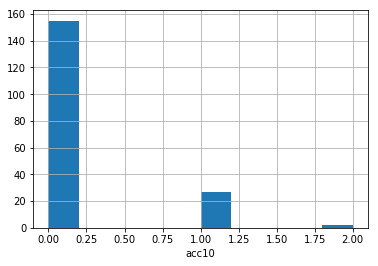

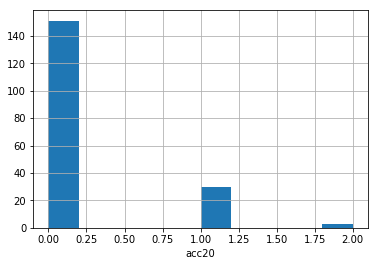

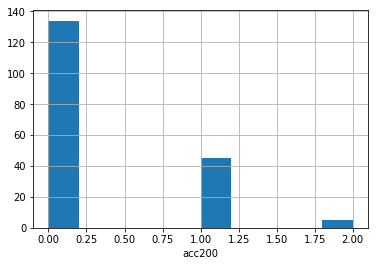

In [7]:
result = evaluate(preds, gold)

ax = result['acc10'].hist()
ax.set_xlabel("acc10")
plt.show()

ax = result['acc20'].hist()
ax.set_xlabel("acc20")
plt.show()

ax = result['acc200'].hist()
ax.set_xlabel("acc200")
plt.show()

# Use MPK rules

In [5]:
fields = ['section', 'class_']

In [6]:
rules = np.load('../data/rules_%s.npy' % '_'.join(fields))
with open('../data/%s_index.pkl' % '_'.join(fields), 'rb') as f:
    columns, index = pickle.load(f)

In [7]:
df = pd.DataFrame(rules, index = index, columns=columns)

In [44]:
preds = {}
for k, doc in tqdm_notebook(test_docs.items()):
    inferred_vector = model.infer_vector(doc, steps=5)
    sims = model.docvecs.most_similar([inferred_vector], topn=model.docvecs.count)
    if k in df:
        valid = df.index[df[k]]
        preds[k] = [_id for _id,score in sims if _id in valid][:201]
    else:
        preds[k] = [_id for _id,score in sims[:201]]    

100%|██████████| 184/184 [00:00<00:00, 22843.03it/s]

median
acc10     0.0
acc20     0.0
acc200    0.5
dtype: float64
mean
acc10     0.289855
acc20     0.344203
acc200    0.495652
dtype: float64


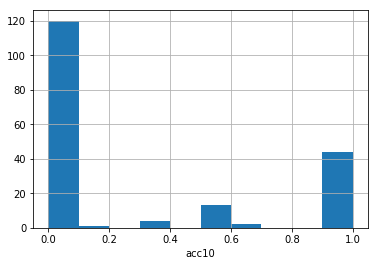

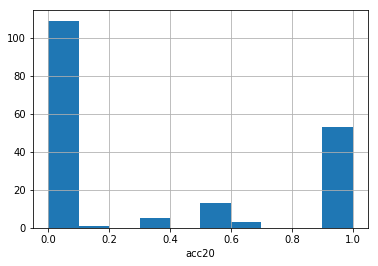

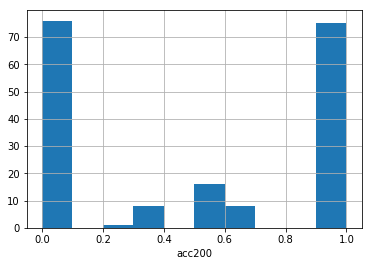

In [45]:
result = evaluate(preds, gold)

ax = result['acc10'].hist()
ax.set_xlabel("acc10")
plt.show()

ax = result['acc20'].hist()
ax.set_xlabel("acc20")
plt.show()

ax = result['acc200'].hist()
ax.set_xlabel("acc200")
plt.show()

In [47]:
# section', 'class_
# acc10     0.279891
# acc20     0.316123
# acc200    0.483152

# section
# acc10     0.289855
# acc20     0.344203
# acc200    0.495652

In [ ]:
test_ids = set(gold.keys() + [vi for v in gold.values() for vi in v])

In [ ]:
folder = join(DATA_FOLDER, 'documents/')

test_docs = {}
fnames = glob(join(folder, '*.json.gz'))
for k,doc in iter_docs(fnames):
    if k in test_ids:
        unlisted = [w for s in doc for w in s]
        test_docs[k] = unlisted

2017-10-07 10:52:19,146 [MainThread  ] [INFO ]  0: ../data/documents/72.json.gz
2017-10-07 10:52:19,237 [MainThread  ] [INFO ]  1: ../data/documents/228.json.gz
2017-10-07 10:52:20,138 [MainThread  ] [INFO ]  2: ../data/documents/791.json.gz
2017-10-07 10:52:20,432 [MainThread  ] [INFO ]  3: ../data/documents/369.json.gz
2017-10-07 10:52:21,729 [MainThread  ] [INFO ]  4: ../data/documents/19.json.gz
2017-10-07 10:52:22,565 [MainThread  ] [INFO ]  5: ../data/documents/483.json.gz
2017-10-07 10:52:22,962 [MainThread  ] [INFO ]  6: ../data/documents/165.json.gz
2017-10-07 10:52:23,085 [MainThread  ] [INFO ]  7: ../data/documents/233.json.gz
2017-10-07 10:52:23,163 [MainThread  ] [INFO ]  8: ../data/documents/299.json.gz
2017-10-07 10:52:23,322 [MainThread  ] [INFO ]  9: ../data/documents/482.json.gz
2017-10-07 10:52:23,495 [MainThread  ] [INFO ]  10: ../data/documents/473.json.gz
2017-10-07 10:52:25,047 [MainThread  ] [INFO ]  11: ../data/documents/117.json.gz
2017-10-07 10:52:25,239 [Mai

2017-10-07 10:55:12,330 [MainThread  ] [INFO ]  101: ../data/documents/535.json.gz
2017-10-07 10:55:13,495 [MainThread  ] [INFO ]  102: ../data/documents/328.json.gz
2017-10-07 10:55:16,879 [MainThread  ] [INFO ]  103: ../data/documents/900.json.gz
2017-10-07 10:55:17,676 [MainThread  ] [INFO ]  104: ../data/documents/656.json.gz
2017-10-07 10:55:23,949 [MainThread  ] [INFO ]  105: ../data/documents/666.json.gz
2017-10-07 10:55:27,023 [MainThread  ] [INFO ]  106: ../data/documents/954.json.gz
2017-10-07 10:55:27,984 [MainThread  ] [INFO ]  107: ../data/documents/860.json.gz
2017-10-07 10:55:30,468 [MainThread  ] [INFO ]  108: ../data/documents/908.json.gz
2017-10-07 10:55:38,063 [MainThread  ] [INFO ]  110: ../data/documents/437.json.gz
2017-10-07 10:55:38,999 [MainThread  ] [INFO ]  111: ../data/documents/962.json.gz
2017-10-07 10:55:39,641 [MainThread  ] [INFO ]  112: ../data/documents/46.json.gz
2017-10-07 10:55:41,585 [MainThread  ] [INFO ]  113: ../data/documents/409.json.gz
2017-

2017-10-07 10:58:20,338 [MainThread  ] [INFO ]  201: ../data/documents/828.json.gz
2017-10-07 10:58:23,035 [MainThread  ] [INFO ]  202: ../data/documents/649.json.gz
2017-10-07 10:58:26,438 [MainThread  ] [INFO ]  203: ../data/documents/603.json.gz
2017-10-07 10:58:29,292 [MainThread  ] [INFO ]  204: ../data/documents/255.json.gz
2017-10-07 10:58:31,272 [MainThread  ] [INFO ]  205: ../data/documents/700.json.gz
2017-10-07 10:58:31,688 [MainThread  ] [INFO ]  206: ../data/documents/471.json.gz
2017-10-07 10:58:32,659 [MainThread  ] [INFO ]  207: ../data/documents/798.json.gz
2017-10-07 10:58:33,247 [MainThread  ] [INFO ]  208: ../data/documents/394.json.gz
2017-10-07 10:58:33,484 [MainThread  ] [INFO ]  209: ../data/documents/58.json.gz
2017-10-07 10:58:34,407 [MainThread  ] [INFO ]  210: ../data/documents/948.json.gz
2017-10-07 10:58:35,416 [MainThread  ] [INFO ]  211: ../data/documents/140.json.gz
2017-10-07 10:58:36,585 [MainThread  ] [INFO ]  212: ../data/documents/493.json.gz
2017-

2017-10-07 11:01:54,748 [MainThread  ] [INFO ]  300: ../data/documents/178.json.gz
2017-10-07 11:01:56,379 [MainThread  ] [INFO ]  301: ../data/documents/819.json.gz
2017-10-07 11:02:04,730 [MainThread  ] [INFO ]  302: ../data/documents/380.json.gz
2017-10-07 11:02:08,261 [MainThread  ] [INFO ]  303: ../data/documents/363.json.gz
2017-10-07 11:02:09,613 [MainThread  ] [INFO ]  304: ../data/documents/848.json.gz
2017-10-07 11:02:10,118 [MainThread  ] [INFO ]  305: ../data/documents/524.json.gz
2017-10-07 11:02:10,713 [MainThread  ] [INFO ]  306: ../data/documents/379.json.gz
2017-10-07 11:02:14,911 [MainThread  ] [INFO ]  307: ../data/documents/895.json.gz
2017-10-07 11:02:17,421 [MainThread  ] [INFO ]  308: ../data/documents/557.json.gz
2017-10-07 11:02:23,140 [MainThread  ] [INFO ]  309: ../data/documents/338.json.gz
2017-10-07 11:02:24,190 [MainThread  ] [INFO ]  310: ../data/documents/176.json.gz
2017-10-07 11:02:25,254 [MainThread  ] [INFO ]  311: ../data/documents/794.json.gz
2017

2017-10-07 11:05:13,793 [MainThread  ] [INFO ]  399: ../data/documents/345.json.gz
2017-10-07 11:05:14,187 [MainThread  ] [INFO ]  400: ../data/documents/319.json.gz
2017-10-07 11:05:15,938 [MainThread  ] [INFO ]  401: ../data/documents/66.json.gz
2017-10-07 11:05:16,369 [MainThread  ] [INFO ]  402: ../data/documents/674.json.gz
2017-10-07 11:05:18,977 [MainThread  ] [INFO ]  403: ../data/documents/244.json.gz
2017-10-07 11:05:22,505 [MainThread  ] [INFO ]  404: ../data/documents/767.json.gz
2017-10-07 11:05:23,992 [MainThread  ] [INFO ]  405: ../data/documents/205.json.gz
2017-10-07 11:05:24,448 [MainThread  ] [INFO ]  406: ../data/documents/277.json.gz
2017-10-07 11:05:27,132 [MainThread  ] [INFO ]  407: ../data/documents/642.json.gz
2017-10-07 11:05:29,081 [MainThread  ] [INFO ]  408: ../data/documents/400.json.gz
2017-10-07 11:05:29,756 [MainThread  ] [INFO ]  409: ../data/documents/521.json.gz
2017-10-07 11:05:30,898 [MainThread  ] [INFO ]  410: ../data/documents/737.json.gz
2017-

2017-10-07 11:08:13,435 [MainThread  ] [INFO ]  498: ../data/documents/496.json.gz
2017-10-07 11:08:14,614 [MainThread  ] [INFO ]  499: ../data/documents/170.json.gz
2017-10-07 11:08:14,805 [MainThread  ] [INFO ]  500: ../data/documents/159.json.gz
2017-10-07 11:08:15,459 [MainThread  ] [INFO ]  501: ../data/documents/902.json.gz
2017-10-07 11:08:15,756 [MainThread  ] [INFO ]  502: ../data/documents/762.json.gz
2017-10-07 11:08:16,010 [MainThread  ] [INFO ]  503: ../data/documents/668.json.gz
2017-10-07 11:08:17,503 [MainThread  ] [INFO ]  504: ../data/documents/404.json.gz
2017-10-07 11:08:17,904 [MainThread  ] [INFO ]  505: ../data/documents/939.json.gz
2017-10-07 11:08:23,908 [MainThread  ] [INFO ]  506: ../data/documents/411.json.gz
2017-10-07 11:08:27,292 [MainThread  ] [INFO ]  507: ../data/documents/658.json.gz
2017-10-07 11:08:34,224 [MainThread  ] [INFO ]  508: ../data/documents/924.json.gz
2017-10-07 11:08:39,455 [MainThread  ] [INFO ]  509: ../data/documents/247.json.gz
2017

2017-10-07 11:11:45,144 [MainThread  ] [INFO ]  597: ../data/documents/904.json.gz
2017-10-07 11:11:45,765 [MainThread  ] [INFO ]  598: ../data/documents/622.json.gz
2017-10-07 11:11:47,825 [MainThread  ] [INFO ]  599: ../data/documents/640.json.gz
2017-10-07 11:11:48,608 [MainThread  ] [INFO ]  600: ../data/documents/919.json.gz
2017-10-07 11:11:55,584 [MainThread  ] [INFO ]  601: ../data/documents/914.json.gz
2017-10-07 11:11:57,882 [MainThread  ] [INFO ]  602: ../data/documents/615.json.gz
2017-10-07 11:12:00,880 [MainThread  ] [INFO ]  603: ../data/documents/73.json.gz
2017-10-07 11:12:01,300 [MainThread  ] [INFO ]  604: ../data/documents/772.json.gz
2017-10-07 11:12:03,553 [MainThread  ] [INFO ]  605: ../data/documents/235.json.gz
2017-10-07 11:12:03,953 [MainThread  ] [INFO ]  606: ../data/documents/621.json.gz
2017-10-07 11:12:05,031 [MainThread  ] [INFO ]  607: ../data/documents/683.json.gz
2017-10-07 11:12:08,616 [MainThread  ] [INFO ]  608: ../data/documents/273.json.gz
2017-

2017-10-07 11:14:57,922 [MainThread  ] [INFO ]  696: ../data/documents/500.json.gz
2017-10-07 11:15:00,702 [MainThread  ] [INFO ]  697: ../data/documents/227.json.gz
2017-10-07 11:15:04,831 [MainThread  ] [INFO ]  698: ../data/documents/514.json.gz
2017-10-07 11:15:07,636 [MainThread  ] [INFO ]  699: ../data/documents/555.json.gz
2017-10-07 11:15:13,869 [MainThread  ] [INFO ]  700: ../data/documents/158.json.gz
2017-10-07 11:15:15,542 [MainThread  ] [INFO ]  701: ../data/documents/436.json.gz
2017-10-07 11:15:15,837 [MainThread  ] [INFO ]  702: ../data/documents/462.json.gz
2017-10-07 11:15:17,419 [MainThread  ] [INFO ]  703: ../data/documents/911.json.gz
2017-10-07 11:15:17,974 [MainThread  ] [INFO ]  704: ../data/documents/378.json.gz
2017-10-07 11:15:20,064 [MainThread  ] [INFO ]  705: ../data/documents/812.json.gz
2017-10-07 11:15:22,420 [MainThread  ] [INFO ]  706: ../data/documents/218.json.gz
2017-10-07 11:15:23,667 [MainThread  ] [INFO ]  707: ../data/documents/508.json.gz
2017

2017-10-07 11:18:13,954 [MainThread  ] [INFO ]  795: ../data/documents/415.json.gz
2017-10-07 11:18:16,840 [MainThread  ] [INFO ]  796: ../data/documents/238.json.gz
2017-10-07 11:18:18,030 [MainThread  ] [INFO ]  797: ../data/documents/8.json.gz
2017-10-07 11:18:19,474 [MainThread  ] [INFO ]  798: ../data/documents/832.json.gz
2017-10-07 11:18:22,047 [MainThread  ] [INFO ]  799: ../data/documents/313.json.gz
2017-10-07 11:18:25,963 [MainThread  ] [INFO ]  800: ../data/documents/596.json.gz
2017-10-07 11:18:27,538 [MainThread  ] [INFO ]  801: ../data/documents/318.json.gz
2017-10-07 11:18:28,394 [MainThread  ] [INFO ]  802: ../data/documents/625.json.gz
2017-10-07 11:18:28,867 [MainThread  ] [INFO ]  803: ../data/documents/804.json.gz
2017-10-07 11:18:30,361 [MainThread  ] [INFO ]  804: ../data/documents/124.json.gz
2017-10-07 11:18:30,590 [MainThread  ] [INFO ]  805: ../data/documents/879.json.gz
2017-10-07 11:18:34,113 [MainThread  ] [INFO ]  806: ../data/documents/455.json.gz
2017-1

2017-10-07 11:22:08,408 [MainThread  ] [INFO ]  894: ../data/documents/580.json.gz
2017-10-07 11:22:09,695 [MainThread  ] [INFO ]  895: ../data/documents/48.json.gz
2017-10-07 11:22:11,129 [MainThread  ] [INFO ]  896: ../data/documents/826.json.gz
2017-10-07 11:22:13,565 [MainThread  ] [INFO ]  897: ../data/documents/513.json.gz
2017-10-07 11:22:16,620 [MainThread  ] [INFO ]  898: ../data/documents/544.json.gz
2017-10-07 11:22:19,648 [MainThread  ] [INFO ]  899: ../data/documents/286.json.gz
2017-10-07 11:22:22,180 [MainThread  ] [INFO ]  900: ../data/documents/581.json.gz
2017-10-07 11:22:22,960 [MainThread  ] [INFO ]  901: ../data/documents/183.json.gz
2017-10-07 11:22:24,478 [MainThread  ] [INFO ]  902: ../data/documents/639.json.gz
2017-10-07 11:22:24,842 [MainThread  ] [INFO ]  903: ../data/documents/208.json.gz
2017-10-07 11:22:25,052 [MainThread  ] [INFO ]  904: ../data/documents/27.json.gz
2017-10-07 11:22:25,143 [MainThread  ] [INFO ]  905: ../data/documents/280.json.gz
2017-1

2017-10-07 11:25:06,600 [MainThread  ] [INFO ]  993: ../data/documents/307.json.gz
2017-10-07 11:25:08,155 [MainThread  ] [INFO ]  994: ../data/documents/171.json.gz
2017-10-07 11:25:08,412 [MainThread  ] [INFO ]  995: ../data/documents/714.json.gz
2017-10-07 11:25:08,705 [MainThread  ] [INFO ]  996: ../data/documents/377.json.gz
2017-10-07 11:25:10,655 [MainThread  ] [INFO ]  997: ../data/documents/452.json.gz
2017-10-07 11:25:10,935 [MainThread  ] [INFO ]  998: ../data/documents/587.json.gz
2017-10-07 11:25:11,648 [MainThread  ] [INFO ]  999: ../data/documents/757.json.gz
2017-10-07 11:25:12,097 [MainThread  ] [INFO ]  1000: ../data/documents/249.json.gz


In [9]:
with open('../data/test_docs.json', 'w') as f:
    json.dump(test_docs, f)

In [8]:
with open('../data/test_docs.json', 'r') as f:
    test_docs = json.load(f)

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

stat = []
for k,v in tqdm_notebook(gold.items()):
    q_vector = model.infer_vector(test_docs[k], steps=5)
    ex_vecs = []
    matched = []
    for vi in v:
        doc_vec = model.infer_vector(test_docs[vi], steps=5)
        ex_vecs.append(doc_vec)
        if k in df:
            matched.append(int(df.loc[vi,k]))
        else:
            matched.append(0)
    sim_mat = cosine_similarity([q_vector], ex_vecs)
    stat += list(zip(sim_mat[0], matched))
#     if np.max(sim_mat)>0.8:
#         break

In [12]:
df1 = pd.DataFrame(stat, columns=['cos', 'matched'])

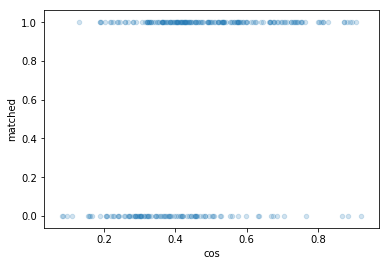

In [13]:
#section, class
df1.plot(kind='scatter', x='cos', y='matched', alpha=0.2)
plt.show()

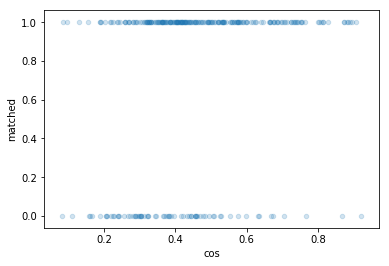

In [12]:
#section
df1.plot(kind='scatter', x='cos', y='matched', alpha=0.2)
plt.show()